<a href="https://colab.research.google.com/github/meluxis/Analysis_Transformer_ComputationalCost_Optimization/blob/main/ModelT5_Small_QuantizationPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connect google colab and Google Cloud bucket for storage
#Link google account
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets torch torchvision


#install required dependencies
!pip install transformers datasets torch torchvision
!pip install tf-keras~=2.16
!pip install Rouge
!pip install sentence-transformers
!pip install codecarbon
!pip install fvcore
!pip install datasets
!pip install tensorflow
!pip install autoawq
!pip install autoawq
!pip install -q -U https://github.com/casper-hansen/AutoAWQ/releases/download/v0.1.6/autoawq-0.1.6+cu118-cp310-cp310-linux_x86_64.whl
!pip install -q transformers accelerate

ERROR: autoawq-0.1.6+cu118-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
#import libraries
import torch
import time
import psutil  # For memory usage
import os

import sys

import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, T5Model, AutoTokenizer
from datasets import load_dataset
import argparse



In [ ]:
#import dataset

dataset = load_dataset("google/Synthetic-Persona-Chat")

train_data = dataset["train"]
test_data = dataset["test"]

# Afficher quelques exemples
print(train_data["user 1 personas"][0:5])  # Afficher 5 exemples
print(train_data["user 2 personas"][0:5])
print(train_data["Best Generated Conversation"][0:5])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['I am 32.\nI do not want a job.\nI play video games all day.\nI still live at home with my parents.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.\nI eat all take out.', 'I write.\nI work at mcdonald s.\nI watch youtube videos.\nI have brown hair.', 'I am bald.\nI like to swim.\nMy favorite drink is chocolate milk.\nI don t work.']
['My favorite drink is iced coffee.\nI have a black belt in karate.\nI m in a jazz band and play the saxophone.\nI vacation along lake michigan every summer.', 'I have a ford f150.\nI like ford cars.\nMy truck is black.\nI also like ford trucks.\nI own a ford truck.', 'I can recite the movie young frankenstein word for word.\nI like to make my own clothes.\nI am partially blind.\nI do volunteer work for human rights organizations.\nI can do convincing bird calls.', 'I want to move.\nI don t like feeling

In [ ]:
import torch
from transformers import T5ForConditionalGeneration
import torch.nn.utils.prune as prune
import os
import sys

#Define model from https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/main/notebooks/t5-trivia.ipynb#scrollTo=DZhAd0U_4B_o
# Required to fix Colab flag parsing issue.

sys.argv = sys.argv[:1]

BASE_DIR = "gs://data_bucket_experimental_analysis" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True

MODEL_SIZE = "base" #@param["small", "base", "large", "3B", "11B"]
PRETRAINED_DIR = "t5-small"
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)


# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

#tf.io.gfile.makedirs(MODEL_DIR)
# The models from our paper are based on the Mesh Tensorflow Transformer.
#Change to T5ForConditionalGeneration for finetuning task
model = T5ForConditionalGeneration.from_pretrained(PRETRAINED_DIR)

# Apply magnitude-based pruning **before** quantization
def apply_magnitude_pruning(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            # Apply L1 unstructured pruning
            module.weight = torch.nn.Parameter(module.weight.contiguous())
            prune.l1_unstructured(module, name="weight", amount=amount)
            # Make pruning permanent (otherwise, pruning masks remain)
            prune.remove(module, name="weight")
            # Ensure weight is contiguous after pruning
            module.weight = torch.nn.Parameter(module.weight.clone().detach())

# Apply pruning
apply_magnitude_pruning(model, amount=0.3)

# Verify pruning effectiveness on pruned (not quantized) model
for name, module in model.named_modules():  # Check sparsity on pruned model
    if isinstance(module, torch.nn.Linear):
        zero_count = torch.sum(module.weight == 0).item()
        total_count = module.weight.nelement()
        sparsity = zero_count / total_count
        print(f"Layer: {name}, Pruned: {sparsity:.2%} of weights")


torch.save(model.state_dict(), "t5_original.pth")
print(f"Original Model Size: {os.path.getsize('t5_original.pth') / 1e6:.2f} MB")

# Now apply dynamic quantization after pruning
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Layer: {name}, dtype: {module.weight.dtype}")
torch.save(quantized_model.state_dict(), "t5_quantized.pth")
print(f"Quantized Model Size: {os.path.getsize('t5_quantized.pth') / 1e6:.2f} MB")

print("T5 model pruned and dynamically quantized.")




Layer: encoder.block.0.layer.0.SelfAttention.q, Pruned: 30.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.k, Pruned: 30.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.v, Pruned: 30.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.o, Pruned: 30.00% of weights
Layer: encoder.block.0.layer.1.DenseReluDense.wi, Pruned: 30.00% of weights
Layer: encoder.block.0.layer.1.DenseReluDense.wo, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.q, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.k, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.v, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.o, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.1.DenseReluDense.wi, Pruned: 30.00% of weights
Layer: encoder.block.1.layer.1.DenseReluDense.wo, Pruned: 30.00% of weights
Layer: encoder.block.2.layer.0.SelfAttention.q, Pruned: 30.00% of weights
Layer: encoder.block.2.layer.0

In [ ]:
#Verify pruning on weights

import torch

# Pick a layer to inspect
layer_name = "encoder.block.0.layer.0.SelfAttention.q"  # Change as needed

# Extract the layer
layer = dict(model.named_modules())[layer_name]

# Print some weight values
print(f"Before Pruning - First 10 Weights of {layer_name}:")
print(layer.weight.flatten()[:10])  # First 10 weights

# Count the number of zeros
zero_count = torch.sum(layer.weight == 0).item()
total_count = layer.weight.nelement()
sparsity = zero_count / total_count

print(f"Layer {layer_name} - Zero Count: {zero_count}, Total: {total_count}, Sparsity: {sparsity:.2%}")


Before Pruning - First 10 Weights of encoder.block.0.layer.0.SelfAttention.q:
tensor([-0.0000, -0.0737,  0.0000,  0.0000, -0.0708,  0.0000, -0.0432,  0.0615,
        -0.0569, -0.0371], grad_fn=<SliceBackward0>)
Layer encoder.block.0.layer.0.SelfAttention.q - Zero Count: 78643, Total: 262144, Sparsity: 30.00%


In [ ]:
from transformers import T5Tokenizer

# Load Tokenizer (Ensure it Matches Model Version)
TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

def preprocess_function(examples):
    # Combine personas into a single input string
    inputs = [p1 + " " + p2 for p1,
              p2 in zip(examples["user 1 personas"],
                        examples["user 2 personas"])
              ]

    # Tokenize inputs (Persona 1 + Persona 2)
    model_inputs = TOKENIZER(inputs,
                             max_length=512,
                             truncation=True,
                             padding="max_length")

    # Tokenize targets (best-generated conversations)
    conversations = [str(conv) for conv in examples["Best Generated Conversation"]]
    labels = TOKENIZER(text_target=conversations,
                       max_length=128,
                       truncation=True,
                       padding="max_length")

    # Assign label input_ids
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Preprocess Dataset
tokenized_train_dataset = train_data.map(preprocess_function, batched=True, batch_size=16)
tokenized_test_dataset = test_data.map(preprocess_function, batched=True, batch_size=16)

# Example Usage (Access Tokenized Data)
print(tokenized_train_dataset[0]["input_ids"])
print(tokenized_train_dataset[0]["labels"])


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[27, 183, 3538, 5, 27, 103, 59, 241, 3, 9, 613, 5, 27, 577, 671, 1031, 66, 239, 5, 27, 341, 619, 44, 234, 28, 82, 1362, 5, 499, 1305, 3281, 19, 3, 867, 26, 1975, 5, 27, 43, 3, 9, 1001, 6782, 16, 3, 4031, 342, 5, 27, 3, 51, 16, 3, 9, 9948, 1928, 11, 577, 8, 3, 7, 9, 226, 32, 6399, 5, 27, 4257, 590, 6957, 2278, 12588, 334, 1248, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Transform Data for compatibility with pytorch

from torch.utils.data import DataLoader, random_split

# Create a custom Dataset class
class PersonaChatDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['labels'])
        }

# Create DataLoaders
train_dataset = PersonaChatDataset(tokenized_train_dataset)
test_dataset = PersonaChatDataset(tokenized_test_dataset)

# Define the validation split ratio (e.g., 80% test, 20% validation)
val_size = int(0.2 * len(test_dataset))  # 20% for validation
test_size = len(test_dataset) - val_size  # 80% for testing

# Split the test dataset into validation and actual test sets
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5) # Adjust batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=5) # Adjust batch size as needed
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=5)  # Validation data
print(train_dataset[0])


{'input_ids': tensor([   27,   183,  3538,     5,    27,   103,    59,   241,     3,     9,
          613,     5,    27,   577,   671,  1031,    66,   239,     5,    27,
          341,   619,    44,   234,    28,    82,  1362,     5,   499,  1305,
         3281,    19,     3,   867,    26,  1975,     5,    27,    43,     3,
            9,  1001,  6782,    16,     3,  4031,   342,     5,    27,     3,
           51,    16,     3,     9,  9948,  1928,    11,   577,     8,     3,
            7,     9,   226,    32,  6399,     5,    27,  4257,   590,  6957,
         2278, 12588,   334,  1248,     5,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
!pip install codecarbon
!pip install fvcore
!pip install fvcore.nn

ERROR: Could not find a version that satisfies the requirement fvcore.nn (from versions: none)
ERROR: No matching distribution found for fvcore.nn


<ipython-input-10-e11d34efc9f7>:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-10-e11d34efc9f7>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
[codecarbon ERROR @ 04:26:34] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 04:26:34] Another instance of codecarbon is already running. Exiting.


Running on 0 GPUs
Epoch 1/3


  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-10-e11d34efc9f7>:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: quantized::linear_dynamic: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiab

Batch 1/559 - Loss: 5.8332133293151855


  0%|          | 2/559 [00:16<1:14:12,  7.99s/it]

Batch 2/559 - Loss: 5.6129584312438965


  1%|          | 3/559 [00:22<1:07:09,  7.25s/it]

Batch 3/559 - Loss: 5.769365310668945


  1%|          | 4/559 [00:26<56:26,  6.10s/it]  

Batch 4/559 - Loss: 5.594616413116455


  1%|          | 5/559 [00:31<51:01,  5.53s/it]

Batch 5/559 - Loss: 5.7663254737854


  1%|          | 6/559 [00:36<48:48,  5.30s/it]

Batch 6/559 - Loss: 5.719558238983154


  1%|▏         | 7/559 [00:40<44:46,  4.87s/it]

Batch 7/559 - Loss: 5.759008884429932


  1%|▏         | 8/559 [00:44<42:18,  4.61s/it]

Batch 8/559 - Loss: 5.5440473556518555


  2%|▏         | 9/559 [00:49<42:58,  4.69s/it]

Batch 9/559 - Loss: 5.845328330993652


  2%|▏         | 10/559 [00:53<40:37,  4.44s/it]

Batch 10/559 - Loss: 5.726047515869141


  2%|▏         | 11/559 [00:56<39:05,  4.28s/it]

Batch 11/559 - Loss: 5.602202415466309


  2%|▏         | 12/559 [01:01<41:00,  4.50s/it]

Batch 12/559 - Loss: 5.522768497467041


  2%|▏         | 13/559 [01:06<40:02,  4.40s/it]

Batch 13/559 - Loss: 5.737425804138184


  3%|▎         | 14/559 [01:10<38:48,  4.27s/it]

Batch 14/559 - Loss: 5.695834636688232


  3%|▎         | 15/559 [01:14<40:25,  4.46s/it]

Batch 15/559 - Loss: 5.8276753425598145


  3%|▎         | 16/559 [01:18<38:57,  4.30s/it]

Batch 16/559 - Loss: 5.736717700958252


  3%|▎         | 17/559 [01:22<37:53,  4.19s/it]

Batch 17/559 - Loss: 5.844788551330566


  3%|▎         | 18/559 [01:27<38:35,  4.28s/it]

Batch 18/559 - Loss: 5.681750297546387


  3%|▎         | 19/559 [01:31<38:26,  4.27s/it]

Batch 19/559 - Loss: 5.690703392028809


  4%|▎         | 20/559 [01:35<37:38,  4.19s/it]

Batch 20/559 - Loss: 5.765705108642578


  4%|▍         | 21/559 [01:39<37:53,  4.23s/it]

Batch 21/559 - Loss: 5.737771987915039


  4%|▍         | 22/559 [01:44<38:19,  4.28s/it]

Batch 22/559 - Loss: 5.734316825866699


  4%|▍         | 23/559 [01:48<37:38,  4.21s/it]

Batch 23/559 - Loss: 5.694971561431885


  4%|▍         | 24/559 [01:52<38:06,  4.27s/it]

Batch 24/559 - Loss: 5.608436107635498


  4%|▍         | 25/559 [01:57<38:47,  4.36s/it]

Batch 25/559 - Loss: 5.656552314758301


  5%|▍         | 26/559 [02:01<38:13,  4.30s/it]

Batch 26/559 - Loss: 5.619504451751709


  5%|▍         | 27/559 [02:05<37:29,  4.23s/it]

Batch 27/559 - Loss: 5.743033409118652


  5%|▌         | 28/559 [02:10<38:33,  4.36s/it]

Batch 28/559 - Loss: 5.776824951171875


  5%|▌         | 29/559 [02:14<37:36,  4.26s/it]

Batch 29/559 - Loss: 5.652292728424072


  5%|▌         | 30/559 [02:18<36:56,  4.19s/it]

Batch 30/559 - Loss: 5.6899333000183105


  6%|▌         | 31/559 [02:23<38:42,  4.40s/it]

Batch 31/559 - Loss: 5.691747665405273


  6%|▌         | 32/559 [02:27<37:24,  4.26s/it]

Batch 32/559 - Loss: 5.706883907318115


  6%|▌         | 33/559 [02:31<36:33,  4.17s/it]

Batch 33/559 - Loss: 5.775753974914551


  6%|▌         | 34/559 [02:35<37:59,  4.34s/it]

Batch 34/559 - Loss: 5.784055233001709


  6%|▋         | 35/559 [02:39<37:04,  4.25s/it]

Batch 35/559 - Loss: 5.682992935180664


  6%|▋         | 36/559 [02:43<36:02,  4.13s/it]

Batch 36/559 - Loss: 5.8724517822265625


  7%|▋         | 37/559 [02:48<38:08,  4.38s/it]

Batch 37/559 - Loss: 5.745238780975342


  7%|▋         | 38/559 [02:52<37:02,  4.27s/it]

Batch 38/559 - Loss: 5.636662483215332


  7%|▋         | 39/559 [02:56<36:11,  4.18s/it]

Batch 39/559 - Loss: 5.682386875152588


  7%|▋         | 40/559 [03:01<37:46,  4.37s/it]

Batch 40/559 - Loss: 5.585724353790283


  7%|▋         | 41/559 [03:05<36:47,  4.26s/it]

Batch 41/559 - Loss: 5.835322856903076


  8%|▊         | 42/559 [03:09<36:00,  4.18s/it]

Batch 42/559 - Loss: 5.774644374847412


  8%|▊         | 43/559 [03:13<36:30,  4.24s/it]

Batch 43/559 - Loss: 5.718356609344482


  8%|▊         | 44/559 [03:18<36:30,  4.25s/it]

Batch 44/559 - Loss: 5.836207866668701


  8%|▊         | 45/559 [03:22<35:55,  4.19s/it]

Batch 45/559 - Loss: 5.7649664878845215


  8%|▊         | 46/559 [03:26<36:08,  4.23s/it]

Batch 46/559 - Loss: 5.671937465667725


  8%|▊         | 47/559 [03:30<36:32,  4.28s/it]

Batch 47/559 - Loss: 5.794234275817871


  9%|▊         | 48/559 [03:34<35:20,  4.15s/it]

Batch 48/559 - Loss: 5.705108165740967


  9%|▉         | 49/559 [03:38<34:35,  4.07s/it]

Batch 49/559 - Loss: 5.6176981925964355


  9%|▉         | 50/559 [03:43<36:19,  4.28s/it]

Batch 50/559 - Loss: 5.617482662200928


  9%|▉         | 51/559 [03:47<35:17,  4.17s/it]

Batch 51/559 - Loss: 5.699434280395508


  9%|▉         | 52/559 [03:51<34:51,  4.13s/it]

Batch 52/559 - Loss: 5.774541854858398


  9%|▉         | 53/559 [03:56<36:44,  4.36s/it]

Batch 53/559 - Loss: 5.724621772766113


 10%|▉         | 54/559 [04:00<36:02,  4.28s/it]

Batch 54/559 - Loss: 5.657031536102295


 10%|▉         | 55/559 [04:04<34:53,  4.15s/it]

Batch 55/559 - Loss: 5.61133337020874


 10%|█         | 56/559 [04:09<36:47,  4.39s/it]

Batch 56/559 - Loss: 5.824584484100342


 10%|█         | 57/559 [04:13<35:39,  4.26s/it]

Batch 57/559 - Loss: 5.548187732696533


 10%|█         | 58/559 [04:17<34:54,  4.18s/it]

Batch 58/559 - Loss: 5.818054676055908


 11%|█         | 59/559 [04:21<36:28,  4.38s/it]

Batch 59/559 - Loss: 5.695123195648193


 11%|█         | 60/559 [04:25<35:13,  4.23s/it]

Batch 60/559 - Loss: 5.688779830932617


 11%|█         | 61/559 [04:29<34:25,  4.15s/it]

Batch 61/559 - Loss: 5.650964736938477


 11%|█         | 62/559 [04:34<36:09,  4.37s/it]

Batch 62/559 - Loss: 5.629617691040039


 11%|█▏        | 63/559 [04:38<35:20,  4.28s/it]

Batch 63/559 - Loss: 5.6505889892578125


 11%|█▏        | 64/559 [04:42<34:44,  4.21s/it]

Batch 64/559 - Loss: 5.678199291229248


 12%|█▏        | 65/559 [04:47<36:32,  4.44s/it]

Batch 65/559 - Loss: 5.7694926261901855


 12%|█▏        | 66/559 [04:51<35:10,  4.28s/it]

Batch 66/559 - Loss: 5.7202043533325195


 12%|█▏        | 67/559 [04:55<34:28,  4.20s/it]

Batch 67/559 - Loss: 5.730310440063477


 12%|█▏        | 68/559 [05:00<35:49,  4.38s/it]

Batch 68/559 - Loss: 5.720438480377197


 12%|█▏        | 69/559 [05:04<34:59,  4.29s/it]

Batch 69/559 - Loss: 5.626565933227539


 13%|█▎        | 70/559 [05:08<34:14,  4.20s/it]

Batch 70/559 - Loss: 5.71293830871582


 13%|█▎        | 71/559 [05:13<34:57,  4.30s/it]

Batch 71/559 - Loss: 5.7832159996032715


 13%|█▎        | 72/559 [05:17<34:41,  4.27s/it]

Batch 72/559 - Loss: 5.716013431549072


 13%|█▎        | 73/559 [05:21<33:48,  4.17s/it]

Batch 73/559 - Loss: 5.706912040710449


 13%|█▎        | 74/559 [05:25<33:48,  4.18s/it]

Batch 74/559 - Loss: 5.796912670135498


 13%|█▎        | 75/559 [05:29<34:37,  4.29s/it]

Batch 75/559 - Loss: 5.776766300201416


 14%|█▎        | 76/559 [05:33<33:48,  4.20s/it]

Batch 76/559 - Loss: 5.7060089111328125


 14%|█▍        | 77/559 [05:38<33:24,  4.16s/it]

Batch 77/559 - Loss: 5.662917137145996


 14%|█▍        | 78/559 [05:42<34:34,  4.31s/it]

Batch 78/559 - Loss: 5.695288181304932


 14%|█▍        | 79/559 [05:46<33:29,  4.19s/it]

Batch 79/559 - Loss: 5.721871852874756


 14%|█▍        | 80/559 [05:50<33:00,  4.14s/it]

Batch 80/559 - Loss: 5.758506774902344


 14%|█▍        | 81/559 [05:55<34:41,  4.36s/it]

Batch 81/559 - Loss: 5.520169734954834


 15%|█▍        | 82/559 [05:59<33:46,  4.25s/it]

Batch 82/559 - Loss: 5.644693851470947


 15%|█▍        | 83/559 [06:03<33:01,  4.16s/it]

Batch 83/559 - Loss: 5.729183673858643


 15%|█▌        | 84/559 [06:08<34:46,  4.39s/it]

Batch 84/559 - Loss: 5.634673118591309


 15%|█▌        | 85/559 [06:12<33:44,  4.27s/it]

Batch 85/559 - Loss: 5.783947944641113


 15%|█▌        | 86/559 [06:16<32:56,  4.18s/it]

Batch 86/559 - Loss: 5.635488986968994


 16%|█▌        | 87/559 [06:21<34:43,  4.41s/it]

Batch 87/559 - Loss: 5.765623569488525


 16%|█▌        | 88/559 [06:25<33:38,  4.29s/it]

Batch 88/559 - Loss: 5.67509651184082


 16%|█▌        | 89/559 [06:29<32:51,  4.20s/it]

Batch 89/559 - Loss: 5.746406078338623


 16%|█▌        | 90/559 [06:34<34:30,  4.41s/it]

Batch 90/559 - Loss: 5.77803897857666


 16%|█▋        | 91/559 [06:38<33:25,  4.29s/it]

Batch 91/559 - Loss: 5.726226806640625


 16%|█▋        | 92/559 [06:42<32:44,  4.21s/it]

Batch 92/559 - Loss: 5.68613338470459


 17%|█▋        | 93/559 [06:46<33:34,  4.32s/it]

Batch 93/559 - Loss: 5.61934232711792


 17%|█▋        | 94/559 [06:51<33:17,  4.30s/it]

Batch 94/559 - Loss: 5.581299304962158


 17%|█▋        | 95/559 [06:54<32:23,  4.19s/it]

Batch 95/559 - Loss: 5.902368545532227


 17%|█▋        | 96/559 [06:59<32:55,  4.27s/it]

Batch 96/559 - Loss: 5.73617696762085


 17%|█▋        | 97/559 [07:03<33:12,  4.31s/it]

Batch 97/559 - Loss: 5.604111671447754


 18%|█▊        | 98/559 [07:07<32:15,  4.20s/it]

Batch 98/559 - Loss: 5.731820583343506


 18%|█▊        | 99/559 [07:11<31:55,  4.16s/it]

Batch 99/559 - Loss: 5.699444770812988


 18%|█▊        | 100/559 [07:16<33:05,  4.33s/it]

Batch 100/559 - Loss: 5.8107218742370605


 18%|█▊        | 101/559 [07:20<32:09,  4.21s/it]

Batch 101/559 - Loss: 5.692091464996338


 18%|█▊        | 102/559 [07:24<31:34,  4.15s/it]

Batch 102/559 - Loss: 5.69744873046875


 18%|█▊        | 103/559 [07:29<33:14,  4.37s/it]

Batch 103/559 - Loss: 5.710657119750977


 19%|█▊        | 104/559 [07:33<32:11,  4.25s/it]

Batch 104/559 - Loss: 5.699931621551514


 19%|█▉        | 105/559 [07:38<33:28,  4.42s/it]

Batch 105/559 - Loss: 5.498873710632324


 19%|█▉        | 106/559 [07:42<33:51,  4.48s/it]

Batch 106/559 - Loss: 5.605409145355225


 19%|█▉        | 107/559 [07:46<32:56,  4.37s/it]

Batch 107/559 - Loss: 5.668756484985352


 19%|█▉        | 108/559 [07:51<32:16,  4.29s/it]

Batch 108/559 - Loss: 5.675026893615723


 19%|█▉        | 109/559 [07:55<32:53,  4.39s/it]

Batch 109/559 - Loss: 5.6356353759765625


 20%|█▉        | 110/559 [07:59<31:53,  4.26s/it]

Batch 110/559 - Loss: 5.770104885101318


 20%|█▉        | 111/559 [08:03<31:21,  4.20s/it]

Batch 111/559 - Loss: 5.588273525238037


 20%|██        | 112/559 [08:08<32:56,  4.42s/it]

Batch 112/559 - Loss: 5.625378131866455


 20%|██        | 113/559 [08:12<31:50,  4.28s/it]

Batch 113/559 - Loss: 5.794708728790283


 20%|██        | 114/559 [08:16<31:15,  4.22s/it]

Batch 114/559 - Loss: 5.647205829620361


 21%|██        | 115/559 [08:21<32:41,  4.42s/it]

Batch 115/559 - Loss: 5.729981422424316


 21%|██        | 116/559 [08:25<31:57,  4.33s/it]

Batch 116/559 - Loss: 5.769758701324463


 21%|██        | 117/559 [08:29<31:31,  4.28s/it]

Batch 117/559 - Loss: 5.806977272033691


 21%|██        | 118/559 [08:34<32:37,  4.44s/it]

Batch 118/559 - Loss: 5.715743541717529


 21%|██▏       | 119/559 [08:38<31:40,  4.32s/it]

Batch 119/559 - Loss: 5.687345504760742


 21%|██▏       | 120/559 [08:42<30:50,  4.22s/it]

Batch 120/559 - Loss: 5.709831714630127


 22%|██▏       | 121/559 [08:47<32:03,  4.39s/it]

Batch 121/559 - Loss: 5.830373287200928


 22%|██▏       | 122/559 [08:51<31:01,  4.26s/it]

Batch 122/559 - Loss: 5.623153209686279


 22%|██▏       | 123/559 [08:55<30:24,  4.19s/it]

Batch 123/559 - Loss: 5.634983062744141


 22%|██▏       | 124/559 [09:00<31:42,  4.37s/it]

Batch 124/559 - Loss: 5.7113037109375


 22%|██▏       | 125/559 [09:04<30:52,  4.27s/it]

Batch 125/559 - Loss: 5.838160514831543


 23%|██▎       | 126/559 [09:08<30:18,  4.20s/it]

Batch 126/559 - Loss: 5.644382476806641


 23%|██▎       | 127/559 [09:13<31:46,  4.41s/it]

Batch 127/559 - Loss: 5.771234512329102


 23%|██▎       | 128/559 [09:17<31:10,  4.34s/it]

Batch 128/559 - Loss: 5.803007125854492


 23%|██▎       | 129/559 [09:21<30:14,  4.22s/it]

Batch 129/559 - Loss: 5.734714984893799


 23%|██▎       | 130/559 [09:26<31:45,  4.44s/it]

Batch 130/559 - Loss: 5.675896167755127


 23%|██▎       | 131/559 [09:30<30:59,  4.34s/it]

Batch 131/559 - Loss: 5.659428119659424


 24%|██▎       | 132/559 [09:34<29:54,  4.20s/it]

Batch 132/559 - Loss: 5.676920413970947


 24%|██▍       | 133/559 [09:39<31:23,  4.42s/it]

Batch 133/559 - Loss: 5.613760948181152


 24%|██▍       | 134/559 [09:42<30:03,  4.24s/it]

Batch 134/559 - Loss: 5.771059036254883


 24%|██▍       | 135/559 [09:46<29:15,  4.14s/it]

Batch 135/559 - Loss: 5.834478378295898


 24%|██▍       | 136/559 [09:51<30:51,  4.38s/it]

Batch 136/559 - Loss: 5.71584939956665


 25%|██▍       | 137/559 [09:55<29:55,  4.25s/it]

Batch 137/559 - Loss: 5.787775993347168


 25%|██▍       | 138/559 [09:59<29:19,  4.18s/it]

Batch 138/559 - Loss: 5.822811126708984


 25%|██▍       | 139/559 [10:04<30:34,  4.37s/it]

Batch 139/559 - Loss: 5.694911479949951


 25%|██▌       | 140/559 [10:08<30:01,  4.30s/it]

Batch 140/559 - Loss: 5.669536590576172


 25%|██▌       | 141/559 [10:12<29:21,  4.21s/it]

Batch 141/559 - Loss: 5.635486125946045


 25%|██▌       | 142/559 [10:17<30:49,  4.44s/it]

Batch 142/559 - Loss: 5.720776081085205


 26%|██▌       | 143/559 [10:21<29:57,  4.32s/it]

Batch 143/559 - Loss: 5.619024276733398


 26%|██▌       | 144/559 [10:25<29:27,  4.26s/it]

Batch 144/559 - Loss: 5.720987796783447


 26%|██▌       | 145/559 [10:30<30:36,  4.44s/it]

Batch 145/559 - Loss: 5.611043930053711


 26%|██▌       | 146/559 [10:34<29:54,  4.34s/it]

Batch 146/559 - Loss: 5.917971134185791


 26%|██▋       | 147/559 [10:38<29:12,  4.25s/it]

Batch 147/559 - Loss: 5.699551105499268


 26%|██▋       | 148/559 [10:43<30:04,  4.39s/it]

Batch 148/559 - Loss: 5.612604141235352


 27%|██▋       | 149/559 [10:47<29:37,  4.34s/it]

Batch 149/559 - Loss: 5.707622051239014


 27%|██▋       | 150/559 [10:51<28:47,  4.22s/it]

Batch 150/559 - Loss: 5.6018781661987305


 27%|██▋       | 151/559 [10:56<29:51,  4.39s/it]

Batch 151/559 - Loss: 5.483037948608398


 27%|██▋       | 152/559 [11:00<29:19,  4.32s/it]

Batch 152/559 - Loss: 5.61755895614624


 27%|██▋       | 153/559 [11:04<28:42,  4.24s/it]

Batch 153/559 - Loss: 5.694638729095459


 28%|██▊       | 154/559 [11:09<29:40,  4.40s/it]

Batch 154/559 - Loss: 5.724020481109619


 28%|██▊       | 155/559 [11:13<29:27,  4.38s/it]

Batch 155/559 - Loss: 5.500462532043457


 28%|██▊       | 156/559 [11:17<28:39,  4.27s/it]

Batch 156/559 - Loss: 5.809106826782227


 28%|██▊       | 157/559 [11:22<28:40,  4.28s/it]

Batch 157/559 - Loss: 5.674563884735107


 28%|██▊       | 158/559 [11:26<29:08,  4.36s/it]

Batch 158/559 - Loss: 5.68843412399292


 28%|██▊       | 159/559 [11:30<28:31,  4.28s/it]

Batch 159/559 - Loss: 5.7563910484313965


 29%|██▊       | 160/559 [11:35<28:24,  4.27s/it]

Batch 160/559 - Loss: 5.783108711242676


 29%|██▉       | 161/559 [11:40<30:06,  4.54s/it]

Batch 161/559 - Loss: 5.705989837646484


 29%|██▉       | 162/559 [11:44<28:57,  4.38s/it]

Batch 162/559 - Loss: 5.60788106918335


 29%|██▉       | 163/559 [11:48<28:25,  4.31s/it]

Batch 163/559 - Loss: 5.637078285217285


 29%|██▉       | 164/559 [11:52<29:00,  4.41s/it]

Batch 164/559 - Loss: 5.534599781036377


 30%|██▉       | 165/559 [11:57<28:13,  4.30s/it]

Batch 165/559 - Loss: 5.6572489738464355


 30%|██▉       | 166/559 [12:01<27:37,  4.22s/it]

Batch 166/559 - Loss: 5.892354488372803


 30%|██▉       | 167/559 [12:05<28:43,  4.40s/it]

Batch 167/559 - Loss: 5.867120265960693


 30%|███       | 168/559 [12:09<27:45,  4.26s/it]

Batch 168/559 - Loss: 5.8870320320129395


 30%|███       | 169/559 [12:13<27:17,  4.20s/it]

Batch 169/559 - Loss: 5.760529518127441


 30%|███       | 170/559 [12:18<28:19,  4.37s/it]

Batch 170/559 - Loss: 5.915823936462402


 31%|███       | 171/559 [12:22<27:43,  4.29s/it]

Batch 171/559 - Loss: 5.73016881942749


 31%|███       | 172/559 [12:26<27:05,  4.20s/it]

Batch 172/559 - Loss: 5.743401050567627


 31%|███       | 173/559 [12:31<28:26,  4.42s/it]

Batch 173/559 - Loss: 5.774227619171143


 31%|███       | 174/559 [12:35<27:47,  4.33s/it]

Batch 174/559 - Loss: 5.699521064758301


 31%|███▏      | 175/559 [12:40<27:46,  4.34s/it]

Batch 175/559 - Loss: 5.65471887588501


 31%|███▏      | 176/559 [12:44<28:32,  4.47s/it]

Batch 176/559 - Loss: 5.666781425476074


 32%|███▏      | 177/559 [12:49<27:50,  4.37s/it]

Batch 177/559 - Loss: 5.727737903594971


 32%|███▏      | 178/559 [12:53<27:34,  4.34s/it]

Batch 178/559 - Loss: 5.637903690338135


 32%|███▏      | 179/559 [12:58<28:19,  4.47s/it]

Batch 179/559 - Loss: 5.768911361694336


 32%|███▏      | 180/559 [13:02<27:50,  4.41s/it]

Batch 180/559 - Loss: 5.952639579772949


 32%|███▏      | 181/559 [13:06<28:00,  4.45s/it]

Batch 181/559 - Loss: 5.8763651847839355


 33%|███▎      | 182/559 [13:11<27:45,  4.42s/it]

Batch 182/559 - Loss: 5.732443332672119


 33%|███▎      | 183/559 [13:15<26:52,  4.29s/it]

Batch 183/559 - Loss: 5.627211570739746


 33%|███▎      | 184/559 [13:19<27:04,  4.33s/it]

Batch 184/559 - Loss: 5.635338306427002


 33%|███▎      | 185/559 [13:24<27:15,  4.37s/it]

Batch 185/559 - Loss: 5.824520111083984


 33%|███▎      | 186/559 [13:28<26:45,  4.30s/it]

Batch 186/559 - Loss: 5.842268943786621


 33%|███▎      | 187/559 [13:32<26:51,  4.33s/it]

Batch 187/559 - Loss: 5.826077938079834


 34%|███▎      | 188/559 [13:37<26:46,  4.33s/it]

Batch 188/559 - Loss: 5.7471795082092285


 34%|███▍      | 189/559 [13:40<26:01,  4.22s/it]

Batch 189/559 - Loss: 5.701460838317871


 34%|███▍      | 190/559 [13:45<26:03,  4.24s/it]

Batch 190/559 - Loss: 5.821328163146973


 34%|███▍      | 191/559 [13:49<26:50,  4.38s/it]

Batch 191/559 - Loss: 5.748072624206543


 34%|███▍      | 192/559 [13:53<25:58,  4.25s/it]

Batch 192/559 - Loss: 5.881939888000488


 35%|███▍      | 193/559 [13:58<26:01,  4.27s/it]

Batch 193/559 - Loss: 5.704484939575195


 35%|███▍      | 194/559 [14:02<26:36,  4.37s/it]

Batch 194/559 - Loss: 5.619524955749512


 35%|███▍      | 195/559 [14:06<26:06,  4.30s/it]

Batch 195/559 - Loss: 6.031678199768066


 35%|███▌      | 196/559 [14:11<26:06,  4.31s/it]

Batch 196/559 - Loss: 5.893229007720947


 35%|███▌      | 197/559 [14:16<26:45,  4.44s/it]

Batch 197/559 - Loss: 5.646667003631592


 35%|███▌      | 198/559 [14:20<25:51,  4.30s/it]

Batch 198/559 - Loss: 5.856178283691406


 36%|███▌      | 199/559 [14:24<25:50,  4.31s/it]

Batch 199/559 - Loss: 5.71251916885376


 36%|███▌      | 200/559 [14:28<26:23,  4.41s/it]

Batch 200/559 - Loss: 5.910037517547607


 36%|███▌      | 201/559 [14:33<25:46,  4.32s/it]

Batch 201/559 - Loss: 5.78301477432251


 36%|███▌      | 202/559 [14:37<25:59,  4.37s/it]

Batch 202/559 - Loss: 5.8055195808410645


 36%|███▋      | 203/559 [14:42<26:03,  4.39s/it]

Batch 203/559 - Loss: 5.838907241821289


 36%|███▋      | 204/559 [14:46<25:32,  4.32s/it]

Batch 204/559 - Loss: 5.774203777313232


 37%|███▋      | 205/559 [14:50<25:16,  4.28s/it]

Batch 205/559 - Loss: 5.525660037994385


 37%|███▋      | 206/559 [14:54<25:46,  4.38s/it]

Batch 206/559 - Loss: 5.768948078155518


 37%|███▋      | 207/559 [14:58<24:54,  4.25s/it]

Batch 207/559 - Loss: 5.748838901519775


 37%|███▋      | 208/559 [15:03<24:37,  4.21s/it]

Batch 208/559 - Loss: 5.521125316619873


 37%|███▋      | 209/559 [15:07<25:34,  4.38s/it]

Batch 209/559 - Loss: 5.7706451416015625


 38%|███▊      | 210/559 [15:11<24:43,  4.25s/it]

Batch 210/559 - Loss: 5.713296890258789


 38%|███▊      | 211/559 [15:15<24:21,  4.20s/it]

Batch 211/559 - Loss: 5.88005256652832


 38%|███▊      | 212/559 [15:20<25:23,  4.39s/it]

Batch 212/559 - Loss: 5.676474094390869


 38%|███▊      | 213/559 [15:24<24:29,  4.25s/it]

Batch 213/559 - Loss: 5.707798004150391


 38%|███▊      | 214/559 [15:28<24:02,  4.18s/it]

Batch 214/559 - Loss: 5.840266704559326


 38%|███▊      | 215/559 [15:33<25:23,  4.43s/it]

Batch 215/559 - Loss: 5.701615810394287


 39%|███▊      | 216/559 [15:37<24:34,  4.30s/it]

Batch 216/559 - Loss: 5.653867244720459


 39%|███▉      | 217/559 [15:41<24:14,  4.25s/it]

Batch 217/559 - Loss: 5.731973648071289


 39%|███▉      | 218/559 [15:46<25:19,  4.46s/it]

Batch 218/559 - Loss: 5.707535743713379


 39%|███▉      | 219/559 [15:50<24:37,  4.35s/it]

Batch 219/559 - Loss: 5.613708019256592


 39%|███▉      | 220/559 [15:54<24:08,  4.27s/it]

Batch 220/559 - Loss: 5.7685441970825195


 40%|███▉      | 221/559 [15:59<25:27,  4.52s/it]

Batch 221/559 - Loss: 5.682321548461914


 40%|███▉      | 222/559 [16:04<24:46,  4.41s/it]

Batch 222/559 - Loss: 5.720126152038574


 40%|███▉      | 223/559 [16:08<24:00,  4.29s/it]

Batch 223/559 - Loss: 5.723572254180908


 40%|████      | 224/559 [16:13<25:02,  4.48s/it]

Batch 224/559 - Loss: 5.629519462585449


 40%|████      | 225/559 [16:17<24:20,  4.37s/it]

Batch 225/559 - Loss: 5.768567085266113


 40%|████      | 226/559 [16:21<23:48,  4.29s/it]

Batch 226/559 - Loss: 5.866288661956787


 41%|████      | 227/559 [16:26<24:52,  4.50s/it]

Batch 227/559 - Loss: 5.8595170974731445


 41%|████      | 228/559 [16:30<24:12,  4.39s/it]

Batch 228/559 - Loss: 5.745479106903076


 41%|████      | 229/559 [16:34<23:36,  4.29s/it]

Batch 229/559 - Loss: 5.755172252655029


 41%|████      | 230/559 [16:39<24:39,  4.50s/it]

Batch 230/559 - Loss: 5.86740779876709


 41%|████▏     | 231/559 [16:43<23:48,  4.36s/it]

Batch 231/559 - Loss: 5.850993633270264


 42%|████▏     | 232/559 [16:47<23:25,  4.30s/it]

Batch 232/559 - Loss: 5.644831657409668


 42%|████▏     | 233/559 [16:52<24:25,  4.50s/it]

Batch 233/559 - Loss: 5.745229244232178


 42%|████▏     | 234/559 [16:56<23:27,  4.33s/it]

Batch 234/559 - Loss: 5.795408248901367


 42%|████▏     | 235/559 [17:00<23:08,  4.28s/it]

Batch 235/559 - Loss: 5.695896148681641


 42%|████▏     | 236/559 [17:05<24:04,  4.47s/it]

Batch 236/559 - Loss: 5.6835551261901855


 42%|████▏     | 237/559 [17:09<23:23,  4.36s/it]

Batch 237/559 - Loss: 5.590580940246582


 43%|████▎     | 238/559 [17:13<22:45,  4.25s/it]

Batch 238/559 - Loss: 5.824285507202148


 43%|████▎     | 239/559 [17:18<23:45,  4.45s/it]

Batch 239/559 - Loss: 5.5363688468933105


 43%|████▎     | 240/559 [17:22<22:52,  4.30s/it]

Batch 240/559 - Loss: 5.766580104827881


 43%|████▎     | 241/559 [17:26<22:39,  4.28s/it]

Batch 241/559 - Loss: 5.779183864593506


 43%|████▎     | 242/559 [17:31<23:42,  4.49s/it]

Batch 242/559 - Loss: 5.672295093536377


 43%|████▎     | 243/559 [17:35<22:39,  4.30s/it]

Batch 243/559 - Loss: 5.806467533111572


 44%|████▎     | 244/559 [17:39<22:21,  4.26s/it]

Batch 244/559 - Loss: 5.693671703338623


 44%|████▍     | 245/559 [17:44<23:32,  4.50s/it]

Batch 245/559 - Loss: 5.72523832321167


 44%|████▍     | 246/559 [17:49<22:56,  4.40s/it]

Batch 246/559 - Loss: 5.562373638153076


 44%|████▍     | 247/559 [17:53<22:34,  4.34s/it]

Batch 247/559 - Loss: 5.633575439453125


 44%|████▍     | 248/559 [17:58<23:24,  4.51s/it]

Batch 248/559 - Loss: 5.676454067230225


 45%|████▍     | 249/559 [18:02<22:40,  4.39s/it]

Batch 249/559 - Loss: 5.729325771331787


 45%|████▍     | 250/559 [18:06<21:46,  4.23s/it]

Batch 250/559 - Loss: 5.714612007141113


 45%|████▍     | 251/559 [18:10<22:37,  4.41s/it]

Batch 251/559 - Loss: 5.5490241050720215


 45%|████▌     | 252/559 [18:15<22:25,  4.38s/it]

Batch 252/559 - Loss: 5.693544387817383


 45%|████▌     | 253/559 [18:19<21:45,  4.27s/it]

Batch 253/559 - Loss: 5.7150702476501465


 45%|████▌     | 254/559 [18:23<21:51,  4.30s/it]

Batch 254/559 - Loss: 5.766407489776611


 46%|████▌     | 255/559 [18:28<22:05,  4.36s/it]

Batch 255/559 - Loss: 5.603198528289795


 46%|████▌     | 256/559 [18:32<21:38,  4.28s/it]

Batch 256/559 - Loss: 5.804442405700684


 46%|████▌     | 257/559 [18:36<21:51,  4.34s/it]

Batch 257/559 - Loss: 5.77302360534668


 46%|████▌     | 258/559 [18:41<21:58,  4.38s/it]

Batch 258/559 - Loss: 5.8466877937316895


 46%|████▋     | 259/559 [18:45<21:17,  4.26s/it]

Batch 259/559 - Loss: 5.716253280639648


 47%|████▋     | 260/559 [18:49<21:39,  4.35s/it]

Batch 260/559 - Loss: 5.725331783294678


 47%|████▋     | 261/559 [18:54<21:44,  4.38s/it]

Batch 261/559 - Loss: 5.829639434814453


 47%|████▋     | 262/559 [18:58<21:09,  4.27s/it]

Batch 262/559 - Loss: 5.773412704467773


 47%|████▋     | 263/559 [19:02<21:29,  4.36s/it]

Batch 263/559 - Loss: 5.668976306915283


 47%|████▋     | 264/559 [19:07<21:32,  4.38s/it]

Batch 264/559 - Loss: 5.762515068054199


 47%|████▋     | 265/559 [19:11<21:07,  4.31s/it]

Batch 265/559 - Loss: 5.863319396972656


 48%|████▊     | 266/559 [19:15<21:07,  4.32s/it]

Batch 266/559 - Loss: 5.708796501159668


 48%|████▊     | 267/559 [19:20<21:21,  4.39s/it]

Batch 267/559 - Loss: 5.85617208480835


 48%|████▊     | 268/559 [19:24<20:57,  4.32s/it]

Batch 268/559 - Loss: 5.712449550628662


 48%|████▊     | 269/559 [19:28<21:05,  4.36s/it]

Batch 269/559 - Loss: 5.59915828704834


 48%|████▊     | 270/559 [19:33<21:23,  4.44s/it]

Batch 270/559 - Loss: 5.761205673217773


 48%|████▊     | 271/559 [19:37<20:46,  4.33s/it]

Batch 271/559 - Loss: 5.652820587158203


 49%|████▊     | 272/559 [19:42<21:16,  4.45s/it]

Batch 272/559 - Loss: 5.723060131072998


 49%|████▉     | 273/559 [19:46<21:01,  4.41s/it]

Batch 273/559 - Loss: 5.786215305328369


 49%|████▉     | 274/559 [19:50<20:31,  4.32s/it]

Batch 274/559 - Loss: 5.665377616882324


 49%|████▉     | 275/559 [19:55<20:35,  4.35s/it]

Batch 275/559 - Loss: 5.561115264892578


 49%|████▉     | 276/559 [19:59<20:56,  4.44s/it]

Batch 276/559 - Loss: 5.862978458404541


 50%|████▉     | 277/559 [20:03<20:24,  4.34s/it]

Batch 277/559 - Loss: 5.963034152984619


 50%|████▉     | 278/559 [20:08<20:31,  4.38s/it]

Batch 278/559 - Loss: 5.718783378601074


 50%|████▉     | 279/559 [20:12<20:32,  4.40s/it]

Batch 279/559 - Loss: 5.792684078216553


 50%|█████     | 280/559 [20:16<19:59,  4.30s/it]

Batch 280/559 - Loss: 5.548587799072266


 50%|█████     | 281/559 [20:21<20:03,  4.33s/it]

Batch 281/559 - Loss: 5.902912616729736


 50%|█████     | 282/559 [20:25<20:20,  4.41s/it]

Batch 282/559 - Loss: 5.67728853225708


 51%|█████     | 283/559 [20:29<19:44,  4.29s/it]

Batch 283/559 - Loss: 5.735031604766846


 51%|█████     | 284/559 [20:34<19:42,  4.30s/it]

Batch 284/559 - Loss: 5.669719696044922


 51%|█████     | 285/559 [20:38<20:12,  4.43s/it]

Batch 285/559 - Loss: 5.6323628425598145


 51%|█████     | 286/559 [20:43<19:47,  4.35s/it]

Batch 286/559 - Loss: 5.682797908782959


 51%|█████▏    | 287/559 [20:47<19:51,  4.38s/it]

Batch 287/559 - Loss: 5.694973468780518


 52%|█████▏    | 288/559 [20:52<19:58,  4.42s/it]

Batch 288/559 - Loss: 5.852934837341309


 52%|█████▏    | 289/559 [20:56<19:20,  4.30s/it]

Batch 289/559 - Loss: 5.715941905975342


 52%|█████▏    | 290/559 [21:00<19:21,  4.32s/it]

Batch 290/559 - Loss: 5.71553373336792


 52%|█████▏    | 291/559 [21:04<19:25,  4.35s/it]

Batch 291/559 - Loss: 5.744288921356201


 52%|█████▏    | 292/559 [21:08<18:39,  4.19s/it]

Batch 292/559 - Loss: 5.745988845825195


 52%|█████▏    | 293/559 [21:13<18:48,  4.24s/it]

Batch 293/559 - Loss: 5.639800071716309


 53%|█████▎    | 294/559 [21:17<19:21,  4.38s/it]

Batch 294/559 - Loss: 5.656193733215332


 53%|█████▎    | 295/559 [21:21<18:50,  4.28s/it]

Batch 295/559 - Loss: 5.765161991119385


 53%|█████▎    | 296/559 [21:25<18:34,  4.24s/it]

Batch 296/559 - Loss: 5.692223072052002


 53%|█████▎    | 297/559 [21:30<18:47,  4.31s/it]

Batch 297/559 - Loss: 5.709558010101318


 53%|█████▎    | 298/559 [21:34<18:18,  4.21s/it]

Batch 298/559 - Loss: 5.568174839019775


 53%|█████▎    | 299/559 [21:38<18:22,  4.24s/it]

Batch 299/559 - Loss: 5.725784778594971


 54%|█████▎    | 300/559 [21:43<18:42,  4.34s/it]

Batch 300/559 - Loss: 5.667630195617676


 54%|█████▍    | 301/559 [21:47<18:10,  4.23s/it]

Batch 301/559 - Loss: 5.6371026039123535


 54%|█████▍    | 302/559 [21:51<18:03,  4.22s/it]

Batch 302/559 - Loss: 5.6608757972717285


 54%|█████▍    | 303/559 [21:56<18:32,  4.35s/it]

Batch 303/559 - Loss: 5.720146656036377


 54%|█████▍    | 304/559 [22:00<18:05,  4.26s/it]

Batch 304/559 - Loss: 5.799544334411621


 55%|█████▍    | 305/559 [22:04<17:53,  4.22s/it]

Batch 305/559 - Loss: 5.787220001220703


 55%|█████▍    | 306/559 [22:08<18:11,  4.31s/it]

Batch 306/559 - Loss: 5.852023124694824


 55%|█████▍    | 307/559 [22:12<17:35,  4.19s/it]

Batch 307/559 - Loss: 5.676607131958008


 55%|█████▌    | 308/559 [22:16<17:19,  4.14s/it]

Batch 308/559 - Loss: 5.7958879470825195


 55%|█████▌    | 309/559 [22:21<18:10,  4.36s/it]

Batch 309/559 - Loss: 5.74566650390625


 55%|█████▌    | 310/559 [22:25<17:47,  4.29s/it]

Batch 310/559 - Loss: 5.754570484161377


 56%|█████▌    | 311/559 [22:29<17:41,  4.28s/it]

Batch 311/559 - Loss: 5.604379177093506


 56%|█████▌    | 312/559 [22:34<17:55,  4.35s/it]

Batch 312/559 - Loss: 5.604857444763184


 56%|█████▌    | 313/559 [22:38<17:34,  4.29s/it]

Batch 313/559 - Loss: 5.846479892730713


 56%|█████▌    | 314/559 [22:42<17:18,  4.24s/it]

Batch 314/559 - Loss: 5.7024149894714355


 56%|█████▋    | 315/559 [22:47<17:42,  4.36s/it]

Batch 315/559 - Loss: 5.783122539520264


 57%|█████▋    | 316/559 [22:51<17:14,  4.26s/it]

Batch 316/559 - Loss: 5.747775077819824


 57%|█████▋    | 317/559 [22:55<16:47,  4.16s/it]

Batch 317/559 - Loss: 5.651547908782959


 57%|█████▋    | 318/559 [23:00<17:23,  4.33s/it]

Batch 318/559 - Loss: 5.7162628173828125


 57%|█████▋    | 319/559 [23:03<16:45,  4.19s/it]

Batch 319/559 - Loss: 5.784027099609375


 57%|█████▋    | 320/559 [23:08<16:44,  4.20s/it]

Batch 320/559 - Loss: 5.72443962097168


 57%|█████▋    | 321/559 [23:12<16:57,  4.28s/it]

Batch 321/559 - Loss: 5.590302467346191


 58%|█████▊    | 322/559 [23:16<16:41,  4.23s/it]

Batch 322/559 - Loss: 5.5351457595825195


 58%|█████▊    | 323/559 [23:21<16:40,  4.24s/it]

Batch 323/559 - Loss: 5.572142124176025


 58%|█████▊    | 324/559 [23:25<17:02,  4.35s/it]

Batch 324/559 - Loss: 5.689760684967041


 58%|█████▊    | 325/559 [23:29<16:39,  4.27s/it]

Batch 325/559 - Loss: 5.70851993560791


 58%|█████▊    | 326/559 [23:33<16:31,  4.26s/it]

Batch 326/559 - Loss: 5.666736602783203


 58%|█████▊    | 327/559 [23:38<16:48,  4.35s/it]

Batch 327/559 - Loss: 5.8050007820129395


 59%|█████▊    | 328/559 [23:42<16:15,  4.22s/it]

Batch 328/559 - Loss: 5.839366436004639


 59%|█████▉    | 329/559 [23:48<18:17,  4.77s/it]

Batch 329/559 - Loss: 5.751559257507324


 59%|█████▉    | 330/559 [23:52<17:21,  4.55s/it]

Batch 330/559 - Loss: 5.650852203369141


 59%|█████▉    | 331/559 [23:56<16:38,  4.38s/it]

Batch 331/559 - Loss: 5.741060733795166


 59%|█████▉    | 332/559 [24:01<16:45,  4.43s/it]

Batch 332/559 - Loss: 5.748101234436035


 60%|█████▉    | 333/559 [24:05<16:44,  4.44s/it]

Batch 333/559 - Loss: 5.627742290496826


 60%|█████▉    | 334/559 [24:09<16:24,  4.37s/it]

Batch 334/559 - Loss: 5.711940765380859


 60%|█████▉    | 335/559 [24:13<16:07,  4.32s/it]

Batch 335/559 - Loss: 5.695225238800049


 60%|██████    | 336/559 [24:18<16:09,  4.35s/it]

Batch 336/559 - Loss: 5.687066555023193


 60%|██████    | 337/559 [24:22<15:44,  4.25s/it]

Batch 337/559 - Loss: 5.8085222244262695


 60%|██████    | 338/559 [24:26<15:33,  4.23s/it]

Batch 338/559 - Loss: 5.592206954956055


 61%|██████    | 339/559 [24:31<16:01,  4.37s/it]

Batch 339/559 - Loss: 5.753426551818848


 61%|██████    | 340/559 [24:35<15:35,  4.27s/it]

Batch 340/559 - Loss: 5.783525466918945


 61%|██████    | 341/559 [24:39<15:16,  4.20s/it]

Batch 341/559 - Loss: 5.613369464874268


 61%|██████    | 342/559 [24:44<16:05,  4.45s/it]

Batch 342/559 - Loss: 5.740318775177002


 61%|██████▏   | 343/559 [24:48<15:29,  4.30s/it]

Batch 343/559 - Loss: 5.526326656341553


 62%|██████▏   | 344/559 [24:52<15:06,  4.22s/it]

Batch 344/559 - Loss: 5.84440803527832


 62%|██████▏   | 345/559 [24:57<15:53,  4.46s/it]

Batch 345/559 - Loss: 5.659790515899658


 62%|██████▏   | 346/559 [25:01<15:23,  4.33s/it]

Batch 346/559 - Loss: 5.669466018676758


 62%|██████▏   | 347/559 [25:05<15:13,  4.31s/it]

Batch 347/559 - Loss: 5.668728828430176


 62%|██████▏   | 348/559 [25:10<15:42,  4.47s/it]

Batch 348/559 - Loss: 5.705708980560303


 62%|██████▏   | 349/559 [25:14<15:16,  4.37s/it]

Batch 349/559 - Loss: 5.626084804534912


 63%|██████▎   | 350/559 [25:18<14:53,  4.28s/it]

Batch 350/559 - Loss: 5.819331645965576


 63%|██████▎   | 351/559 [25:23<15:29,  4.47s/it]

Batch 351/559 - Loss: 5.705431938171387


 63%|██████▎   | 352/559 [25:27<15:04,  4.37s/it]

Batch 352/559 - Loss: 5.7892327308654785


 63%|██████▎   | 353/559 [25:31<14:40,  4.27s/it]

Batch 353/559 - Loss: 5.750786304473877


 63%|██████▎   | 354/559 [25:36<15:16,  4.47s/it]

Batch 354/559 - Loss: 5.725273609161377


 64%|██████▎   | 355/559 [25:40<14:38,  4.31s/it]

Batch 355/559 - Loss: 5.584263801574707


 64%|██████▎   | 356/559 [25:44<14:15,  4.22s/it]

Batch 356/559 - Loss: 5.879790306091309


 64%|██████▍   | 357/559 [25:49<14:30,  4.31s/it]

Batch 357/559 - Loss: 5.668029308319092


 64%|██████▍   | 358/559 [25:53<14:17,  4.27s/it]

Batch 358/559 - Loss: 5.755162715911865


 64%|██████▍   | 359/559 [25:57<14:01,  4.21s/it]

Batch 359/559 - Loss: 5.804810523986816


 64%|██████▍   | 360/559 [26:02<14:36,  4.40s/it]

Batch 360/559 - Loss: 5.879986763000488


 65%|██████▍   | 361/559 [26:06<14:04,  4.27s/it]

Batch 361/559 - Loss: 5.900488376617432


 65%|██████▍   | 362/559 [26:10<13:46,  4.19s/it]

Batch 362/559 - Loss: 5.530425548553467


 65%|██████▍   | 363/559 [26:15<14:34,  4.46s/it]

Batch 363/559 - Loss: 5.839651584625244


 65%|██████▌   | 364/559 [26:19<14:09,  4.35s/it]

Batch 364/559 - Loss: 5.569629669189453


 65%|██████▌   | 365/559 [26:23<13:40,  4.23s/it]

Batch 365/559 - Loss: 5.686339378356934


 65%|██████▌   | 366/559 [26:28<14:21,  4.47s/it]

Batch 366/559 - Loss: 5.674792766571045


 66%|██████▌   | 367/559 [26:32<13:46,  4.31s/it]

Batch 367/559 - Loss: 5.695842266082764


 66%|██████▌   | 368/559 [26:36<13:30,  4.24s/it]

Batch 368/559 - Loss: 5.678394317626953


 66%|██████▌   | 369/559 [26:41<14:03,  4.44s/it]

Batch 369/559 - Loss: 5.737412452697754


 66%|██████▌   | 370/559 [26:45<13:47,  4.38s/it]

Batch 370/559 - Loss: 5.760656356811523


 66%|██████▋   | 371/559 [26:49<13:17,  4.24s/it]

Batch 371/559 - Loss: 5.784061908721924


 67%|██████▋   | 372/559 [26:53<13:27,  4.32s/it]

Batch 372/559 - Loss: 5.609140872955322


 67%|██████▋   | 373/559 [26:58<13:23,  4.32s/it]

Batch 373/559 - Loss: 5.714565753936768


 67%|██████▋   | 374/559 [27:02<13:03,  4.23s/it]

Batch 374/559 - Loss: 5.764130115509033


 67%|██████▋   | 375/559 [27:06<13:07,  4.28s/it]

Batch 375/559 - Loss: 5.6732001304626465


 67%|██████▋   | 376/559 [27:10<13:00,  4.27s/it]

Batch 376/559 - Loss: 5.739045143127441


 67%|██████▋   | 377/559 [27:15<12:48,  4.22s/it]

Batch 377/559 - Loss: 5.716883182525635


 68%|██████▊   | 378/559 [27:19<12:45,  4.23s/it]

Batch 378/559 - Loss: 5.781635284423828


 68%|██████▊   | 379/559 [27:23<12:54,  4.30s/it]

Batch 379/559 - Loss: 5.467872142791748


 68%|██████▊   | 380/559 [27:27<12:30,  4.19s/it]

Batch 380/559 - Loss: 5.7427873611450195


 68%|██████▊   | 381/559 [27:31<12:26,  4.19s/it]

Batch 381/559 - Loss: 5.649524211883545


 68%|██████▊   | 382/559 [27:36<12:41,  4.30s/it]

Batch 382/559 - Loss: 5.703760147094727


 69%|██████▊   | 383/559 [27:40<12:22,  4.22s/it]

Batch 383/559 - Loss: 5.649460315704346


 69%|██████▊   | 384/559 [27:44<12:13,  4.19s/it]

Batch 384/559 - Loss: 5.499924659729004


 69%|██████▉   | 385/559 [27:49<12:42,  4.38s/it]

Batch 385/559 - Loss: 5.658720016479492


 69%|██████▉   | 386/559 [27:53<12:17,  4.26s/it]

Batch 386/559 - Loss: 5.727881908416748


 69%|██████▉   | 387/559 [27:57<11:45,  4.10s/it]

Batch 387/559 - Loss: 5.781559467315674


 69%|██████▉   | 388/559 [28:02<12:25,  4.36s/it]

Batch 388/559 - Loss: 5.65863561630249


 70%|██████▉   | 389/559 [28:06<12:00,  4.24s/it]

Batch 389/559 - Loss: 5.676568984985352


 70%|██████▉   | 390/559 [28:10<11:43,  4.16s/it]

Batch 390/559 - Loss: 5.62435245513916


 70%|██████▉   | 391/559 [28:14<12:16,  4.38s/it]

Batch 391/559 - Loss: 5.577686786651611


 70%|███████   | 392/559 [28:19<12:01,  4.32s/it]

Batch 392/559 - Loss: 5.707162857055664


 70%|███████   | 393/559 [28:23<11:47,  4.26s/it]

Batch 393/559 - Loss: 5.746346950531006


 70%|███████   | 394/559 [28:28<12:18,  4.48s/it]

Batch 394/559 - Loss: 5.908749580383301


 71%|███████   | 395/559 [28:32<11:55,  4.36s/it]

Batch 395/559 - Loss: 5.696117877960205


 71%|███████   | 396/559 [28:36<11:34,  4.26s/it]

Batch 396/559 - Loss: 5.66503381729126


 71%|███████   | 397/559 [28:41<11:59,  4.44s/it]

Batch 397/559 - Loss: 5.734457969665527


 71%|███████   | 398/559 [28:45<11:35,  4.32s/it]

Batch 398/559 - Loss: 5.65458869934082


 71%|███████▏  | 399/559 [28:49<11:15,  4.22s/it]

Batch 399/559 - Loss: 5.7801103591918945


 72%|███████▏  | 400/559 [28:54<11:41,  4.41s/it]

Batch 400/559 - Loss: 5.710519790649414


 72%|███████▏  | 401/559 [28:58<11:17,  4.29s/it]

Batch 401/559 - Loss: 5.730224132537842


 72%|███████▏  | 402/559 [29:02<10:59,  4.20s/it]

Batch 402/559 - Loss: 5.7825703620910645


 72%|███████▏  | 403/559 [29:07<11:34,  4.45s/it]

Batch 403/559 - Loss: 5.792859077453613


 72%|███████▏  | 404/559 [29:11<11:08,  4.31s/it]

Batch 404/559 - Loss: 5.644996643066406


 72%|███████▏  | 405/559 [29:15<10:49,  4.22s/it]

Batch 405/559 - Loss: 5.669487476348877


 73%|███████▎  | 406/559 [29:20<11:19,  4.44s/it]

Batch 406/559 - Loss: 5.6955976486206055


 73%|███████▎  | 407/559 [29:24<10:58,  4.33s/it]

Batch 407/559 - Loss: 5.609584808349609


 73%|███████▎  | 408/559 [29:28<10:41,  4.25s/it]

Batch 408/559 - Loss: 5.821303844451904


 73%|███████▎  | 409/559 [29:33<11:05,  4.43s/it]

Batch 409/559 - Loss: 5.699415683746338


 73%|███████▎  | 410/559 [29:37<10:43,  4.32s/it]

Batch 410/559 - Loss: 5.731670379638672


 74%|███████▎  | 411/559 [29:41<10:26,  4.24s/it]

Batch 411/559 - Loss: 5.7043070793151855


 74%|███████▎  | 412/559 [29:46<10:50,  4.42s/it]

Batch 412/559 - Loss: 5.587586879730225


 74%|███████▍  | 413/559 [29:50<10:26,  4.29s/it]

Batch 413/559 - Loss: 5.8394670486450195


 74%|███████▍  | 414/559 [29:53<10:05,  4.18s/it]

Batch 414/559 - Loss: 5.654013633728027


 74%|███████▍  | 415/559 [29:58<10:35,  4.41s/it]

Batch 415/559 - Loss: 5.5918965339660645


 74%|███████▍  | 416/559 [30:02<10:14,  4.30s/it]

Batch 416/559 - Loss: 5.6763505935668945


 75%|███████▍  | 417/559 [30:06<09:55,  4.19s/it]

Batch 417/559 - Loss: 5.65583610534668


 75%|███████▍  | 418/559 [30:11<10:19,  4.39s/it]

Batch 418/559 - Loss: 5.593061923980713


 75%|███████▍  | 419/559 [30:15<10:02,  4.31s/it]

Batch 419/559 - Loss: 5.735407829284668


 75%|███████▌  | 420/559 [30:19<09:49,  4.24s/it]

Batch 420/559 - Loss: 5.653212070465088


 75%|███████▌  | 421/559 [30:24<10:17,  4.47s/it]

Batch 421/559 - Loss: 5.772555351257324


 75%|███████▌  | 422/559 [30:28<09:54,  4.34s/it]

Batch 422/559 - Loss: 5.647104740142822


 76%|███████▌  | 423/559 [30:32<09:34,  4.22s/it]

Batch 423/559 - Loss: 5.7111005783081055


 76%|███████▌  | 424/559 [30:37<10:02,  4.46s/it]

Batch 424/559 - Loss: 5.660390853881836


 76%|███████▌  | 425/559 [30:42<09:45,  4.37s/it]

Batch 425/559 - Loss: 5.922040939331055


 76%|███████▌  | 426/559 [30:45<09:19,  4.21s/it]

Batch 426/559 - Loss: 5.618197441101074


 76%|███████▋  | 427/559 [30:50<09:46,  4.44s/it]

Batch 427/559 - Loss: 5.771761894226074


 77%|███████▋  | 428/559 [30:54<09:27,  4.33s/it]

Batch 428/559 - Loss: 5.746887683868408


 77%|███████▋  | 429/559 [30:59<09:17,  4.29s/it]

Batch 429/559 - Loss: 5.707052707672119


 77%|███████▋  | 430/559 [31:04<09:42,  4.51s/it]

Batch 430/559 - Loss: 5.719508171081543


 77%|███████▋  | 431/559 [31:08<09:20,  4.38s/it]

Batch 431/559 - Loss: 5.64290714263916


 77%|███████▋  | 432/559 [31:12<09:06,  4.31s/it]

Batch 432/559 - Loss: 5.922823905944824


 77%|███████▋  | 433/559 [31:17<09:26,  4.50s/it]

Batch 433/559 - Loss: 5.645346641540527


 78%|███████▊  | 434/559 [31:21<09:10,  4.41s/it]

Batch 434/559 - Loss: 5.737863540649414


 78%|███████▊  | 435/559 [31:25<08:52,  4.29s/it]

Batch 435/559 - Loss: 5.698753833770752


 78%|███████▊  | 436/559 [31:30<09:08,  4.46s/it]

Batch 436/559 - Loss: 5.690093517303467


 78%|███████▊  | 437/559 [31:34<08:56,  4.39s/it]

Batch 437/559 - Loss: 5.716858386993408


 78%|███████▊  | 438/559 [31:38<08:43,  4.33s/it]

Batch 438/559 - Loss: 5.617798328399658


 79%|███████▊  | 439/559 [31:43<08:53,  4.45s/it]

Batch 439/559 - Loss: 5.789614200592041


 79%|███████▊  | 440/559 [31:47<08:41,  4.38s/it]

Batch 440/559 - Loss: 5.6984052658081055


 79%|███████▉  | 441/559 [31:51<08:25,  4.28s/it]

Batch 441/559 - Loss: 5.728086471557617


 79%|███████▉  | 442/559 [31:56<08:24,  4.32s/it]

Batch 442/559 - Loss: 5.576190948486328


 79%|███████▉  | 443/559 [32:00<08:21,  4.33s/it]

Batch 443/559 - Loss: 5.646996021270752


 79%|███████▉  | 444/559 [32:04<08:08,  4.25s/it]

Batch 444/559 - Loss: 5.707799911499023


 80%|███████▉  | 445/559 [32:08<07:59,  4.20s/it]

Batch 445/559 - Loss: 5.613739013671875


 80%|███████▉  | 446/559 [32:13<08:13,  4.37s/it]

Batch 446/559 - Loss: 5.797580718994141


 80%|███████▉  | 447/559 [32:17<07:58,  4.27s/it]

Batch 447/559 - Loss: 5.788265705108643


 80%|████████  | 448/559 [32:21<07:46,  4.20s/it]

Batch 448/559 - Loss: 5.734703540802002


 80%|████████  | 449/559 [32:26<08:00,  4.37s/it]

Batch 449/559 - Loss: 5.786735534667969


 81%|████████  | 450/559 [32:30<07:45,  4.27s/it]

Batch 450/559 - Loss: 5.723509311676025


 81%|████████  | 451/559 [32:34<07:38,  4.25s/it]

Batch 451/559 - Loss: 5.689716339111328


 81%|████████  | 452/559 [32:39<07:48,  4.38s/it]

Batch 452/559 - Loss: 5.801931858062744


 81%|████████  | 453/559 [32:43<07:32,  4.27s/it]

Batch 453/559 - Loss: 5.726954460144043


 81%|████████  | 454/559 [32:47<07:28,  4.27s/it]

Batch 454/559 - Loss: 5.749855041503906


 81%|████████▏ | 455/559 [32:52<07:32,  4.35s/it]

Batch 455/559 - Loss: 5.709575176239014


 82%|████████▏ | 456/559 [32:56<07:17,  4.25s/it]

Batch 456/559 - Loss: 5.6191086769104


 82%|████████▏ | 457/559 [33:00<07:10,  4.22s/it]

Batch 457/559 - Loss: 5.677366733551025


 82%|████████▏ | 458/559 [33:04<07:18,  4.34s/it]

Batch 458/559 - Loss: 5.667882442474365


 82%|████████▏ | 459/559 [33:08<07:04,  4.25s/it]

Batch 459/559 - Loss: 5.59075403213501


 82%|████████▏ | 460/559 [33:13<06:56,  4.20s/it]

Batch 460/559 - Loss: 5.717133045196533


 82%|████████▏ | 461/559 [33:17<07:02,  4.31s/it]

Batch 461/559 - Loss: 5.706408500671387


 83%|████████▎ | 462/559 [33:21<06:49,  4.22s/it]

Batch 462/559 - Loss: 5.754748344421387


 83%|████████▎ | 463/559 [33:25<06:39,  4.16s/it]

Batch 463/559 - Loss: 5.745480537414551


 83%|████████▎ | 464/559 [33:30<06:50,  4.32s/it]

Batch 464/559 - Loss: 5.65828800201416


 83%|████████▎ | 465/559 [33:34<06:36,  4.22s/it]

Batch 465/559 - Loss: 5.821559429168701


 83%|████████▎ | 466/559 [33:38<06:30,  4.19s/it]

Batch 466/559 - Loss: 5.728918552398682


 84%|████████▎ | 467/559 [33:43<06:39,  4.35s/it]

Batch 467/559 - Loss: 5.637673377990723


 84%|████████▎ | 468/559 [33:47<06:24,  4.22s/it]

Batch 468/559 - Loss: 5.803452491760254


 84%|████████▍ | 469/559 [33:51<06:17,  4.20s/it]

Batch 469/559 - Loss: 5.6785783767700195


 84%|████████▍ | 470/559 [33:56<06:31,  4.39s/it]

Batch 470/559 - Loss: 5.833360195159912


 84%|████████▍ | 471/559 [34:00<06:15,  4.27s/it]

Batch 471/559 - Loss: 5.72114896774292


 84%|████████▍ | 472/559 [34:04<06:09,  4.25s/it]

Batch 472/559 - Loss: 5.770792007446289


 85%|████████▍ | 473/559 [34:08<06:14,  4.36s/it]

Batch 473/559 - Loss: 5.731396198272705


 85%|████████▍ | 474/559 [34:12<06:05,  4.29s/it]

Batch 474/559 - Loss: 5.647092819213867


 85%|████████▍ | 475/559 [34:17<06:02,  4.32s/it]

Batch 475/559 - Loss: 5.765808582305908


 85%|████████▌ | 476/559 [34:22<06:10,  4.46s/it]

Batch 476/559 - Loss: 5.613102912902832


 85%|████████▌ | 477/559 [34:26<05:55,  4.34s/it]

Batch 477/559 - Loss: 5.679760456085205


 86%|████████▌ | 478/559 [34:30<05:49,  4.32s/it]

Batch 478/559 - Loss: 5.7787394523620605


 86%|████████▌ | 479/559 [34:35<05:53,  4.42s/it]

Batch 479/559 - Loss: 5.728253364562988


 86%|████████▌ | 480/559 [34:39<05:44,  4.36s/it]

Batch 480/559 - Loss: 5.6560750007629395


 86%|████████▌ | 481/559 [34:43<05:41,  4.38s/it]

Batch 481/559 - Loss: 5.782243251800537


 86%|████████▌ | 482/559 [34:48<05:39,  4.40s/it]

Batch 482/559 - Loss: 5.701818466186523


 86%|████████▋ | 483/559 [34:52<05:24,  4.27s/it]

Batch 483/559 - Loss: 5.671457290649414


 87%|████████▋ | 484/559 [34:56<05:17,  4.24s/it]

Batch 484/559 - Loss: 5.61646032333374


 87%|████████▋ | 485/559 [35:00<05:20,  4.33s/it]

Batch 485/559 - Loss: 5.64534854888916


 87%|████████▋ | 486/559 [35:04<05:06,  4.20s/it]

Batch 486/559 - Loss: 5.6015472412109375


 87%|████████▋ | 487/559 [35:08<04:59,  4.16s/it]

Batch 487/559 - Loss: 5.6500115394592285


 87%|████████▋ | 488/559 [35:13<05:08,  4.34s/it]

Batch 488/559 - Loss: 5.683395862579346


 87%|████████▋ | 489/559 [35:17<04:56,  4.24s/it]

Batch 489/559 - Loss: 5.707653045654297


 88%|████████▊ | 490/559 [35:21<04:50,  4.20s/it]

Batch 490/559 - Loss: 5.753478527069092


 88%|████████▊ | 491/559 [35:26<05:01,  4.43s/it]

Batch 491/559 - Loss: 5.665575981140137


 88%|████████▊ | 492/559 [35:30<04:48,  4.31s/it]

Batch 492/559 - Loss: 5.754099369049072


 88%|████████▊ | 493/559 [35:34<04:39,  4.24s/it]

Batch 493/559 - Loss: 5.698830604553223


 88%|████████▊ | 494/559 [35:39<04:48,  4.44s/it]

Batch 494/559 - Loss: 5.700226783752441


 89%|████████▊ | 495/559 [35:43<04:36,  4.31s/it]

Batch 495/559 - Loss: 5.699922561645508


 89%|████████▊ | 496/559 [35:47<04:25,  4.21s/it]

Batch 496/559 - Loss: 5.642251014709473


 89%|████████▉ | 497/559 [35:52<04:32,  4.39s/it]

Batch 497/559 - Loss: 5.796724796295166


 89%|████████▉ | 498/559 [35:56<04:19,  4.25s/it]

Batch 498/559 - Loss: 5.902162551879883


 89%|████████▉ | 499/559 [36:00<04:11,  4.19s/it]

Batch 499/559 - Loss: 5.82928466796875


 89%|████████▉ | 500/559 [36:05<04:20,  4.41s/it]

Batch 500/559 - Loss: 5.724913120269775


 90%|████████▉ | 501/559 [36:09<04:09,  4.30s/it]

Batch 501/559 - Loss: 5.762002944946289


 90%|████████▉ | 502/559 [36:13<04:04,  4.28s/it]

Batch 502/559 - Loss: 5.759502410888672


 90%|████████▉ | 503/559 [36:18<04:08,  4.43s/it]

Batch 503/559 - Loss: 5.642699241638184


 90%|█████████ | 504/559 [36:22<03:59,  4.35s/it]

Batch 504/559 - Loss: 5.686087131500244


 90%|█████████ | 505/559 [36:26<03:49,  4.24s/it]

Batch 505/559 - Loss: 5.682502746582031


 91%|█████████ | 506/559 [36:31<03:53,  4.40s/it]

Batch 506/559 - Loss: 5.587175369262695


 91%|█████████ | 507/559 [36:35<03:42,  4.29s/it]

Batch 507/559 - Loss: 5.6560258865356445


 91%|█████████ | 508/559 [36:39<03:34,  4.21s/it]

Batch 508/559 - Loss: 5.619368076324463


 91%|█████████ | 509/559 [36:44<03:43,  4.46s/it]

Batch 509/559 - Loss: 5.837481498718262


 91%|█████████ | 510/559 [36:48<03:29,  4.28s/it]

Batch 510/559 - Loss: 5.65742826461792


 91%|█████████▏| 511/559 [36:52<03:23,  4.24s/it]

Batch 511/559 - Loss: 5.86946964263916


 92%|█████████▏| 512/559 [36:57<03:28,  4.44s/it]

Batch 512/559 - Loss: 5.596807956695557


 92%|█████████▏| 513/559 [37:01<03:18,  4.31s/it]

Batch 513/559 - Loss: 5.603389263153076


 92%|█████████▏| 514/559 [37:05<03:09,  4.21s/it]

Batch 514/559 - Loss: 5.727327346801758


 92%|█████████▏| 515/559 [37:10<03:14,  4.42s/it]

Batch 515/559 - Loss: 5.608717918395996


 92%|█████████▏| 516/559 [37:14<03:04,  4.28s/it]

Batch 516/559 - Loss: 5.631567478179932


 92%|█████████▏| 517/559 [37:18<02:58,  4.24s/it]

Batch 517/559 - Loss: 5.7979044914245605


 93%|█████████▎| 518/559 [37:23<03:00,  4.40s/it]

Batch 518/559 - Loss: 5.604703903198242


 93%|█████████▎| 519/559 [37:27<02:49,  4.25s/it]

Batch 519/559 - Loss: 5.740476131439209


 93%|█████████▎| 520/559 [37:31<02:44,  4.22s/it]

Batch 520/559 - Loss: 5.686168670654297


 93%|█████████▎| 521/559 [37:36<02:46,  4.39s/it]

Batch 521/559 - Loss: 5.697132110595703


 93%|█████████▎| 522/559 [37:40<02:38,  4.27s/it]

Batch 522/559 - Loss: 5.737648963928223


 94%|█████████▎| 523/559 [37:44<02:31,  4.19s/it]

Batch 523/559 - Loss: 5.7647905349731445


 94%|█████████▎| 524/559 [37:49<02:36,  4.46s/it]

Batch 524/559 - Loss: 5.6902971267700195


 94%|█████████▍| 525/559 [37:53<02:26,  4.32s/it]

Batch 525/559 - Loss: 5.5531840324401855


 94%|█████████▍| 526/559 [37:57<02:19,  4.22s/it]

Batch 526/559 - Loss: 5.560579776763916


 94%|█████████▍| 527/559 [38:02<02:21,  4.43s/it]

Batch 527/559 - Loss: 5.687225341796875


 94%|█████████▍| 528/559 [38:06<02:14,  4.33s/it]

Batch 528/559 - Loss: 5.626244068145752


 95%|█████████▍| 529/559 [38:10<02:09,  4.31s/it]

Batch 529/559 - Loss: 5.732791900634766


 95%|█████████▍| 530/559 [38:15<02:09,  4.48s/it]

Batch 530/559 - Loss: 5.742203712463379


 95%|█████████▍| 531/559 [38:19<02:02,  4.38s/it]

Batch 531/559 - Loss: 5.739441394805908


 95%|█████████▌| 532/559 [38:23<01:57,  4.33s/it]

Batch 532/559 - Loss: 5.982345104217529


 95%|█████████▌| 533/559 [38:28<01:58,  4.54s/it]

Batch 533/559 - Loss: 5.674602031707764


 96%|█████████▌| 534/559 [38:32<01:50,  4.43s/it]

Batch 534/559 - Loss: 5.765669345855713


 96%|█████████▌| 535/559 [38:37<01:47,  4.47s/it]

Batch 535/559 - Loss: 5.626536846160889


 96%|█████████▌| 536/559 [38:42<01:44,  4.52s/it]

Batch 536/559 - Loss: 5.654298782348633


 96%|█████████▌| 537/559 [38:46<01:37,  4.41s/it]

Batch 537/559 - Loss: 5.581121444702148


 96%|█████████▌| 538/559 [38:50<01:32,  4.41s/it]

Batch 538/559 - Loss: 5.752952575683594


 96%|█████████▋| 539/559 [38:55<01:29,  4.46s/it]

Batch 539/559 - Loss: 5.594714164733887


 97%|█████████▋| 540/559 [38:59<01:22,  4.37s/it]

Batch 540/559 - Loss: 5.95274019241333


 97%|█████████▋| 541/559 [39:03<01:19,  4.39s/it]

Batch 541/559 - Loss: 5.730384349822998


 97%|█████████▋| 542/559 [39:08<01:15,  4.43s/it]

Batch 542/559 - Loss: 5.706448554992676


 97%|█████████▋| 543/559 [39:12<01:09,  4.34s/it]

Batch 543/559 - Loss: 5.720724582672119


 97%|█████████▋| 544/559 [39:16<01:06,  4.40s/it]

Batch 544/559 - Loss: 5.747025012969971


 97%|█████████▋| 545/559 [39:21<01:01,  4.39s/it]

Batch 545/559 - Loss: 5.780712604522705


 98%|█████████▊| 546/559 [39:25<00:56,  4.32s/it]

Batch 546/559 - Loss: 5.728216171264648


 98%|█████████▊| 547/559 [39:29<00:52,  4.35s/it]

Batch 547/559 - Loss: 5.74673318862915


 98%|█████████▊| 548/559 [39:34<00:48,  4.42s/it]

Batch 548/559 - Loss: 5.6816935539245605


 98%|█████████▊| 549/559 [39:38<00:42,  4.28s/it]

Batch 549/559 - Loss: 5.693634986877441


 98%|█████████▊| 550/559 [39:42<00:38,  4.25s/it]

Batch 550/559 - Loss: 5.874823570251465


 99%|█████████▊| 551/559 [39:47<00:35,  4.42s/it]

Batch 551/559 - Loss: 5.661401271820068


 99%|█████████▊| 552/559 [39:51<00:30,  4.32s/it]

Batch 552/559 - Loss: 5.901971817016602


 99%|█████████▉| 553/559 [39:55<00:25,  4.26s/it]

Batch 553/559 - Loss: 5.6812028884887695


 99%|█████████▉| 554/559 [40:00<00:21,  4.38s/it]

Batch 554/559 - Loss: 5.869454860687256


 99%|█████████▉| 555/559 [40:04<00:17,  4.26s/it]

Batch 555/559 - Loss: 5.56528377532959


 99%|█████████▉| 556/559 [40:08<00:12,  4.29s/it]

Batch 556/559 - Loss: 5.782104969024658


100%|█████████▉| 557/559 [40:13<00:08,  4.37s/it]

Batch 557/559 - Loss: 5.784178733825684


100%|█████████▉| 558/559 [40:17<00:04,  4.31s/it]

Batch 558/559 - Loss: 5.6391496658325195


100%|██████████| 559/559 [40:19<00:00,  4.33s/it]

Batch 559/559 - Loss: 5.6855878829956055
Epoch 1/3, Avg Loss: 5.71459969808889
Epoch 1/3, Perplexity: 303.26



[codecarbon WARNING @ 05:07:32] Another instance of codecarbon is already running. Exiting.
[codecarbon ERROR @ 05:07:32] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 05:07:32] Another instance of codecarbon is already running. Exiting.


Epoch 1/3, Validation Loss: 5.394366631141076
Epoch 1/3, Memory Usage: 10140.1171875 MB
Epoch 1/3, Total Training Time: 40.97 minutes
Epoch 1/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7cd6804cf690>
Epoch 2/3


  0%|          | 1/559 [00:10<1:35:57, 10.32s/it]

Batch 1/559 - Loss: 5.7014079093933105


  0%|          | 2/559 [00:14<1:04:50,  6.98s/it]

Batch 2/559 - Loss: 5.735966682434082


  1%|          | 3/559 [00:20<57:29,  6.20s/it]  

Batch 3/559 - Loss: 5.714832305908203


  1%|          | 4/559 [00:28<1:05:43,  7.11s/it]

Batch 4/559 - Loss: 5.781403541564941


  1%|          | 5/559 [00:39<1:16:09,  8.25s/it]

Batch 5/559 - Loss: 5.750758171081543


  1%|          | 6/559 [00:48<1:20:01,  8.68s/it]

Batch 6/559 - Loss: 5.667979717254639


  1%|▏         | 7/559 [00:57<1:21:14,  8.83s/it]

Batch 7/559 - Loss: 5.870180130004883


  1%|▏         | 8/559 [01:08<1:27:36,  9.54s/it]

Batch 8/559 - Loss: 5.755577564239502


  2%|▏         | 9/559 [01:14<1:15:58,  8.29s/it]

Batch 9/559 - Loss: 5.773993968963623


  2%|▏         | 10/559 [01:19<1:06:52,  7.31s/it]

Batch 10/559 - Loss: 5.783600330352783


  2%|▏         | 11/559 [01:23<58:07,  6.36s/it]  

Batch 11/559 - Loss: 5.860724925994873


  2%|▏         | 12/559 [01:27<52:23,  5.75s/it]

Batch 12/559 - Loss: 5.6060404777526855


  2%|▏         | 13/559 [01:32<49:52,  5.48s/it]

Batch 13/559 - Loss: 5.703578948974609


  3%|▎         | 14/559 [01:36<45:44,  5.04s/it]

Batch 14/559 - Loss: 5.783642768859863


  3%|▎         | 15/559 [01:41<43:30,  4.80s/it]

Batch 15/559 - Loss: 5.624362945556641


  3%|▎         | 16/559 [01:45<42:36,  4.71s/it]

Batch 16/559 - Loss: 5.7520432472229


  3%|▎         | 17/559 [01:49<40:44,  4.51s/it]

Batch 17/559 - Loss: 5.808360576629639


  3%|▎         | 18/559 [01:53<39:32,  4.39s/it]

Batch 18/559 - Loss: 5.6711883544921875


  3%|▎         | 19/559 [01:58<40:54,  4.55s/it]

Batch 19/559 - Loss: 5.575484752655029


  4%|▎         | 20/559 [02:02<39:11,  4.36s/it]

Batch 20/559 - Loss: 5.810739040374756


  4%|▍         | 21/559 [02:06<38:23,  4.28s/it]

Batch 21/559 - Loss: 5.868507385253906


  4%|▍         | 22/559 [02:11<39:25,  4.41s/it]

Batch 22/559 - Loss: 5.654230117797852


  4%|▍         | 23/559 [02:15<38:23,  4.30s/it]

Batch 23/559 - Loss: 5.749189853668213


  4%|▍         | 24/559 [02:19<38:10,  4.28s/it]

Batch 24/559 - Loss: 5.789024353027344


  4%|▍         | 25/559 [02:24<38:45,  4.36s/it]

Batch 25/559 - Loss: 5.827226161956787


  5%|▍         | 26/559 [02:28<37:50,  4.26s/it]

Batch 26/559 - Loss: 5.616908550262451


  5%|▍         | 27/559 [02:32<38:13,  4.31s/it]

Batch 27/559 - Loss: 5.732458591461182


  5%|▌         | 28/559 [02:37<38:38,  4.37s/it]

Batch 28/559 - Loss: 5.662254810333252


  5%|▌         | 29/559 [02:41<37:38,  4.26s/it]

Batch 29/559 - Loss: 5.7655110359191895


  5%|▌         | 30/559 [02:45<37:13,  4.22s/it]

Batch 30/559 - Loss: 5.7116007804870605


  6%|▌         | 31/559 [02:49<38:28,  4.37s/it]

Batch 31/559 - Loss: 5.70902681350708


  6%|▌         | 32/559 [02:54<37:46,  4.30s/it]

Batch 32/559 - Loss: 5.672693252563477


  6%|▌         | 33/559 [02:59<39:38,  4.52s/it]

Batch 33/559 - Loss: 5.742434978485107


  6%|▌         | 34/559 [03:03<39:15,  4.49s/it]

Batch 34/559 - Loss: 5.850956916809082


  6%|▋         | 35/559 [03:07<38:10,  4.37s/it]

Batch 35/559 - Loss: 5.627223968505859


  6%|▋         | 36/559 [03:11<37:45,  4.33s/it]

Batch 36/559 - Loss: 5.49543571472168


  7%|▋         | 37/559 [03:16<38:40,  4.45s/it]

Batch 37/559 - Loss: 5.819538116455078


  7%|▋         | 38/559 [03:20<37:26,  4.31s/it]

Batch 38/559 - Loss: 5.632795810699463


  7%|▋         | 39/559 [03:25<37:58,  4.38s/it]

Batch 39/559 - Loss: 5.767893314361572


  7%|▋         | 40/559 [03:29<38:27,  4.45s/it]

Batch 40/559 - Loss: 5.81277322769165


  7%|▋         | 41/559 [03:33<37:43,  4.37s/it]

Batch 41/559 - Loss: 5.653269290924072


  8%|▊         | 42/559 [03:38<38:21,  4.45s/it]

Batch 42/559 - Loss: 5.493393421173096


  8%|▊         | 43/559 [03:42<37:55,  4.41s/it]

Batch 43/559 - Loss: 5.7865471839904785


  8%|▊         | 44/559 [03:47<37:09,  4.33s/it]

Batch 44/559 - Loss: 5.761398792266846


  8%|▊         | 45/559 [03:51<37:04,  4.33s/it]

Batch 45/559 - Loss: 5.727795600891113


  8%|▊         | 46/559 [03:55<37:22,  4.37s/it]

Batch 46/559 - Loss: 5.684203624725342


  8%|▊         | 47/559 [03:59<36:37,  4.29s/it]

Batch 47/559 - Loss: 5.8675737380981445


  9%|▊         | 48/559 [04:04<36:52,  4.33s/it]

Batch 48/559 - Loss: 5.702923774719238


  9%|▉         | 49/559 [04:08<37:20,  4.39s/it]

Batch 49/559 - Loss: 5.775871276855469


  9%|▉         | 50/559 [04:12<36:10,  4.26s/it]

Batch 50/559 - Loss: 5.807161331176758


  9%|▉         | 51/559 [04:17<36:58,  4.37s/it]

Batch 51/559 - Loss: 5.617414474487305


  9%|▉         | 52/559 [04:21<36:58,  4.38s/it]

Batch 52/559 - Loss: 5.733302593231201


  9%|▉         | 53/559 [04:25<36:05,  4.28s/it]

Batch 53/559 - Loss: 5.723672389984131


 10%|▉         | 54/559 [04:30<36:22,  4.32s/it]

Batch 54/559 - Loss: 5.510013580322266


 10%|▉         | 55/559 [04:34<36:44,  4.37s/it]

Batch 55/559 - Loss: 5.636724472045898


 10%|█         | 56/559 [04:38<35:46,  4.27s/it]

Batch 56/559 - Loss: 5.549780368804932


 10%|█         | 57/559 [04:42<35:08,  4.20s/it]

Batch 57/559 - Loss: 5.636364459991455


 10%|█         | 58/559 [04:47<36:27,  4.37s/it]

Batch 58/559 - Loss: 5.805006980895996


 11%|█         | 59/559 [04:51<35:46,  4.29s/it]

Batch 59/559 - Loss: 5.680415630340576


 11%|█         | 60/559 [04:56<35:33,  4.27s/it]

Batch 60/559 - Loss: 5.7635602951049805


 11%|█         | 61/559 [05:00<36:19,  4.38s/it]

Batch 61/559 - Loss: 5.736918926239014


 11%|█         | 62/559 [05:04<35:31,  4.29s/it]

Batch 62/559 - Loss: 5.71912145614624


 11%|█▏        | 63/559 [05:08<34:57,  4.23s/it]

Batch 63/559 - Loss: 5.79871129989624


 11%|█▏        | 64/559 [05:13<36:48,  4.46s/it]

Batch 64/559 - Loss: 5.821195602416992


 12%|█▏        | 65/559 [05:17<35:48,  4.35s/it]

Batch 65/559 - Loss: 5.62507963180542


 12%|█▏        | 66/559 [05:22<35:21,  4.30s/it]

Batch 66/559 - Loss: 5.695733547210693


 12%|█▏        | 67/559 [05:26<36:29,  4.45s/it]

Batch 67/559 - Loss: 5.750202655792236


 12%|█▏        | 68/559 [05:31<35:41,  4.36s/it]

Batch 68/559 - Loss: 5.637905120849609


 12%|█▏        | 69/559 [05:35<35:34,  4.36s/it]

Batch 69/559 - Loss: 5.806234359741211


 13%|█▎        | 70/559 [05:40<36:09,  4.44s/it]

Batch 70/559 - Loss: 5.587885856628418


 13%|█▎        | 71/559 [05:43<34:43,  4.27s/it]

Batch 71/559 - Loss: 5.690298557281494


 13%|█▎        | 72/559 [05:48<34:42,  4.28s/it]

Batch 72/559 - Loss: 5.810945510864258


 13%|█▎        | 73/559 [05:53<36:05,  4.46s/it]

Batch 73/559 - Loss: 5.869457721710205


 13%|█▎        | 74/559 [05:57<34:57,  4.32s/it]

Batch 74/559 - Loss: 5.614372253417969


 13%|█▎        | 75/559 [06:01<34:23,  4.26s/it]

Batch 75/559 - Loss: 5.973546504974365


 14%|█▎        | 76/559 [06:06<35:47,  4.45s/it]

Batch 76/559 - Loss: 5.782652378082275


 14%|█▍        | 77/559 [06:10<35:05,  4.37s/it]

Batch 77/559 - Loss: 5.770604133605957


 14%|█▍        | 78/559 [06:14<34:19,  4.28s/it]

Batch 78/559 - Loss: 5.745566368103027


 14%|█▍        | 79/559 [06:19<35:55,  4.49s/it]

Batch 79/559 - Loss: 5.684445381164551


 14%|█▍        | 80/559 [06:23<34:50,  4.36s/it]

Batch 80/559 - Loss: 5.678210735321045


 14%|█▍        | 81/559 [06:27<34:16,  4.30s/it]

Batch 81/559 - Loss: 5.6606855392456055


 15%|█▍        | 82/559 [06:32<35:38,  4.48s/it]

Batch 82/559 - Loss: 5.761936664581299


 15%|█▍        | 83/559 [06:36<34:19,  4.33s/it]

Batch 83/559 - Loss: 5.64945125579834


 15%|█▌        | 84/559 [06:40<33:26,  4.22s/it]

Batch 84/559 - Loss: 5.695856094360352


 15%|█▌        | 85/559 [06:45<35:06,  4.44s/it]

Batch 85/559 - Loss: 5.62443208694458


 15%|█▌        | 86/559 [06:49<34:26,  4.37s/it]

Batch 86/559 - Loss: 5.752965450286865


 16%|█▌        | 87/559 [06:53<33:31,  4.26s/it]

Batch 87/559 - Loss: 5.627893924713135


 16%|█▌        | 88/559 [06:58<35:14,  4.49s/it]

Batch 88/559 - Loss: 5.708760738372803


 16%|█▌        | 89/559 [07:02<33:44,  4.31s/it]

Batch 89/559 - Loss: 5.708354949951172


 16%|█▌        | 90/559 [07:06<33:08,  4.24s/it]

Batch 90/559 - Loss: 5.7218828201293945


 16%|█▋        | 91/559 [07:11<34:19,  4.40s/it]

Batch 91/559 - Loss: 5.710773944854736


 16%|█▋        | 92/559 [07:15<33:45,  4.34s/it]

Batch 92/559 - Loss: 5.625285625457764


 17%|█▋        | 93/559 [07:19<33:11,  4.27s/it]

Batch 93/559 - Loss: 5.605295658111572


 17%|█▋        | 94/559 [07:24<34:09,  4.41s/it]

Batch 94/559 - Loss: 5.7450175285339355


 17%|█▋        | 95/559 [07:28<33:24,  4.32s/it]

Batch 95/559 - Loss: 5.838350772857666


 17%|█▋        | 96/559 [07:33<33:55,  4.40s/it]

Batch 96/559 - Loss: 5.747941493988037


 17%|█▋        | 97/559 [07:37<34:08,  4.43s/it]

Batch 97/559 - Loss: 5.7816619873046875


 18%|█▊        | 98/559 [07:41<33:29,  4.36s/it]

Batch 98/559 - Loss: 5.603463649749756


 18%|█▊        | 99/559 [07:46<33:59,  4.43s/it]

Batch 99/559 - Loss: 5.778036117553711


 18%|█▊        | 100/559 [07:50<34:11,  4.47s/it]

Batch 100/559 - Loss: 5.728275775909424


 18%|█▊        | 101/559 [07:54<33:05,  4.33s/it]

Batch 101/559 - Loss: 5.758975028991699


 18%|█▊        | 102/559 [07:59<33:05,  4.34s/it]

Batch 102/559 - Loss: 5.685851097106934


 18%|█▊        | 103/559 [08:03<33:19,  4.39s/it]

Batch 103/559 - Loss: 5.937166213989258


 19%|█▊        | 104/559 [08:07<32:39,  4.31s/it]

Batch 104/559 - Loss: 5.770379543304443


 19%|█▉        | 105/559 [08:12<32:49,  4.34s/it]

Batch 105/559 - Loss: 5.835938453674316


 19%|█▉        | 106/559 [08:16<33:20,  4.42s/it]

Batch 106/559 - Loss: 5.5132598876953125


 19%|█▉        | 107/559 [08:21<32:44,  4.35s/it]

Batch 107/559 - Loss: 5.693929195404053


 19%|█▉        | 108/559 [08:25<33:15,  4.43s/it]

Batch 108/559 - Loss: 5.606432914733887


 19%|█▉        | 109/559 [08:30<33:18,  4.44s/it]

Batch 109/559 - Loss: 5.5828657150268555


 20%|█▉        | 110/559 [08:34<32:45,  4.38s/it]

Batch 110/559 - Loss: 5.816719055175781


 20%|█▉        | 111/559 [08:38<32:55,  4.41s/it]

Batch 111/559 - Loss: 5.7612481117248535


 20%|██        | 112/559 [08:43<32:52,  4.41s/it]

Batch 112/559 - Loss: 5.714667797088623


 20%|██        | 113/559 [08:47<32:23,  4.36s/it]

Batch 113/559 - Loss: 5.744471073150635


 20%|██        | 114/559 [08:51<32:22,  4.37s/it]

Batch 114/559 - Loss: 5.841756343841553


 21%|██        | 115/559 [08:56<32:50,  4.44s/it]

Batch 115/559 - Loss: 5.698902606964111


 21%|██        | 116/559 [09:00<32:20,  4.38s/it]

Batch 116/559 - Loss: 5.5700273513793945


 21%|██        | 117/559 [09:05<32:30,  4.41s/it]

Batch 117/559 - Loss: 5.659554481506348


 21%|██        | 118/559 [09:09<32:45,  4.46s/it]

Batch 118/559 - Loss: 5.713248252868652


 21%|██▏       | 119/559 [09:13<31:47,  4.34s/it]

Batch 119/559 - Loss: 5.750257968902588


 21%|██▏       | 120/559 [09:18<31:59,  4.37s/it]

Batch 120/559 - Loss: 5.635376930236816


 22%|██▏       | 121/559 [09:22<32:28,  4.45s/it]

Batch 121/559 - Loss: 5.599485397338867


 22%|██▏       | 122/559 [09:27<31:57,  4.39s/it]

Batch 122/559 - Loss: 5.725889205932617


 22%|██▏       | 123/559 [09:31<31:53,  4.39s/it]

Batch 123/559 - Loss: 5.711742401123047


 22%|██▏       | 124/559 [09:36<31:54,  4.40s/it]

Batch 124/559 - Loss: 5.777745723724365


 22%|██▏       | 125/559 [09:40<30:56,  4.28s/it]

Batch 125/559 - Loss: 5.703144550323486


 23%|██▎       | 126/559 [09:44<30:36,  4.24s/it]

Batch 126/559 - Loss: 5.786912441253662


 23%|██▎       | 127/559 [09:49<32:04,  4.46s/it]

Batch 127/559 - Loss: 5.833157062530518


 23%|██▎       | 128/559 [09:53<30:58,  4.31s/it]

Batch 128/559 - Loss: 5.666443824768066


 23%|██▎       | 129/559 [09:57<30:56,  4.32s/it]

Batch 129/559 - Loss: 5.612232208251953


 23%|██▎       | 130/559 [10:02<32:15,  4.51s/it]

Batch 130/559 - Loss: 5.752376079559326


 23%|██▎       | 131/559 [10:06<31:17,  4.39s/it]

Batch 131/559 - Loss: 5.788977146148682


 24%|██▎       | 132/559 [10:10<31:08,  4.38s/it]

Batch 132/559 - Loss: 5.682241916656494


 24%|██▍       | 133/559 [10:15<31:39,  4.46s/it]

Batch 133/559 - Loss: 5.575450420379639


 24%|██▍       | 134/559 [10:19<30:42,  4.34s/it]

Batch 134/559 - Loss: 5.8620805740356445


 24%|██▍       | 135/559 [10:24<31:10,  4.41s/it]

Batch 135/559 - Loss: 5.722727298736572


 24%|██▍       | 136/559 [10:28<31:19,  4.44s/it]

Batch 136/559 - Loss: 5.818171501159668


 25%|██▍       | 137/559 [10:32<30:21,  4.32s/it]

Batch 137/559 - Loss: 5.692763328552246


 25%|██▍       | 138/559 [10:36<30:12,  4.31s/it]

Batch 138/559 - Loss: 5.606351375579834


 25%|██▍       | 139/559 [10:41<31:06,  4.44s/it]

Batch 139/559 - Loss: 5.8071675300598145


 25%|██▌       | 140/559 [10:45<30:12,  4.33s/it]

Batch 140/559 - Loss: 5.662731170654297


 25%|██▌       | 141/559 [10:50<30:27,  4.37s/it]

Batch 141/559 - Loss: 5.641144275665283


 25%|██▌       | 142/559 [10:54<30:37,  4.41s/it]

Batch 142/559 - Loss: 5.593141555786133


 26%|██▌       | 143/559 [11:03<40:27,  5.83s/it]

Batch 143/559 - Loss: 5.664909362792969


 26%|██▌       | 144/559 [11:15<53:03,  7.67s/it]

Batch 144/559 - Loss: 5.84086799621582


 26%|██▌       | 145/559 [11:23<52:46,  7.65s/it]

Batch 145/559 - Loss: 5.539010524749756


 26%|██▌       | 146/559 [11:27<45:22,  6.59s/it]

Batch 146/559 - Loss: 5.766774654388428


 26%|██▋       | 147/559 [11:31<40:33,  5.91s/it]

Batch 147/559 - Loss: 5.665646076202393


 26%|██▋       | 148/559 [11:37<38:56,  5.69s/it]

Batch 148/559 - Loss: 5.760589599609375


 27%|██▋       | 149/559 [11:41<35:43,  5.23s/it]

Batch 149/559 - Loss: 5.845274925231934


 27%|██▋       | 150/559 [11:45<33:27,  4.91s/it]

Batch 150/559 - Loss: 5.740431785583496


 27%|██▋       | 151/559 [11:50<33:57,  4.99s/it]

Batch 151/559 - Loss: 5.746432781219482


 27%|██▋       | 152/559 [11:54<32:02,  4.72s/it]

Batch 152/559 - Loss: 5.831718921661377


 27%|██▋       | 153/559 [11:58<30:55,  4.57s/it]

Batch 153/559 - Loss: 5.860754013061523


 28%|██▊       | 154/559 [12:03<31:23,  4.65s/it]

Batch 154/559 - Loss: 5.764514446258545


 28%|██▊       | 155/559 [12:07<30:05,  4.47s/it]

Batch 155/559 - Loss: 5.737873077392578


 28%|██▊       | 156/559 [12:11<29:13,  4.35s/it]

Batch 156/559 - Loss: 5.717816352844238


 28%|██▊       | 157/559 [12:16<30:14,  4.51s/it]

Batch 157/559 - Loss: 5.912291526794434


 28%|██▊       | 158/559 [12:20<29:26,  4.40s/it]

Batch 158/559 - Loss: 5.799189567565918


 28%|██▊       | 159/559 [12:25<29:35,  4.44s/it]

Batch 159/559 - Loss: 5.808866024017334


 29%|██▊       | 160/559 [12:30<29:51,  4.49s/it]

Batch 160/559 - Loss: 5.61357307434082


 29%|██▉       | 161/559 [12:34<28:59,  4.37s/it]

Batch 161/559 - Loss: 5.744045257568359


 29%|██▉       | 162/559 [12:38<29:05,  4.40s/it]

Batch 162/559 - Loss: 5.8013787269592285


 29%|██▉       | 163/559 [12:43<29:06,  4.41s/it]

Batch 163/559 - Loss: 5.791991710662842


 29%|██▉       | 164/559 [12:47<28:31,  4.33s/it]

Batch 164/559 - Loss: 5.7121405601501465


 30%|██▉       | 165/559 [12:51<28:13,  4.30s/it]

Batch 165/559 - Loss: 5.844118595123291


 30%|██▉       | 166/559 [12:55<28:45,  4.39s/it]

Batch 166/559 - Loss: 5.683553218841553


 30%|██▉       | 167/559 [13:00<27:59,  4.28s/it]

Batch 167/559 - Loss: 5.857395648956299


 30%|███       | 168/559 [13:04<28:08,  4.32s/it]

Batch 168/559 - Loss: 5.648115158081055


 30%|███       | 169/559 [13:09<28:45,  4.43s/it]

Batch 169/559 - Loss: 5.824789047241211


 30%|███       | 170/559 [13:13<28:02,  4.33s/it]

Batch 170/559 - Loss: 5.754521369934082


 31%|███       | 171/559 [13:17<28:21,  4.39s/it]

Batch 171/559 - Loss: 5.678248882293701


 31%|███       | 172/559 [13:22<28:26,  4.41s/it]

Batch 172/559 - Loss: 5.605893611907959


 31%|███       | 173/559 [13:26<27:37,  4.29s/it]

Batch 173/559 - Loss: 5.707749366760254


 31%|███       | 174/559 [13:30<27:20,  4.26s/it]

Batch 174/559 - Loss: 5.68876838684082


 31%|███▏      | 175/559 [13:35<28:03,  4.38s/it]

Batch 175/559 - Loss: 5.615149021148682


 31%|███▏      | 176/559 [13:39<27:41,  4.34s/it]

Batch 176/559 - Loss: 5.76861572265625


 32%|███▏      | 177/559 [13:43<27:31,  4.32s/it]

Batch 177/559 - Loss: 5.613261699676514


 32%|███▏      | 178/559 [13:48<28:05,  4.42s/it]

Batch 178/559 - Loss: 5.766446113586426


 32%|███▏      | 179/559 [13:52<27:24,  4.33s/it]

Batch 179/559 - Loss: 5.780336380004883


 32%|███▏      | 180/559 [13:56<27:09,  4.30s/it]

Batch 180/559 - Loss: 5.659777641296387


 32%|███▏      | 181/559 [14:01<27:58,  4.44s/it]

Batch 181/559 - Loss: 5.696976661682129


 33%|███▎      | 182/559 [14:05<27:08,  4.32s/it]

Batch 182/559 - Loss: 5.762030601501465


 33%|███▎      | 183/559 [14:09<27:01,  4.31s/it]

Batch 183/559 - Loss: 5.652746200561523


 33%|███▎      | 184/559 [14:14<27:32,  4.41s/it]

Batch 184/559 - Loss: 5.674948215484619


 33%|███▎      | 185/559 [14:18<27:00,  4.33s/it]

Batch 185/559 - Loss: 5.751223087310791


 33%|███▎      | 186/559 [14:22<26:58,  4.34s/it]

Batch 186/559 - Loss: 5.847591876983643


 33%|███▎      | 187/559 [14:27<27:28,  4.43s/it]

Batch 187/559 - Loss: 5.818864822387695


 34%|███▎      | 188/559 [14:31<26:40,  4.31s/it]

Batch 188/559 - Loss: 5.640758514404297


 34%|███▍      | 189/559 [14:35<26:23,  4.28s/it]

Batch 189/559 - Loss: 5.815341949462891


 34%|███▍      | 190/559 [14:40<27:06,  4.41s/it]

Batch 190/559 - Loss: 5.584505081176758


 34%|███▍      | 191/559 [14:44<26:40,  4.35s/it]

Batch 191/559 - Loss: 5.681070327758789


 34%|███▍      | 192/559 [14:48<26:27,  4.32s/it]

Batch 192/559 - Loss: 5.674030303955078


 35%|███▍      | 193/559 [14:53<26:58,  4.42s/it]

Batch 193/559 - Loss: 5.713061332702637


 35%|███▍      | 194/559 [14:57<26:20,  4.33s/it]

Batch 194/559 - Loss: 5.585785865783691


 35%|███▍      | 195/559 [15:02<26:29,  4.37s/it]

Batch 195/559 - Loss: 5.729830741882324


 35%|███▌      | 196/559 [15:06<26:23,  4.36s/it]

Batch 196/559 - Loss: 5.755868434906006


 35%|███▌      | 197/559 [15:10<25:44,  4.27s/it]

Batch 197/559 - Loss: 5.644361972808838


 35%|███▌      | 198/559 [15:15<26:19,  4.38s/it]

Batch 198/559 - Loss: 5.766591548919678


 36%|███▌      | 199/559 [15:19<26:36,  4.43s/it]

Batch 199/559 - Loss: 5.655658721923828


 36%|███▌      | 200/559 [15:23<25:45,  4.31s/it]

Batch 200/559 - Loss: 5.700540065765381


 36%|███▌      | 201/559 [15:28<26:05,  4.37s/it]

Batch 201/559 - Loss: 5.535141468048096


 36%|███▌      | 202/559 [15:32<26:18,  4.42s/it]

Batch 202/559 - Loss: 5.588759422302246


 36%|███▋      | 203/559 [15:36<25:41,  4.33s/it]

Batch 203/559 - Loss: 5.735581398010254


 36%|███▋      | 204/559 [15:41<26:03,  4.41s/it]

Batch 204/559 - Loss: 5.611908912658691


 37%|███▋      | 205/559 [15:45<26:11,  4.44s/it]

Batch 205/559 - Loss: 5.759117603302002


 37%|███▋      | 206/559 [15:50<25:36,  4.35s/it]

Batch 206/559 - Loss: 5.784674167633057


 37%|███▋      | 207/559 [15:54<25:55,  4.42s/it]

Batch 207/559 - Loss: 5.715865135192871


 37%|███▋      | 208/559 [15:59<25:57,  4.44s/it]

Batch 208/559 - Loss: 5.5495076179504395


 37%|███▋      | 209/559 [16:03<25:17,  4.34s/it]

Batch 209/559 - Loss: 5.753054618835449


 38%|███▊      | 210/559 [16:07<25:22,  4.36s/it]

Batch 210/559 - Loss: 5.8006768226623535


 38%|███▊      | 211/559 [16:12<25:29,  4.40s/it]

Batch 211/559 - Loss: 5.710368633270264


 38%|███▊      | 212/559 [16:16<24:51,  4.30s/it]

Batch 212/559 - Loss: 5.724395275115967


 38%|███▊      | 213/559 [16:20<24:49,  4.30s/it]

Batch 213/559 - Loss: 5.722453594207764


 38%|███▊      | 214/559 [16:25<25:16,  4.40s/it]

Batch 214/559 - Loss: 5.651444435119629


 38%|███▊      | 215/559 [16:29<24:50,  4.33s/it]

Batch 215/559 - Loss: 5.576614856719971


 39%|███▊      | 216/559 [16:33<25:03,  4.38s/it]

Batch 216/559 - Loss: 5.728601455688477


 39%|███▉      | 217/559 [16:38<25:35,  4.49s/it]

Batch 217/559 - Loss: 5.746823310852051


 39%|███▉      | 218/559 [16:42<24:57,  4.39s/it]

Batch 218/559 - Loss: 5.693260669708252


 39%|███▉      | 219/559 [16:47<25:14,  4.45s/it]

Batch 219/559 - Loss: 5.6923136711120605


 39%|███▉      | 220/559 [16:51<25:03,  4.43s/it]

Batch 220/559 - Loss: 5.623956203460693


 40%|███▉      | 221/559 [16:55<24:37,  4.37s/it]

Batch 221/559 - Loss: 5.721144199371338


 40%|███▉      | 222/559 [17:00<25:12,  4.49s/it]

Batch 222/559 - Loss: 5.881909370422363


 40%|███▉      | 223/559 [17:05<24:58,  4.46s/it]

Batch 223/559 - Loss: 5.73769998550415


 40%|████      | 224/559 [17:09<24:14,  4.34s/it]

Batch 224/559 - Loss: 5.683470726013184


 40%|████      | 225/559 [17:13<24:36,  4.42s/it]

Batch 225/559 - Loss: 5.787027835845947


 40%|████      | 226/559 [17:18<24:23,  4.39s/it]

Batch 226/559 - Loss: 5.609280109405518


 41%|████      | 227/559 [17:22<23:52,  4.31s/it]

Batch 227/559 - Loss: 5.78902530670166


 41%|████      | 228/559 [17:27<24:28,  4.44s/it]

Batch 228/559 - Loss: 5.682086944580078


 41%|████      | 229/559 [17:31<24:37,  4.48s/it]

Batch 229/559 - Loss: 5.8716630935668945


 41%|████      | 230/559 [17:35<24:02,  4.38s/it]

Batch 230/559 - Loss: 5.583603382110596


 41%|████▏     | 231/559 [17:40<25:02,  4.58s/it]

Batch 231/559 - Loss: 5.672516345977783


 42%|████▏     | 232/559 [17:44<24:12,  4.44s/it]

Batch 232/559 - Loss: 5.729955673217773


 42%|████▏     | 233/559 [17:49<23:46,  4.38s/it]

Batch 233/559 - Loss: 5.727334976196289


 42%|████▏     | 234/559 [17:54<24:44,  4.57s/it]

Batch 234/559 - Loss: 5.703398704528809


 42%|████▏     | 235/559 [17:58<23:54,  4.43s/it]

Batch 235/559 - Loss: 5.744692325592041


 42%|████▏     | 236/559 [18:02<23:15,  4.32s/it]

Batch 236/559 - Loss: 5.623504161834717


 42%|████▏     | 237/559 [18:07<24:13,  4.51s/it]

Batch 237/559 - Loss: 5.661510944366455


 43%|████▎     | 238/559 [18:11<23:23,  4.37s/it]

Batch 238/559 - Loss: 5.753180027008057


 43%|████▎     | 239/559 [18:15<22:54,  4.30s/it]

Batch 239/559 - Loss: 5.703464984893799


 43%|████▎     | 240/559 [18:20<23:50,  4.48s/it]

Batch 240/559 - Loss: 5.743934154510498


 43%|████▎     | 241/559 [18:24<23:11,  4.38s/it]

Batch 241/559 - Loss: 5.756538391113281


 43%|████▎     | 242/559 [18:28<22:33,  4.27s/it]

Batch 242/559 - Loss: 5.74093770980835


 43%|████▎     | 243/559 [18:33<23:16,  4.42s/it]

Batch 243/559 - Loss: 5.608273983001709


 44%|████▎     | 244/559 [18:37<22:52,  4.36s/it]

Batch 244/559 - Loss: 5.687827110290527


 44%|████▍     | 245/559 [18:41<22:39,  4.33s/it]

Batch 245/559 - Loss: 5.671143531799316


 44%|████▍     | 246/559 [18:46<23:03,  4.42s/it]

Batch 246/559 - Loss: 5.698899745941162


 44%|████▍     | 247/559 [18:50<23:07,  4.45s/it]

Batch 247/559 - Loss: 5.661962032318115


 44%|████▍     | 248/559 [18:54<22:29,  4.34s/it]

Batch 248/559 - Loss: 5.774111747741699


 45%|████▍     | 249/559 [18:59<23:02,  4.46s/it]

Batch 249/559 - Loss: 5.876016139984131


 45%|████▍     | 250/559 [19:04<22:43,  4.41s/it]

Batch 250/559 - Loss: 5.617465496063232


 45%|████▍     | 251/559 [19:08<21:59,  4.28s/it]

Batch 251/559 - Loss: 5.6034040451049805


 45%|████▌     | 252/559 [19:12<22:07,  4.33s/it]

Batch 252/559 - Loss: 5.825751304626465


 45%|████▌     | 253/559 [19:17<22:29,  4.41s/it]

Batch 253/559 - Loss: 5.734922409057617


 45%|████▌     | 254/559 [19:21<22:02,  4.34s/it]

Batch 254/559 - Loss: 5.760621547698975


 46%|████▌     | 255/559 [19:25<22:09,  4.37s/it]

Batch 255/559 - Loss: 5.860797882080078


 46%|████▌     | 256/559 [19:30<22:36,  4.48s/it]

Batch 256/559 - Loss: 5.758385181427002


 46%|████▌     | 257/559 [19:34<22:09,  4.40s/it]

Batch 257/559 - Loss: 5.7775092124938965


 46%|████▌     | 258/559 [19:39<22:19,  4.45s/it]

Batch 258/559 - Loss: 5.737630367279053


 46%|████▋     | 259/559 [19:43<22:23,  4.48s/it]

Batch 259/559 - Loss: 5.661147594451904


 47%|████▋     | 260/559 [19:47<21:42,  4.36s/it]

Batch 260/559 - Loss: 5.677289009094238


 47%|████▋     | 261/559 [19:52<21:56,  4.42s/it]

Batch 261/559 - Loss: 5.667622089385986


 47%|████▋     | 262/559 [19:56<22:01,  4.45s/it]

Batch 262/559 - Loss: 5.727703094482422


 47%|████▋     | 263/559 [20:00<21:25,  4.34s/it]

Batch 263/559 - Loss: 5.772786617279053


 47%|████▋     | 264/559 [20:05<21:23,  4.35s/it]

Batch 264/559 - Loss: 5.638598442077637


 47%|████▋     | 265/559 [20:09<21:24,  4.37s/it]

Batch 265/559 - Loss: 5.837399482727051


 48%|████▊     | 266/559 [20:13<20:43,  4.24s/it]

Batch 266/559 - Loss: 5.558960914611816


 48%|████▊     | 267/559 [20:17<20:43,  4.26s/it]

Batch 267/559 - Loss: 5.72442626953125


 48%|████▊     | 268/559 [20:22<21:23,  4.41s/it]

Batch 268/559 - Loss: 5.762109756469727


 48%|████▊     | 269/559 [20:26<20:49,  4.31s/it]

Batch 269/559 - Loss: 5.708829879760742


 48%|████▊     | 270/559 [20:31<20:37,  4.28s/it]

Batch 270/559 - Loss: 5.729609966278076


 48%|████▊     | 271/559 [20:35<21:06,  4.40s/it]

Batch 271/559 - Loss: 5.643640995025635


 49%|████▊     | 272/559 [20:39<20:47,  4.35s/it]

Batch 272/559 - Loss: 5.672130584716797


 49%|████▉     | 273/559 [20:43<20:06,  4.22s/it]

Batch 273/559 - Loss: 5.684192657470703


 49%|████▉     | 274/559 [20:48<20:33,  4.33s/it]

Batch 274/559 - Loss: 5.8415846824646


 49%|████▉     | 275/559 [20:52<20:14,  4.28s/it]

Batch 275/559 - Loss: 5.632383823394775


 49%|████▉     | 276/559 [20:56<20:17,  4.30s/it]

Batch 276/559 - Loss: 5.713068008422852


 50%|████▉     | 277/559 [21:01<20:41,  4.40s/it]

Batch 277/559 - Loss: 5.787469863891602


 50%|████▉     | 278/559 [21:05<20:10,  4.31s/it]

Batch 278/559 - Loss: 5.661530017852783


 50%|████▉     | 279/559 [21:09<19:56,  4.27s/it]

Batch 279/559 - Loss: 5.7386016845703125


 50%|█████     | 280/559 [21:14<20:33,  4.42s/it]

Batch 280/559 - Loss: 5.682435035705566


 50%|█████     | 281/559 [21:18<20:11,  4.36s/it]

Batch 281/559 - Loss: 5.581761837005615


 50%|█████     | 282/559 [21:22<19:30,  4.23s/it]

Batch 282/559 - Loss: 5.694066047668457


 51%|█████     | 283/559 [21:27<20:04,  4.37s/it]

Batch 283/559 - Loss: 5.610409259796143


 51%|█████     | 284/559 [21:31<19:35,  4.27s/it]

Batch 284/559 - Loss: 5.6731767654418945


 51%|█████     | 285/559 [21:35<19:09,  4.19s/it]

Batch 285/559 - Loss: 5.522703170776367


 51%|█████     | 286/559 [21:40<19:59,  4.39s/it]

Batch 286/559 - Loss: 5.688973426818848


 51%|█████▏    | 287/559 [21:44<19:34,  4.32s/it]

Batch 287/559 - Loss: 5.709874629974365


 52%|█████▏    | 288/559 [21:48<19:05,  4.23s/it]

Batch 288/559 - Loss: 5.712194442749023


 52%|█████▏    | 289/559 [21:53<19:42,  4.38s/it]

Batch 289/559 - Loss: 5.981240272521973


 52%|█████▏    | 290/559 [21:57<19:22,  4.32s/it]

Batch 290/559 - Loss: 5.726439476013184


 52%|█████▏    | 291/559 [22:01<19:15,  4.31s/it]

Batch 291/559 - Loss: 5.746777057647705


 52%|█████▏    | 292/559 [22:06<19:36,  4.41s/it]

Batch 292/559 - Loss: 5.607321262359619


 52%|█████▏    | 293/559 [22:10<19:06,  4.31s/it]

Batch 293/559 - Loss: 5.668765544891357


 53%|█████▎    | 294/559 [22:14<18:48,  4.26s/it]

Batch 294/559 - Loss: 5.592696189880371


 53%|█████▎    | 295/559 [22:19<19:23,  4.41s/it]

Batch 295/559 - Loss: 5.836791038513184


 53%|█████▎    | 296/559 [22:23<18:46,  4.28s/it]

Batch 296/559 - Loss: 5.686518669128418


 53%|█████▎    | 297/559 [22:27<18:41,  4.28s/it]

Batch 297/559 - Loss: 5.650367259979248


 53%|█████▎    | 298/559 [22:32<18:58,  4.36s/it]

Batch 298/559 - Loss: 5.699629783630371


 53%|█████▎    | 299/559 [22:36<18:35,  4.29s/it]

Batch 299/559 - Loss: 5.627882957458496


 54%|█████▎    | 300/559 [22:40<18:29,  4.28s/it]

Batch 300/559 - Loss: 5.624348163604736


 54%|█████▍    | 301/559 [22:45<18:56,  4.40s/it]

Batch 301/559 - Loss: 5.691702842712402


 54%|█████▍    | 302/559 [22:49<18:27,  4.31s/it]

Batch 302/559 - Loss: 5.691473007202148


 54%|█████▍    | 303/559 [22:53<18:02,  4.23s/it]

Batch 303/559 - Loss: 5.680157661437988


 54%|█████▍    | 304/559 [22:58<18:49,  4.43s/it]

Batch 304/559 - Loss: 5.679358005523682


 55%|█████▍    | 305/559 [23:02<18:24,  4.35s/it]

Batch 305/559 - Loss: 5.630217552185059


 55%|█████▍    | 306/559 [23:06<18:00,  4.27s/it]

Batch 306/559 - Loss: 5.640096187591553


 55%|█████▍    | 307/559 [23:11<18:28,  4.40s/it]

Batch 307/559 - Loss: 5.77705192565918


 55%|█████▌    | 308/559 [23:15<18:00,  4.31s/it]

Batch 308/559 - Loss: 5.782073497772217


 55%|█████▌    | 309/559 [23:19<17:46,  4.26s/it]

Batch 309/559 - Loss: 5.70522928237915


 55%|█████▌    | 310/559 [23:24<18:22,  4.43s/it]

Batch 310/559 - Loss: 5.79668664932251


 56%|█████▌    | 311/559 [23:28<17:49,  4.31s/it]

Batch 311/559 - Loss: 5.683648109436035


 56%|█████▌    | 312/559 [23:32<17:36,  4.28s/it]

Batch 312/559 - Loss: 5.588166236877441


 56%|█████▌    | 313/559 [23:37<18:09,  4.43s/it]

Batch 313/559 - Loss: 5.649913311004639


 56%|█████▌    | 314/559 [23:41<17:46,  4.35s/it]

Batch 314/559 - Loss: 5.827850341796875


 56%|█████▋    | 315/559 [23:45<17:47,  4.38s/it]

Batch 315/559 - Loss: 5.794071674346924


 57%|█████▋    | 316/559 [23:50<17:55,  4.43s/it]

Batch 316/559 - Loss: 5.6151509284973145


 57%|█████▋    | 317/559 [23:54<17:21,  4.31s/it]

Batch 317/559 - Loss: 5.683845520019531


 57%|█████▋    | 318/559 [23:58<17:07,  4.26s/it]

Batch 318/559 - Loss: 5.669652462005615


 57%|█████▋    | 319/559 [24:03<17:37,  4.41s/it]

Batch 319/559 - Loss: 5.883843898773193


 57%|█████▋    | 320/559 [24:07<17:23,  4.36s/it]

Batch 320/559 - Loss: 5.767161846160889


 57%|█████▋    | 321/559 [24:12<17:25,  4.39s/it]

Batch 321/559 - Loss: 5.7559027671813965


 58%|█████▊    | 322/559 [24:16<17:26,  4.41s/it]

Batch 322/559 - Loss: 5.72237491607666


 58%|█████▊    | 323/559 [24:20<16:57,  4.31s/it]

Batch 323/559 - Loss: 5.696313858032227


 58%|█████▊    | 324/559 [24:24<16:37,  4.24s/it]

Batch 324/559 - Loss: 5.772481441497803


 58%|█████▊    | 325/559 [24:29<16:56,  4.34s/it]

Batch 325/559 - Loss: 5.644200801849365


 58%|█████▊    | 326/559 [24:33<16:34,  4.27s/it]

Batch 326/559 - Loss: 5.624257564544678


 58%|█████▊    | 327/559 [24:37<16:23,  4.24s/it]

Batch 327/559 - Loss: 5.706736087799072


 59%|█████▊    | 328/559 [24:42<17:03,  4.43s/it]

Batch 328/559 - Loss: 5.7036967277526855


 59%|█████▉    | 329/559 [24:46<16:27,  4.30s/it]

Batch 329/559 - Loss: 5.7811126708984375


 59%|█████▉    | 330/559 [24:50<16:13,  4.25s/it]

Batch 330/559 - Loss: 5.661554336547852


 59%|█████▉    | 331/559 [24:55<16:43,  4.40s/it]

Batch 331/559 - Loss: 5.682771682739258


 59%|█████▉    | 332/559 [24:59<16:13,  4.29s/it]

Batch 332/559 - Loss: 5.713411808013916


 60%|█████▉    | 333/559 [25:03<16:05,  4.27s/it]

Batch 333/559 - Loss: 5.712721824645996


 60%|█████▉    | 334/559 [25:08<16:18,  4.35s/it]

Batch 334/559 - Loss: 5.665301322937012


 60%|█████▉    | 335/559 [25:12<15:48,  4.24s/it]

Batch 335/559 - Loss: 5.6577887535095215


 60%|██████    | 336/559 [25:16<15:37,  4.20s/it]

Batch 336/559 - Loss: 5.753379821777344


 60%|██████    | 337/559 [25:21<16:22,  4.43s/it]

Batch 337/559 - Loss: 5.610358238220215


 60%|██████    | 338/559 [25:25<16:00,  4.34s/it]

Batch 338/559 - Loss: 5.595382213592529


 61%|██████    | 339/559 [25:29<15:59,  4.36s/it]

Batch 339/559 - Loss: 5.6334686279296875


 61%|██████    | 340/559 [25:34<16:13,  4.44s/it]

Batch 340/559 - Loss: 5.799668788909912


 61%|██████    | 341/559 [25:38<15:56,  4.39s/it]

Batch 341/559 - Loss: 5.785737991333008


 61%|██████    | 342/559 [25:42<15:48,  4.37s/it]

Batch 342/559 - Loss: 5.760345935821533


 61%|██████▏   | 343/559 [25:47<16:02,  4.46s/it]

Batch 343/559 - Loss: 5.591317653656006


 62%|██████▏   | 344/559 [25:51<15:35,  4.35s/it]

Batch 344/559 - Loss: 5.668834686279297


 62%|██████▏   | 345/559 [25:55<15:21,  4.31s/it]

Batch 345/559 - Loss: 5.622616767883301


 62%|██████▏   | 346/559 [26:00<15:42,  4.42s/it]

Batch 346/559 - Loss: 5.792078971862793


 62%|██████▏   | 347/559 [26:04<15:14,  4.31s/it]

Batch 347/559 - Loss: 5.802284240722656


 62%|██████▏   | 348/559 [26:08<15:10,  4.32s/it]

Batch 348/559 - Loss: 5.736623287200928


 62%|██████▏   | 349/559 [26:13<15:31,  4.44s/it]

Batch 349/559 - Loss: 5.786341667175293


 63%|██████▎   | 350/559 [26:18<15:34,  4.47s/it]

Batch 350/559 - Loss: 5.507070064544678


 63%|██████▎   | 351/559 [26:25<17:57,  5.18s/it]

Batch 351/559 - Loss: 5.962143421173096


 63%|██████▎   | 352/559 [26:29<16:49,  4.88s/it]

Batch 352/559 - Loss: 5.681333541870117


 63%|██████▎   | 353/559 [26:33<15:55,  4.64s/it]

Batch 353/559 - Loss: 5.591552257537842


 63%|██████▎   | 354/559 [26:37<15:51,  4.64s/it]

Batch 354/559 - Loss: 5.656909942626953


 64%|██████▎   | 355/559 [26:42<15:29,  4.55s/it]

Batch 355/559 - Loss: 5.816528797149658


 64%|██████▎   | 356/559 [26:46<14:55,  4.41s/it]

Batch 356/559 - Loss: 5.699417591094971


 64%|██████▍   | 357/559 [26:51<15:07,  4.49s/it]

Batch 357/559 - Loss: 5.791443347930908


 64%|██████▍   | 358/559 [26:55<14:52,  4.44s/it]

Batch 358/559 - Loss: 5.6705732345581055


 64%|██████▍   | 359/559 [26:59<14:36,  4.38s/it]

Batch 359/559 - Loss: 5.7487359046936035


 64%|██████▍   | 360/559 [27:04<15:13,  4.59s/it]

Batch 360/559 - Loss: 5.696828842163086


 65%|██████▍   | 361/559 [27:08<14:38,  4.44s/it]

Batch 361/559 - Loss: 5.6749491691589355


 65%|██████▍   | 362/559 [27:12<14:08,  4.31s/it]

Batch 362/559 - Loss: 5.678641319274902


 65%|██████▍   | 363/559 [27:17<14:45,  4.52s/it]

Batch 363/559 - Loss: 5.798056602478027


 65%|██████▌   | 364/559 [27:21<14:18,  4.40s/it]

Batch 364/559 - Loss: 5.705775260925293


 65%|██████▌   | 365/559 [27:30<17:54,  5.54s/it]

Batch 365/559 - Loss: 5.833933353424072


 65%|██████▌   | 366/559 [27:34<17:01,  5.29s/it]

Batch 366/559 - Loss: 5.747771739959717


 66%|██████▌   | 367/559 [27:39<15:53,  4.97s/it]

Batch 367/559 - Loss: 5.740882396697998


 66%|██████▌   | 368/559 [27:43<15:30,  4.87s/it]

Batch 368/559 - Loss: 5.801671028137207


 66%|██████▌   | 369/559 [27:48<15:08,  4.78s/it]

Batch 369/559 - Loss: 5.817337989807129


 66%|██████▌   | 370/559 [27:52<14:23,  4.57s/it]

Batch 370/559 - Loss: 5.718399524688721


 66%|██████▋   | 371/559 [27:56<14:17,  4.56s/it]

Batch 371/559 - Loss: 5.784311771392822


 67%|██████▋   | 372/559 [28:01<14:13,  4.56s/it]

Batch 372/559 - Loss: 5.571497440338135


 67%|██████▋   | 373/559 [28:05<13:41,  4.42s/it]

Batch 373/559 - Loss: 5.713606357574463


 67%|██████▋   | 374/559 [28:10<13:40,  4.44s/it]

Batch 374/559 - Loss: 5.711198329925537


 67%|██████▋   | 375/559 [28:14<13:49,  4.51s/it]

Batch 375/559 - Loss: 5.536373138427734


 67%|██████▋   | 376/559 [28:18<13:29,  4.42s/it]

Batch 376/559 - Loss: 5.609922409057617


 67%|██████▋   | 377/559 [28:23<13:24,  4.42s/it]

Batch 377/559 - Loss: 5.777249336242676


 68%|██████▊   | 378/559 [28:28<13:34,  4.50s/it]

Batch 378/559 - Loss: 5.617528915405273


 68%|██████▊   | 379/559 [28:32<13:05,  4.36s/it]

Batch 379/559 - Loss: 5.815530776977539


 68%|██████▊   | 380/559 [28:36<12:52,  4.32s/it]

Batch 380/559 - Loss: 5.701780796051025


 68%|██████▊   | 381/559 [28:40<13:05,  4.41s/it]

Batch 381/559 - Loss: 5.7845306396484375


 68%|██████▊   | 382/559 [28:45<12:42,  4.31s/it]

Batch 382/559 - Loss: 5.692264556884766


 69%|██████▊   | 383/559 [28:49<12:43,  4.34s/it]

Batch 383/559 - Loss: 5.675348281860352


 69%|██████▊   | 384/559 [28:54<12:55,  4.43s/it]

Batch 384/559 - Loss: 5.638230800628662


 69%|██████▉   | 385/559 [28:58<12:31,  4.32s/it]

Batch 385/559 - Loss: 5.730105876922607


 69%|██████▉   | 386/559 [29:02<12:14,  4.25s/it]

Batch 386/559 - Loss: 5.743104457855225


 69%|██████▉   | 387/559 [29:06<12:33,  4.38s/it]

Batch 387/559 - Loss: 5.697124004364014


 69%|██████▉   | 388/559 [29:11<12:17,  4.31s/it]

Batch 388/559 - Loss: 5.819173336029053


 70%|██████▉   | 389/559 [29:15<12:17,  4.34s/it]

Batch 389/559 - Loss: 5.719544887542725


 70%|██████▉   | 390/559 [29:20<12:34,  4.46s/it]

Batch 390/559 - Loss: 5.603709697723389


 70%|██████▉   | 391/559 [29:24<12:16,  4.38s/it]

Batch 391/559 - Loss: 5.926457405090332


 70%|███████   | 392/559 [29:28<12:09,  4.37s/it]

Batch 392/559 - Loss: 5.654489040374756


 70%|███████   | 393/559 [29:33<12:28,  4.51s/it]

Batch 393/559 - Loss: 5.807528018951416


 70%|███████   | 394/559 [29:37<12:03,  4.38s/it]

Batch 394/559 - Loss: 5.734774112701416


 71%|███████   | 395/559 [29:42<12:00,  4.39s/it]

Batch 395/559 - Loss: 5.812386512756348


 71%|███████   | 396/559 [29:46<12:03,  4.44s/it]

Batch 396/559 - Loss: 5.7564592361450195


 71%|███████   | 397/559 [29:50<11:41,  4.33s/it]

Batch 397/559 - Loss: 5.866921901702881


 71%|███████   | 398/559 [29:55<11:46,  4.39s/it]

Batch 398/559 - Loss: 5.725968837738037


 71%|███████▏  | 399/559 [29:59<11:51,  4.45s/it]

Batch 399/559 - Loss: 5.878937721252441


 72%|███████▏  | 400/559 [30:03<11:32,  4.35s/it]

Batch 400/559 - Loss: 5.757297515869141


 72%|███████▏  | 401/559 [30:08<11:36,  4.41s/it]

Batch 401/559 - Loss: 5.663727760314941


 72%|███████▏  | 402/559 [30:12<11:37,  4.44s/it]

Batch 402/559 - Loss: 5.803422451019287


 72%|███████▏  | 403/559 [30:17<11:26,  4.40s/it]

Batch 403/559 - Loss: 5.6351728439331055


 72%|███████▏  | 404/559 [30:21<11:24,  4.41s/it]

Batch 404/559 - Loss: 5.6227922439575195


 72%|███████▏  | 405/559 [30:26<11:26,  4.46s/it]

Batch 405/559 - Loss: 5.663164138793945


 73%|███████▎  | 406/559 [30:30<11:02,  4.33s/it]

Batch 406/559 - Loss: 5.716908931732178


 73%|███████▎  | 407/559 [30:34<11:12,  4.43s/it]

Batch 407/559 - Loss: 5.717557907104492


 73%|███████▎  | 408/559 [30:39<11:16,  4.48s/it]

Batch 408/559 - Loss: 5.607128620147705


 73%|███████▎  | 409/559 [30:43<10:54,  4.36s/it]

Batch 409/559 - Loss: 5.665288925170898


 73%|███████▎  | 410/559 [30:48<10:52,  4.38s/it]

Batch 410/559 - Loss: 5.7075605392456055


 74%|███████▎  | 411/559 [30:52<10:52,  4.41s/it]

Batch 411/559 - Loss: 5.618312835693359


 74%|███████▎  | 412/559 [30:56<10:36,  4.33s/it]

Batch 412/559 - Loss: 5.724653720855713


 74%|███████▍  | 413/559 [31:01<10:40,  4.39s/it]

Batch 413/559 - Loss: 5.618058204650879


 74%|███████▍  | 414/559 [31:05<10:40,  4.42s/it]

Batch 414/559 - Loss: 5.5736565589904785


 74%|███████▍  | 415/559 [31:09<10:17,  4.29s/it]

Batch 415/559 - Loss: 5.740115642547607


 74%|███████▍  | 416/559 [31:14<10:21,  4.35s/it]

Batch 416/559 - Loss: 5.6296305656433105


 75%|███████▍  | 417/559 [31:18<10:28,  4.43s/it]

Batch 417/559 - Loss: 5.6777119636535645


 75%|███████▍  | 418/559 [31:22<10:12,  4.34s/it]

Batch 418/559 - Loss: 5.651528835296631


 75%|███████▍  | 419/559 [31:27<10:11,  4.37s/it]

Batch 419/559 - Loss: 5.601198673248291


 75%|███████▌  | 420/559 [31:32<10:17,  4.44s/it]

Batch 420/559 - Loss: 5.6040167808532715


 75%|███████▌  | 421/559 [31:36<09:58,  4.33s/it]

Batch 421/559 - Loss: 5.806145668029785


 75%|███████▌  | 422/559 [31:40<09:54,  4.34s/it]

Batch 422/559 - Loss: 5.687961578369141


 76%|███████▌  | 423/559 [31:45<10:08,  4.47s/it]

Batch 423/559 - Loss: 5.695878028869629


 76%|███████▌  | 424/559 [31:49<09:46,  4.34s/it]

Batch 424/559 - Loss: 5.632474422454834


 76%|███████▌  | 425/559 [31:53<09:44,  4.36s/it]

Batch 425/559 - Loss: 5.7252655029296875


 76%|███████▌  | 426/559 [31:57<09:38,  4.35s/it]

Batch 426/559 - Loss: 5.7651262283325195


 76%|███████▋  | 427/559 [32:02<09:24,  4.27s/it]

Batch 427/559 - Loss: 5.753966808319092


 77%|███████▋  | 428/559 [32:06<09:24,  4.31s/it]

Batch 428/559 - Loss: 5.672062397003174


 77%|███████▋  | 429/559 [32:11<09:28,  4.38s/it]

Batch 429/559 - Loss: 5.730684280395508


 77%|███████▋  | 430/559 [32:15<09:11,  4.27s/it]

Batch 430/559 - Loss: 5.676058769226074


 77%|███████▋  | 431/559 [32:19<09:07,  4.28s/it]

Batch 431/559 - Loss: 5.768214225769043


 77%|███████▋  | 432/559 [32:24<09:20,  4.42s/it]

Batch 432/559 - Loss: 5.760831356048584


 77%|███████▋  | 433/559 [32:28<09:05,  4.33s/it]

Batch 433/559 - Loss: 5.755310535430908


 78%|███████▊  | 434/559 [32:32<09:14,  4.43s/it]

Batch 434/559 - Loss: 5.655331611633301


 78%|███████▊  | 435/559 [32:37<09:09,  4.43s/it]

Batch 435/559 - Loss: 5.563859939575195


 78%|███████▊  | 436/559 [32:41<08:50,  4.31s/it]

Batch 436/559 - Loss: 5.704474449157715


 78%|███████▊  | 437/559 [32:45<08:51,  4.36s/it]

Batch 437/559 - Loss: 5.741257667541504


 78%|███████▊  | 438/559 [32:50<08:52,  4.40s/it]

Batch 438/559 - Loss: 5.781344890594482


 79%|███████▊  | 439/559 [32:54<08:44,  4.37s/it]

Batch 439/559 - Loss: 5.829533576965332


 79%|███████▊  | 440/559 [32:59<08:46,  4.42s/it]

Batch 440/559 - Loss: 5.816340446472168


 79%|███████▉  | 441/559 [33:03<08:47,  4.47s/it]

Batch 441/559 - Loss: 5.8268327713012695


 79%|███████▉  | 442/559 [33:07<08:31,  4.37s/it]

Batch 442/559 - Loss: 5.870619297027588


 79%|███████▉  | 443/559 [33:12<08:32,  4.41s/it]

Batch 443/559 - Loss: 5.716221809387207


 79%|███████▉  | 444/559 [33:16<08:30,  4.44s/it]

Batch 444/559 - Loss: 5.736874103546143


 80%|███████▉  | 445/559 [33:21<08:19,  4.38s/it]

Batch 445/559 - Loss: 5.7692389488220215


 80%|███████▉  | 446/559 [33:25<08:15,  4.39s/it]

Batch 446/559 - Loss: 5.775819301605225


 80%|███████▉  | 447/559 [33:30<08:21,  4.48s/it]

Batch 447/559 - Loss: 5.695224761962891


 80%|████████  | 448/559 [33:34<08:05,  4.37s/it]

Batch 448/559 - Loss: 5.771402835845947


 80%|████████  | 449/559 [33:38<08:07,  4.43s/it]

Batch 449/559 - Loss: 5.634083271026611


 81%|████████  | 450/559 [33:43<08:05,  4.45s/it]

Batch 450/559 - Loss: 5.820833206176758


 81%|████████  | 451/559 [33:47<07:51,  4.36s/it]

Batch 451/559 - Loss: 5.833020210266113


 81%|████████  | 452/559 [33:52<07:52,  4.41s/it]

Batch 452/559 - Loss: 5.637136936187744


 81%|████████  | 453/559 [33:56<07:57,  4.50s/it]

Batch 453/559 - Loss: 5.768826961517334


 81%|████████  | 454/559 [34:01<07:43,  4.42s/it]

Batch 454/559 - Loss: 5.700652122497559


 81%|████████▏ | 455/559 [34:05<07:44,  4.46s/it]

Batch 455/559 - Loss: 5.734399795532227


 82%|████████▏ | 456/559 [34:10<07:46,  4.53s/it]

Batch 456/559 - Loss: 5.749978065490723


 82%|████████▏ | 457/559 [34:14<07:30,  4.42s/it]

Batch 457/559 - Loss: 5.7607269287109375


 82%|████████▏ | 458/559 [34:19<07:45,  4.61s/it]

Batch 458/559 - Loss: 5.717583179473877


 82%|████████▏ | 459/559 [34:23<07:26,  4.46s/it]

Batch 459/559 - Loss: 5.785024642944336


 82%|████████▏ | 460/559 [34:27<07:13,  4.38s/it]

Batch 460/559 - Loss: 5.738434314727783


 82%|████████▏ | 461/559 [34:32<07:23,  4.53s/it]

Batch 461/559 - Loss: 5.6986541748046875


 83%|████████▎ | 462/559 [34:36<07:09,  4.42s/it]

Batch 462/559 - Loss: 5.532418251037598


 83%|████████▎ | 463/559 [34:40<06:56,  4.34s/it]

Batch 463/559 - Loss: 5.546788215637207


 83%|████████▎ | 464/559 [34:45<07:09,  4.52s/it]

Batch 464/559 - Loss: 5.731549263000488


 83%|████████▎ | 465/559 [34:50<06:56,  4.43s/it]

Batch 465/559 - Loss: 5.509036540985107


 83%|████████▎ | 466/559 [34:54<06:45,  4.36s/it]

Batch 466/559 - Loss: 5.755204677581787


 84%|████████▎ | 467/559 [34:59<06:59,  4.56s/it]

Batch 467/559 - Loss: 5.767180442810059


 84%|████████▎ | 468/559 [35:03<06:42,  4.43s/it]

Batch 468/559 - Loss: 5.745619297027588


 84%|████████▍ | 469/559 [35:07<06:33,  4.37s/it]

Batch 469/559 - Loss: 5.70884370803833


 84%|████████▍ | 470/559 [35:12<06:46,  4.57s/it]

Batch 470/559 - Loss: 5.657581329345703


 84%|████████▍ | 471/559 [35:16<06:32,  4.46s/it]

Batch 471/559 - Loss: 5.861433029174805


 84%|████████▍ | 472/559 [35:21<06:18,  4.35s/it]

Batch 472/559 - Loss: 5.429266452789307


 85%|████████▍ | 473/559 [35:26<06:34,  4.58s/it]

Batch 473/559 - Loss: 5.756077766418457


 85%|████████▍ | 474/559 [35:30<06:16,  4.44s/it]

Batch 474/559 - Loss: 5.649623870849609


 85%|████████▍ | 475/559 [35:34<06:06,  4.37s/it]

Batch 475/559 - Loss: 5.588637351989746


 85%|████████▌ | 476/559 [35:39<06:16,  4.54s/it]

Batch 476/559 - Loss: 5.591151237487793


 85%|████████▌ | 477/559 [35:43<06:08,  4.49s/it]

Batch 477/559 - Loss: 5.6417083740234375


 86%|████████▌ | 478/559 [35:47<05:54,  4.37s/it]

Batch 478/559 - Loss: 5.781944751739502


 86%|████████▌ | 479/559 [35:52<06:05,  4.57s/it]

Batch 479/559 - Loss: 5.654457092285156


 86%|████████▌ | 480/559 [35:57<05:50,  4.44s/it]

Batch 480/559 - Loss: 5.618981838226318


 86%|████████▌ | 481/559 [36:01<05:42,  4.39s/it]

Batch 481/559 - Loss: 5.680721282958984


 86%|████████▌ | 482/559 [36:06<05:50,  4.56s/it]

Batch 482/559 - Loss: 5.770186901092529


 86%|████████▋ | 483/559 [36:10<05:40,  4.49s/it]

Batch 483/559 - Loss: 5.77271032333374


 87%|████████▋ | 484/559 [36:15<05:38,  4.51s/it]

Batch 484/559 - Loss: 5.789081573486328


 87%|████████▋ | 485/559 [36:19<05:37,  4.56s/it]

Batch 485/559 - Loss: 5.865135669708252


 87%|████████▋ | 486/559 [36:24<05:23,  4.43s/it]

Batch 486/559 - Loss: 5.704420566558838


 87%|████████▋ | 487/559 [36:28<05:26,  4.53s/it]

Batch 487/559 - Loss: 5.692410469055176


 87%|████████▋ | 488/559 [36:33<05:22,  4.54s/it]

Batch 488/559 - Loss: 5.59987211227417


 87%|████████▋ | 489/559 [36:37<05:09,  4.42s/it]

Batch 489/559 - Loss: 5.820742130279541


 88%|████████▊ | 490/559 [36:42<05:08,  4.48s/it]

Batch 490/559 - Loss: 5.642468452453613


 88%|████████▊ | 491/559 [36:46<05:04,  4.47s/it]

Batch 491/559 - Loss: 5.741186141967773


 88%|████████▊ | 492/559 [36:50<04:55,  4.41s/it]

Batch 492/559 - Loss: 5.677186489105225


 88%|████████▊ | 493/559 [36:55<04:58,  4.52s/it]

Batch 493/559 - Loss: 5.7897725105285645


 88%|████████▊ | 494/559 [36:59<04:51,  4.49s/it]

Batch 494/559 - Loss: 5.702531337738037


 89%|████████▊ | 495/559 [37:03<04:37,  4.33s/it]

Batch 495/559 - Loss: 5.658951282501221


 89%|████████▊ | 496/559 [37:08<04:36,  4.38s/it]

Batch 496/559 - Loss: 5.801881313323975


 89%|████████▉ | 497/559 [37:12<04:30,  4.37s/it]

Batch 497/559 - Loss: 5.7016706466674805


 89%|████████▉ | 498/559 [37:16<04:21,  4.29s/it]

Batch 498/559 - Loss: 5.833976745605469


 89%|████████▉ | 499/559 [37:21<04:18,  4.31s/it]

Batch 499/559 - Loss: 5.6361823081970215


 89%|████████▉ | 500/559 [37:26<04:23,  4.46s/it]

Batch 500/559 - Loss: 5.7770161628723145


 90%|████████▉ | 501/559 [37:30<04:12,  4.35s/it]

Batch 501/559 - Loss: 5.801699638366699


 90%|████████▉ | 502/559 [37:34<04:11,  4.41s/it]

Batch 502/559 - Loss: 5.713768005371094


 90%|████████▉ | 503/559 [37:39<04:12,  4.51s/it]

Batch 503/559 - Loss: 5.759782791137695


 90%|█████████ | 504/559 [37:43<04:02,  4.42s/it]

Batch 504/559 - Loss: 5.592736721038818


 90%|█████████ | 505/559 [37:48<03:58,  4.42s/it]

Batch 505/559 - Loss: 5.678909778594971


 91%|█████████ | 506/559 [37:52<03:59,  4.51s/it]

Batch 506/559 - Loss: 5.659248352050781


 91%|█████████ | 507/559 [37:57<03:52,  4.46s/it]

Batch 507/559 - Loss: 5.639379978179932


 91%|█████████ | 508/559 [38:02<03:54,  4.59s/it]

Batch 508/559 - Loss: 5.573458671569824


 91%|█████████ | 509/559 [38:06<03:41,  4.44s/it]

Batch 509/559 - Loss: 5.835799694061279


 91%|█████████ | 510/559 [38:10<03:31,  4.31s/it]

Batch 510/559 - Loss: 5.7555060386657715


 91%|█████████▏| 511/559 [38:14<03:32,  4.43s/it]

Batch 511/559 - Loss: 5.651573181152344


 92%|█████████▏| 512/559 [38:19<03:26,  4.39s/it]

Batch 512/559 - Loss: 5.664710521697998


 92%|█████████▏| 513/559 [38:23<03:18,  4.30s/it]

Batch 513/559 - Loss: 5.668313503265381


 92%|█████████▏| 514/559 [38:27<03:19,  4.42s/it]

Batch 514/559 - Loss: 5.735344409942627


 92%|█████████▏| 515/559 [38:32<03:11,  4.36s/it]

Batch 515/559 - Loss: 5.701164245605469


 92%|█████████▏| 516/559 [38:36<03:04,  4.28s/it]

Batch 516/559 - Loss: 5.663303852081299


 92%|█████████▏| 517/559 [38:40<03:04,  4.39s/it]

Batch 517/559 - Loss: 5.832602024078369


 93%|█████████▎| 518/559 [38:45<02:58,  4.34s/it]

Batch 518/559 - Loss: 5.719044208526611


 93%|█████████▎| 519/559 [38:49<02:50,  4.26s/it]

Batch 519/559 - Loss: 5.8237481117248535


 93%|█████████▎| 520/559 [38:53<02:46,  4.26s/it]

Batch 520/559 - Loss: 5.657932758331299


 93%|█████████▎| 521/559 [38:58<02:45,  4.37s/it]

Batch 521/559 - Loss: 5.856250286102295


 93%|█████████▎| 522/559 [39:02<02:39,  4.31s/it]

Batch 522/559 - Loss: 5.743764400482178


 94%|█████████▎| 523/559 [39:06<02:34,  4.30s/it]

Batch 523/559 - Loss: 5.604968547821045


 94%|█████████▎| 524/559 [39:11<02:34,  4.42s/it]

Batch 524/559 - Loss: 5.601171970367432


 94%|█████████▍| 525/559 [39:15<02:28,  4.37s/it]

Batch 525/559 - Loss: 5.879886627197266


 94%|█████████▍| 526/559 [39:19<02:25,  4.40s/it]

Batch 526/559 - Loss: 5.67833948135376


 94%|█████████▍| 527/559 [39:24<02:25,  4.53s/it]

Batch 527/559 - Loss: 5.761555194854736


 94%|█████████▍| 528/559 [39:28<02:17,  4.43s/it]

Batch 528/559 - Loss: 5.690828323364258


 95%|█████████▍| 529/559 [39:33<02:16,  4.54s/it]

Batch 529/559 - Loss: 5.7181267738342285


 95%|█████████▍| 530/559 [39:38<02:09,  4.47s/it]

Batch 530/559 - Loss: 5.629666805267334


 95%|█████████▍| 531/559 [39:42<02:03,  4.40s/it]

Batch 531/559 - Loss: 5.654141902923584


 95%|█████████▌| 532/559 [39:46<02:00,  4.45s/it]

Batch 532/559 - Loss: 5.70640754699707


 95%|█████████▌| 533/559 [39:51<01:57,  4.51s/it]

Batch 533/559 - Loss: 5.755392074584961


 96%|█████████▌| 534/559 [39:55<01:50,  4.41s/it]

Batch 534/559 - Loss: 5.713837623596191


 96%|█████████▌| 535/559 [40:00<01:46,  4.45s/it]

Batch 535/559 - Loss: 5.859223365783691


 96%|█████████▌| 536/559 [40:04<01:42,  4.44s/it]

Batch 536/559 - Loss: 5.708509922027588


 96%|█████████▌| 537/559 [40:08<01:36,  4.37s/it]

Batch 537/559 - Loss: 5.793210506439209


 96%|█████████▌| 538/559 [40:13<01:34,  4.49s/it]

Batch 538/559 - Loss: 5.76038122177124


 96%|█████████▋| 539/559 [40:18<01:29,  4.48s/it]

Batch 539/559 - Loss: 5.81633186340332


 97%|█████████▋| 540/559 [40:22<01:23,  4.37s/it]

Batch 540/559 - Loss: 5.8511061668396


 97%|█████████▋| 541/559 [40:26<01:20,  4.45s/it]

Batch 541/559 - Loss: 5.825167655944824


 97%|█████████▋| 542/559 [40:31<01:16,  4.48s/it]

Batch 542/559 - Loss: 5.692318439483643


 97%|█████████▋| 543/559 [40:35<01:09,  4.37s/it]

Batch 543/559 - Loss: 5.778855800628662


 97%|█████████▋| 544/559 [40:40<01:06,  4.41s/it]

Batch 544/559 - Loss: 5.5969367027282715


 97%|█████████▋| 545/559 [40:44<01:01,  4.42s/it]

Batch 545/559 - Loss: 5.690401554107666


 98%|█████████▊| 546/559 [40:48<00:55,  4.27s/it]

Batch 546/559 - Loss: 5.784627437591553


 98%|█████████▊| 547/559 [40:52<00:51,  4.26s/it]

Batch 547/559 - Loss: 5.693847179412842


 98%|█████████▊| 548/559 [40:57<00:48,  4.37s/it]

Batch 548/559 - Loss: 5.679333209991455


 98%|█████████▊| 549/559 [41:01<00:42,  4.28s/it]

Batch 549/559 - Loss: 5.820508003234863


 98%|█████████▊| 550/559 [41:05<00:38,  4.31s/it]

Batch 550/559 - Loss: 5.652350902557373


 99%|█████████▊| 551/559 [41:10<00:34,  4.37s/it]

Batch 551/559 - Loss: 5.633625030517578


 99%|█████████▊| 552/559 [41:14<00:30,  4.33s/it]

Batch 552/559 - Loss: 5.632275581359863


 99%|█████████▉| 553/559 [41:18<00:26,  4.38s/it]

Batch 553/559 - Loss: 5.661156177520752


 99%|█████████▉| 554/559 [41:23<00:22,  4.44s/it]

Batch 554/559 - Loss: 5.679167747497559


 99%|█████████▉| 555/559 [41:27<00:17,  4.33s/it]

Batch 555/559 - Loss: 5.760561466217041


 99%|█████████▉| 556/559 [41:32<00:13,  4.38s/it]

Batch 556/559 - Loss: 5.785688400268555


100%|█████████▉| 557/559 [41:36<00:08,  4.42s/it]

Batch 557/559 - Loss: 5.822285175323486


100%|█████████▉| 558/559 [41:40<00:04,  4.33s/it]

Batch 558/559 - Loss: 5.549362659454346


100%|██████████| 559/559 [41:43<00:00,  3.78s/it]

Batch 559/559 - Loss: 5.537562847137451


100%|██████████| 559/559 [41:43<00:00,  4.48s/it]

Epoch 2/3, Avg Loss: 5.714578652424548
Epoch 2/3, Perplexity: 303.26



[codecarbon WARNING @ 05:49:54] Another instance of codecarbon is already running. Exiting.
[codecarbon ERROR @ 05:49:54] Error: Another instance of codecarbon is probably running as we find `/tmp/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 05:49:54] Another instance of codecarbon is already running. Exiting.


Epoch 2/3, Validation Loss: 5.394366631141076
Epoch 2/3, Memory Usage: 10092.80078125 MB
Epoch 2/3, Total Training Time: 42.37 minutes
Epoch 2/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7cd682a10150>
Epoch 3/3


  0%|          | 1/559 [00:10<1:40:34, 10.81s/it]

Batch 1/559 - Loss: 5.740591049194336


  0%|          | 2/559 [00:15<1:04:57,  7.00s/it]

Batch 2/559 - Loss: 5.649380683898926


  1%|          | 3/559 [00:19<53:59,  5.83s/it]  

Batch 3/559 - Loss: 5.7383551597595215


  1%|          | 4/559 [00:23<47:07,  5.09s/it]

Batch 4/559 - Loss: 5.535655975341797


  1%|          | 5/559 [00:27<43:41,  4.73s/it]

Batch 5/559 - Loss: 5.850985527038574


  1%|          | 6/559 [00:32<43:07,  4.68s/it]

Batch 6/559 - Loss: 5.685312271118164


  1%|▏         | 7/559 [00:36<40:59,  4.46s/it]

Batch 7/559 - Loss: 5.760104179382324


  1%|▏         | 8/559 [00:40<39:07,  4.26s/it]

Batch 8/559 - Loss: 5.735034465789795


  2%|▏         | 9/559 [00:44<40:23,  4.41s/it]

Batch 9/559 - Loss: 5.6436238288879395


  2%|▏         | 10/559 [00:48<39:03,  4.27s/it]

Batch 10/559 - Loss: 5.585771560668945


  2%|▏         | 11/559 [00:52<38:14,  4.19s/it]

Batch 11/559 - Loss: 5.710627555847168


  2%|▏         | 12/559 [00:57<39:59,  4.39s/it]

Batch 12/559 - Loss: 5.56813383102417


  2%|▏         | 13/559 [01:01<38:29,  4.23s/it]

Batch 13/559 - Loss: 5.573069095611572


  3%|▎         | 14/559 [01:05<37:36,  4.14s/it]

Batch 14/559 - Loss: 5.739724636077881


  3%|▎         | 15/559 [01:10<39:51,  4.40s/it]

Batch 15/559 - Loss: 5.767215251922607


  3%|▎         | 16/559 [01:14<38:42,  4.28s/it]

Batch 16/559 - Loss: 5.821290969848633


  3%|▎         | 17/559 [01:18<38:01,  4.21s/it]

Batch 17/559 - Loss: 5.628617763519287


  3%|▎         | 18/559 [01:23<39:55,  4.43s/it]

Batch 18/559 - Loss: 5.593542098999023


  3%|▎         | 19/559 [01:27<38:34,  4.29s/it]

Batch 19/559 - Loss: 5.711509704589844


  4%|▎         | 20/559 [01:31<37:41,  4.20s/it]

Batch 20/559 - Loss: 5.707564830780029


  4%|▍         | 21/559 [01:35<38:44,  4.32s/it]

Batch 21/559 - Loss: 5.760704517364502


  4%|▍         | 22/559 [01:39<37:49,  4.23s/it]

Batch 22/559 - Loss: 5.722545623779297


  4%|▍         | 23/559 [01:43<37:02,  4.15s/it]

Batch 23/559 - Loss: 5.7762956619262695


  4%|▍         | 24/559 [01:48<37:12,  4.17s/it]

Batch 24/559 - Loss: 5.775983810424805


  4%|▍         | 25/559 [01:52<38:00,  4.27s/it]

Batch 25/559 - Loss: 5.693234920501709


  5%|▍         | 26/559 [01:56<37:12,  4.19s/it]

Batch 26/559 - Loss: 5.715388298034668


  5%|▍         | 27/559 [02:00<36:43,  4.14s/it]

Batch 27/559 - Loss: 5.674152851104736


  5%|▌         | 28/559 [02:05<38:10,  4.31s/it]

Batch 28/559 - Loss: 5.678779602050781


  5%|▌         | 29/559 [02:09<37:07,  4.20s/it]

Batch 29/559 - Loss: 5.864473819732666


  5%|▌         | 30/559 [02:13<36:24,  4.13s/it]

Batch 30/559 - Loss: 5.764070510864258


  6%|▌         | 31/559 [02:18<38:41,  4.40s/it]

Batch 31/559 - Loss: 5.731619358062744


  6%|▌         | 32/559 [02:22<37:31,  4.27s/it]

Batch 32/559 - Loss: 5.693471431732178


  6%|▌         | 33/559 [02:26<36:46,  4.19s/it]

Batch 33/559 - Loss: 5.568029880523682


  6%|▌         | 34/559 [02:31<38:39,  4.42s/it]

Batch 34/559 - Loss: 5.6275763511657715


  6%|▋         | 35/559 [02:35<37:36,  4.31s/it]

Batch 35/559 - Loss: 5.660597801208496


  6%|▋         | 36/559 [02:39<36:41,  4.21s/it]

Batch 36/559 - Loss: 5.599745273590088


  7%|▋         | 37/559 [02:44<38:17,  4.40s/it]

Batch 37/559 - Loss: 5.7792534828186035


  7%|▋         | 38/559 [02:48<37:07,  4.28s/it]

Batch 38/559 - Loss: 5.872893810272217


  7%|▋         | 39/559 [02:52<36:30,  4.21s/it]

Batch 39/559 - Loss: 5.666726112365723


  7%|▋         | 40/559 [02:57<38:10,  4.41s/it]

Batch 40/559 - Loss: 5.8015875816345215


  7%|▋         | 41/559 [03:01<37:02,  4.29s/it]

Batch 41/559 - Loss: 5.699788570404053


  8%|▊         | 42/559 [03:05<36:16,  4.21s/it]

Batch 42/559 - Loss: 5.89503812789917


  8%|▊         | 43/559 [03:09<37:26,  4.35s/it]

Batch 43/559 - Loss: 5.663973331451416


  8%|▊         | 44/559 [03:13<36:17,  4.23s/it]

Batch 44/559 - Loss: 5.683284282684326


  8%|▊         | 45/559 [03:17<35:50,  4.18s/it]

Batch 45/559 - Loss: 5.68173360824585


  8%|▊         | 46/559 [03:22<37:53,  4.43s/it]

Batch 46/559 - Loss: 5.631534099578857


  8%|▊         | 47/559 [03:26<37:01,  4.34s/it]

Batch 47/559 - Loss: 5.807642459869385


  9%|▊         | 48/559 [03:30<36:06,  4.24s/it]

Batch 48/559 - Loss: 5.693111896514893


  9%|▉         | 49/559 [03:35<37:54,  4.46s/it]

Batch 49/559 - Loss: 5.803792476654053


  9%|▉         | 50/559 [03:40<37:12,  4.39s/it]

Batch 50/559 - Loss: 5.565166473388672


  9%|▉         | 51/559 [03:43<35:40,  4.21s/it]

Batch 51/559 - Loss: 5.621342182159424


  9%|▉         | 52/559 [03:48<37:39,  4.46s/it]

Batch 52/559 - Loss: 5.718292713165283


  9%|▉         | 53/559 [03:53<36:43,  4.36s/it]

Batch 53/559 - Loss: 5.611397743225098


 10%|▉         | 54/559 [03:57<36:33,  4.34s/it]

Batch 54/559 - Loss: 5.735823631286621


 10%|▉         | 55/559 [04:02<38:28,  4.58s/it]

Batch 55/559 - Loss: 5.485199451446533


 10%|█         | 56/559 [04:06<37:47,  4.51s/it]

Batch 56/559 - Loss: 5.712308406829834


 10%|█         | 57/559 [04:11<37:16,  4.46s/it]

Batch 57/559 - Loss: 5.68864631652832


 10%|█         | 58/559 [04:16<38:44,  4.64s/it]

Batch 58/559 - Loss: 5.737110137939453


 11%|█         | 59/559 [04:20<37:18,  4.48s/it]

Batch 59/559 - Loss: 5.669540882110596


 11%|█         | 60/559 [04:24<36:36,  4.40s/it]

Batch 60/559 - Loss: 5.65523624420166


 11%|█         | 61/559 [04:29<38:18,  4.62s/it]

Batch 61/559 - Loss: 5.912052631378174


 11%|█         | 62/559 [04:33<37:28,  4.52s/it]

Batch 62/559 - Loss: 5.753084659576416


 11%|█▏        | 63/559 [04:38<37:32,  4.54s/it]

Batch 63/559 - Loss: 5.721737861633301


 11%|█▏        | 64/559 [04:43<37:55,  4.60s/it]

Batch 64/559 - Loss: 5.8522210121154785


 12%|█▏        | 65/559 [04:47<37:05,  4.50s/it]

Batch 65/559 - Loss: 5.823431015014648


 12%|█▏        | 66/559 [04:52<37:18,  4.54s/it]

Batch 66/559 - Loss: 5.781994819641113


 12%|█▏        | 67/559 [04:56<37:27,  4.57s/it]

Batch 67/559 - Loss: 5.576889514923096


 12%|█▏        | 68/559 [05:00<36:22,  4.45s/it]

Batch 68/559 - Loss: 5.509790420532227


 12%|█▏        | 69/559 [05:05<36:31,  4.47s/it]

Batch 69/559 - Loss: 5.783526420593262


 13%|█▎        | 70/559 [05:10<37:56,  4.65s/it]

Batch 70/559 - Loss: 5.6847686767578125


 13%|█▎        | 71/559 [05:16<39:46,  4.89s/it]

Batch 71/559 - Loss: 5.642172336578369


 13%|█▎        | 72/559 [05:21<39:57,  4.92s/it]

Batch 72/559 - Loss: 5.53131103515625


 13%|█▎        | 73/559 [05:25<38:07,  4.71s/it]

Batch 73/559 - Loss: 5.771422386169434


 13%|█▎        | 74/559 [05:29<36:43,  4.54s/it]

Batch 74/559 - Loss: 5.778092384338379


 13%|█▎        | 75/559 [05:34<38:12,  4.74s/it]

Batch 75/559 - Loss: 5.774733543395996


 14%|█▎        | 76/559 [05:38<36:54,  4.59s/it]

Batch 76/559 - Loss: 5.755577564239502


 14%|█▍        | 77/559 [05:42<35:38,  4.44s/it]

Batch 77/559 - Loss: 5.654695510864258


 14%|█▍        | 78/559 [05:47<36:43,  4.58s/it]

Batch 78/559 - Loss: 5.69982385635376


 14%|█▍        | 79/559 [05:51<35:33,  4.44s/it]

Batch 79/559 - Loss: 5.772709846496582


 14%|█▍        | 80/559 [05:56<34:59,  4.38s/it]

Batch 80/559 - Loss: 5.670901775360107


 14%|█▍        | 81/559 [06:01<36:32,  4.59s/it]

Batch 81/559 - Loss: 5.564513683319092


 15%|█▍        | 82/559 [06:05<35:54,  4.52s/it]

Batch 82/559 - Loss: 5.771092414855957


 15%|█▍        | 83/559 [06:09<35:30,  4.48s/it]

Batch 83/559 - Loss: 5.719630718231201


 15%|█▌        | 84/559 [06:14<36:13,  4.58s/it]

Batch 84/559 - Loss: 5.570530891418457


 15%|█▌        | 85/559 [06:18<34:51,  4.41s/it]

Batch 85/559 - Loss: 5.83879280090332


 15%|█▌        | 86/559 [06:23<35:16,  4.48s/it]

Batch 86/559 - Loss: 5.722773551940918


 16%|█▌        | 87/559 [06:28<35:36,  4.53s/it]

Batch 87/559 - Loss: 5.660233020782471


 16%|█▌        | 88/559 [06:32<34:40,  4.42s/it]

Batch 88/559 - Loss: 5.991702079772949


 16%|█▌        | 89/559 [06:37<35:26,  4.53s/it]

Batch 89/559 - Loss: 5.774206638336182


 16%|█▌        | 90/559 [06:41<35:07,  4.49s/it]

Batch 90/559 - Loss: 5.7217817306518555


 16%|█▋        | 91/559 [06:45<34:16,  4.39s/it]

Batch 91/559 - Loss: 5.693656921386719


 16%|█▋        | 92/559 [06:50<34:22,  4.42s/it]

Batch 92/559 - Loss: 5.842638969421387


 17%|█▋        | 93/559 [06:54<34:49,  4.48s/it]

Batch 93/559 - Loss: 5.6453657150268555


 17%|█▋        | 94/559 [06:58<33:48,  4.36s/it]

Batch 94/559 - Loss: 5.749297142028809


 17%|█▋        | 95/559 [07:03<33:33,  4.34s/it]

Batch 95/559 - Loss: 5.629895210266113


 17%|█▋        | 96/559 [07:07<34:39,  4.49s/it]

Batch 96/559 - Loss: 5.698711395263672


 17%|█▋        | 97/559 [07:12<34:01,  4.42s/it]

Batch 97/559 - Loss: 5.804934024810791


 18%|█▊        | 98/559 [07:16<34:08,  4.44s/it]

Batch 98/559 - Loss: 5.680896282196045


 18%|█▊        | 99/559 [07:21<34:30,  4.50s/it]

Batch 99/559 - Loss: 5.8215227127075195


 18%|█▊        | 100/559 [07:25<33:22,  4.36s/it]

Batch 100/559 - Loss: 5.790336608886719


 18%|█▊        | 101/559 [07:29<33:16,  4.36s/it]

Batch 101/559 - Loss: 5.683019638061523


 18%|█▊        | 102/559 [07:34<33:37,  4.42s/it]

Batch 102/559 - Loss: 5.556227207183838


 18%|█▊        | 103/559 [07:38<33:06,  4.36s/it]

Batch 103/559 - Loss: 5.701274394989014


 19%|█▊        | 104/559 [07:42<33:20,  4.40s/it]

Batch 104/559 - Loss: 5.758452892303467


 19%|█▉        | 105/559 [07:47<33:44,  4.46s/it]

Batch 105/559 - Loss: 5.851373672485352


 19%|█▉        | 106/559 [07:51<32:34,  4.32s/it]

Batch 106/559 - Loss: 5.699653148651123


 19%|█▉        | 107/559 [07:55<32:43,  4.34s/it]

Batch 107/559 - Loss: 5.745500087738037


 19%|█▉        | 108/559 [08:00<33:03,  4.40s/it]

Batch 108/559 - Loss: 5.742476463317871


 19%|█▉        | 109/559 [08:04<32:02,  4.27s/it]

Batch 109/559 - Loss: 5.621622562408447


 20%|█▉        | 110/559 [08:09<32:34,  4.35s/it]

Batch 110/559 - Loss: 5.83057165145874


 20%|█▉        | 111/559 [08:13<32:57,  4.41s/it]

Batch 111/559 - Loss: 5.704186916351318


 20%|██        | 112/559 [08:17<32:18,  4.34s/it]

Batch 112/559 - Loss: 5.738436698913574


 20%|██        | 113/559 [08:22<32:17,  4.35s/it]

Batch 113/559 - Loss: 5.459466457366943


 20%|██        | 114/559 [08:26<32:49,  4.43s/it]

Batch 114/559 - Loss: 5.700068950653076


 21%|██        | 115/559 [08:30<31:47,  4.30s/it]

Batch 115/559 - Loss: 5.725046634674072


 21%|██        | 116/559 [08:35<31:54,  4.32s/it]

Batch 116/559 - Loss: 5.69559383392334


 21%|██        | 117/559 [08:39<32:55,  4.47s/it]

Batch 117/559 - Loss: 5.754912853240967


 21%|██        | 118/559 [08:44<32:05,  4.37s/it]

Batch 118/559 - Loss: 5.737714767456055


 21%|██▏       | 119/559 [08:48<32:06,  4.38s/it]

Batch 119/559 - Loss: 5.720139503479004


 21%|██▏       | 120/559 [08:52<32:22,  4.42s/it]

Batch 120/559 - Loss: 5.793996810913086


 22%|██▏       | 121/559 [08:57<31:39,  4.34s/it]

Batch 121/559 - Loss: 5.666881084442139


 22%|██▏       | 122/559 [09:01<31:36,  4.34s/it]

Batch 122/559 - Loss: 5.639375686645508


 22%|██▏       | 123/559 [09:06<32:18,  4.45s/it]

Batch 123/559 - Loss: 5.618993282318115


 22%|██▏       | 124/559 [09:10<31:27,  4.34s/it]

Batch 124/559 - Loss: 5.629295825958252


 22%|██▏       | 125/559 [09:14<31:06,  4.30s/it]

Batch 125/559 - Loss: 5.663523197174072


 23%|██▎       | 126/559 [09:19<31:41,  4.39s/it]

Batch 126/559 - Loss: 5.654799938201904


 23%|██▎       | 127/559 [09:23<30:51,  4.29s/it]

Batch 127/559 - Loss: 5.616161346435547


 23%|██▎       | 128/559 [09:27<31:21,  4.36s/it]

Batch 128/559 - Loss: 5.864209175109863


 23%|██▎       | 129/559 [09:32<31:33,  4.40s/it]

Batch 129/559 - Loss: 5.617101192474365


 23%|██▎       | 130/559 [09:36<30:59,  4.33s/it]

Batch 130/559 - Loss: 5.691988468170166


 23%|██▎       | 131/559 [09:40<31:14,  4.38s/it]

Batch 131/559 - Loss: 5.641534805297852


 24%|██▎       | 132/559 [09:45<31:43,  4.46s/it]

Batch 132/559 - Loss: 5.864796161651611


 24%|██▍       | 133/559 [09:49<30:59,  4.36s/it]

Batch 133/559 - Loss: 5.951663970947266


 24%|██▍       | 134/559 [09:53<30:55,  4.37s/it]

Batch 134/559 - Loss: 5.772848129272461


 24%|██▍       | 135/559 [09:58<31:18,  4.43s/it]

Batch 135/559 - Loss: 5.9677205085754395


 24%|██▍       | 136/559 [10:02<30:33,  4.33s/it]

Batch 136/559 - Loss: 5.636289596557617


 25%|██▍       | 137/559 [10:07<30:40,  4.36s/it]

Batch 137/559 - Loss: 5.656120777130127


 25%|██▍       | 138/559 [10:11<31:09,  4.44s/it]

Batch 138/559 - Loss: 5.720713138580322


 25%|██▍       | 139/559 [10:15<30:27,  4.35s/it]

Batch 139/559 - Loss: 5.624753952026367


 25%|██▌       | 140/559 [10:20<30:35,  4.38s/it]

Batch 140/559 - Loss: 5.550338268280029


 25%|██▌       | 141/559 [10:24<30:49,  4.43s/it]

Batch 141/559 - Loss: 5.6702799797058105


 25%|██▌       | 142/559 [10:28<30:00,  4.32s/it]

Batch 142/559 - Loss: 5.726734638214111


 26%|██▌       | 143/559 [10:33<29:49,  4.30s/it]

Batch 143/559 - Loss: 5.8249921798706055


 26%|██▌       | 144/559 [10:37<30:42,  4.44s/it]

Batch 144/559 - Loss: 5.629316329956055


 26%|██▌       | 145/559 [10:42<30:01,  4.35s/it]

Batch 145/559 - Loss: 5.6099629402160645


 26%|██▌       | 146/559 [10:46<29:24,  4.27s/it]

Batch 146/559 - Loss: 5.76525354385376


 26%|██▋       | 147/559 [10:50<30:14,  4.40s/it]

Batch 147/559 - Loss: 5.77567720413208


 26%|██▋       | 148/559 [10:54<29:36,  4.32s/it]

Batch 148/559 - Loss: 5.652990818023682


 27%|██▋       | 149/559 [10:59<29:50,  4.37s/it]

Batch 149/559 - Loss: 5.746494770050049


 27%|██▋       | 150/559 [11:04<30:30,  4.48s/it]

Batch 150/559 - Loss: 5.774260997772217


 27%|██▋       | 151/559 [11:08<29:39,  4.36s/it]

Batch 151/559 - Loss: 5.714263439178467


 27%|██▋       | 152/559 [11:12<30:11,  4.45s/it]

Batch 152/559 - Loss: 5.654080867767334


 27%|██▋       | 153/559 [11:17<30:42,  4.54s/it]

Batch 153/559 - Loss: 5.748816013336182


 28%|██▊       | 154/559 [11:21<29:51,  4.42s/it]

Batch 154/559 - Loss: 5.696757793426514


 28%|██▊       | 155/559 [11:26<30:03,  4.46s/it]

Batch 155/559 - Loss: 5.7470703125


 28%|██▊       | 156/559 [11:30<30:11,  4.50s/it]

Batch 156/559 - Loss: 5.700227737426758


 28%|██▊       | 157/559 [11:35<29:39,  4.43s/it]

Batch 157/559 - Loss: 5.655257225036621


 28%|██▊       | 158/559 [11:39<29:42,  4.45s/it]

Batch 158/559 - Loss: 5.768901348114014


 28%|██▊       | 159/559 [11:44<29:57,  4.49s/it]

Batch 159/559 - Loss: 5.482210636138916


 29%|██▊       | 160/559 [11:48<29:30,  4.44s/it]

Batch 160/559 - Loss: 5.718387126922607


 29%|██▉       | 161/559 [11:53<29:56,  4.51s/it]

Batch 161/559 - Loss: 5.846060276031494


 29%|██▉       | 162/559 [11:57<30:01,  4.54s/it]

Batch 162/559 - Loss: 5.688835144042969


 29%|██▉       | 163/559 [12:02<29:06,  4.41s/it]

Batch 163/559 - Loss: 5.670942306518555


 29%|██▉       | 164/559 [12:06<29:37,  4.50s/it]

Batch 164/559 - Loss: 5.492703914642334


 30%|██▉       | 165/559 [12:11<29:43,  4.53s/it]

Batch 165/559 - Loss: 5.763693809509277


 30%|██▉       | 166/559 [12:15<29:12,  4.46s/it]

Batch 166/559 - Loss: 5.707571983337402


 30%|██▉       | 167/559 [12:20<29:30,  4.52s/it]

Batch 167/559 - Loss: 5.656887054443359


 30%|███       | 168/559 [12:24<29:31,  4.53s/it]

Batch 168/559 - Loss: 5.904451370239258


 30%|███       | 169/559 [12:29<29:02,  4.47s/it]

Batch 169/559 - Loss: 5.8630290031433105


 30%|███       | 170/559 [12:33<29:36,  4.57s/it]

Batch 170/559 - Loss: 5.819352149963379


 31%|███       | 171/559 [12:38<29:08,  4.51s/it]

Batch 171/559 - Loss: 5.572312831878662


 31%|███       | 172/559 [12:42<28:31,  4.42s/it]

Batch 172/559 - Loss: 5.751308917999268


 31%|███       | 173/559 [12:47<29:09,  4.53s/it]

Batch 173/559 - Loss: 5.6297197341918945


 31%|███       | 174/559 [12:51<28:54,  4.51s/it]

Batch 174/559 - Loss: 5.7414655685424805


 31%|███▏      | 175/559 [12:55<27:59,  4.37s/it]

Batch 175/559 - Loss: 5.6128339767456055


 31%|███▏      | 176/559 [13:00<28:55,  4.53s/it]

Batch 176/559 - Loss: 5.721512794494629


 32%|███▏      | 177/559 [13:05<28:23,  4.46s/it]

Batch 177/559 - Loss: 5.668024063110352


 32%|███▏      | 178/559 [13:09<27:50,  4.38s/it]

Batch 178/559 - Loss: 5.669452667236328


 32%|███▏      | 179/559 [13:14<28:44,  4.54s/it]

Batch 179/559 - Loss: 5.658818244934082


 32%|███▏      | 180/559 [13:18<28:10,  4.46s/it]

Batch 180/559 - Loss: 5.674289703369141


 32%|███▏      | 181/559 [13:22<27:41,  4.40s/it]

Batch 181/559 - Loss: 5.708430290222168


 33%|███▎      | 182/559 [13:27<28:44,  4.58s/it]

Batch 182/559 - Loss: 5.636713027954102


 33%|███▎      | 183/559 [13:31<27:52,  4.45s/it]

Batch 183/559 - Loss: 5.579553604125977


 33%|███▎      | 184/559 [13:35<27:14,  4.36s/it]

Batch 184/559 - Loss: 5.764975070953369


 33%|███▎      | 185/559 [13:41<28:34,  4.58s/it]

Batch 185/559 - Loss: 5.6976213455200195


 33%|███▎      | 186/559 [13:45<27:47,  4.47s/it]

Batch 186/559 - Loss: 5.632229804992676


 33%|███▎      | 187/559 [13:49<27:08,  4.38s/it]

Batch 187/559 - Loss: 5.546951770782471


 34%|███▎      | 188/559 [13:54<28:23,  4.59s/it]

Batch 188/559 - Loss: 5.626896381378174


 34%|███▍      | 189/559 [13:58<27:35,  4.47s/it]

Batch 189/559 - Loss: 5.736478328704834


 34%|███▍      | 190/559 [14:03<27:09,  4.42s/it]

Batch 190/559 - Loss: 5.8591628074646


 34%|███▍      | 191/559 [14:07<28:00,  4.57s/it]

Batch 191/559 - Loss: 5.729933738708496


 34%|███▍      | 192/559 [14:12<27:11,  4.45s/it]

Batch 192/559 - Loss: 5.527329444885254


 35%|███▍      | 193/559 [14:16<26:24,  4.33s/it]

Batch 193/559 - Loss: 5.599648475646973


 35%|███▍      | 194/559 [14:20<27:02,  4.45s/it]

Batch 194/559 - Loss: 5.737897872924805


 35%|███▍      | 195/559 [14:25<26:44,  4.41s/it]

Batch 195/559 - Loss: 5.742548942565918


 35%|███▌      | 196/559 [14:29<25:57,  4.29s/it]

Batch 196/559 - Loss: 5.714201927185059


 35%|███▌      | 197/559 [14:33<26:37,  4.41s/it]

Batch 197/559 - Loss: 5.611640453338623


 35%|███▌      | 198/559 [14:38<26:32,  4.41s/it]

Batch 198/559 - Loss: 5.817409515380859


 36%|███▌      | 199/559 [14:42<25:53,  4.32s/it]

Batch 199/559 - Loss: 5.677933216094971


 36%|███▌      | 200/559 [14:46<26:20,  4.40s/it]

Batch 200/559 - Loss: 5.7376251220703125


 36%|███▌      | 201/559 [14:51<26:27,  4.44s/it]

Batch 201/559 - Loss: 5.7022881507873535


 36%|███▌      | 202/559 [14:55<25:45,  4.33s/it]

Batch 202/559 - Loss: 5.762290954589844


 36%|███▋      | 203/559 [15:00<26:12,  4.42s/it]

Batch 203/559 - Loss: 5.646185398101807


 36%|███▋      | 204/559 [15:04<26:12,  4.43s/it]

Batch 204/559 - Loss: 5.750176429748535


 37%|███▋      | 205/559 [15:08<25:39,  4.35s/it]

Batch 205/559 - Loss: 5.698764801025391


 37%|███▋      | 206/559 [15:13<25:49,  4.39s/it]

Batch 206/559 - Loss: 5.814041614532471


 37%|███▋      | 207/559 [15:17<26:07,  4.45s/it]

Batch 207/559 - Loss: 5.678312301635742


 37%|███▋      | 208/559 [15:21<25:24,  4.34s/it]

Batch 208/559 - Loss: 5.546195030212402


 37%|███▋      | 209/559 [15:26<25:28,  4.37s/it]

Batch 209/559 - Loss: 5.7895941734313965


 38%|███▊      | 210/559 [15:30<25:42,  4.42s/it]

Batch 210/559 - Loss: 5.689251899719238


 38%|███▊      | 211/559 [15:35<25:08,  4.34s/it]

Batch 211/559 - Loss: 5.553993225097656


 38%|███▊      | 212/559 [15:39<24:58,  4.32s/it]

Batch 212/559 - Loss: 5.748549938201904


 38%|███▊      | 213/559 [15:43<24:57,  4.33s/it]

Batch 213/559 - Loss: 5.715208530426025


 38%|███▊      | 214/559 [15:47<24:21,  4.24s/it]

Batch 214/559 - Loss: 5.7022881507873535


 38%|███▊      | 215/559 [15:52<24:27,  4.27s/it]

Batch 215/559 - Loss: 5.625293254852295


 39%|███▊      | 216/559 [15:56<24:47,  4.34s/it]

Batch 216/559 - Loss: 5.666988372802734


 39%|███▉      | 217/559 [16:00<24:25,  4.29s/it]

Batch 217/559 - Loss: 5.684910297393799


 39%|███▉      | 218/559 [16:04<24:12,  4.26s/it]

Batch 218/559 - Loss: 5.808241367340088


 39%|███▉      | 219/559 [16:09<25:10,  4.44s/it]

Batch 219/559 - Loss: 5.760560035705566


 39%|███▉      | 220/559 [16:13<24:32,  4.34s/it]

Batch 220/559 - Loss: 5.60503625869751


 40%|███▉      | 221/559 [16:18<24:37,  4.37s/it]

Batch 221/559 - Loss: 5.743235111236572


 40%|███▉      | 222/559 [16:22<24:41,  4.40s/it]

Batch 222/559 - Loss: 5.66827392578125


 40%|███▉      | 223/559 [16:26<24:05,  4.30s/it]

Batch 223/559 - Loss: 5.736424446105957


 40%|████      | 224/559 [16:31<24:06,  4.32s/it]

Batch 224/559 - Loss: 5.913041114807129


 40%|████      | 225/559 [16:35<24:22,  4.38s/it]

Batch 225/559 - Loss: 5.8483500480651855


 40%|████      | 226/559 [16:39<23:40,  4.26s/it]

Batch 226/559 - Loss: 5.66741943359375


 41%|████      | 227/559 [16:44<23:48,  4.30s/it]

Batch 227/559 - Loss: 5.7239227294921875


 41%|████      | 228/559 [16:48<24:17,  4.40s/it]

Batch 228/559 - Loss: 5.658731937408447


 41%|████      | 229/559 [16:52<23:25,  4.26s/it]

Batch 229/559 - Loss: 5.827229976654053


 41%|████      | 230/559 [16:57<23:57,  4.37s/it]

Batch 230/559 - Loss: 5.854547023773193


 41%|████▏     | 231/559 [17:01<24:02,  4.40s/it]

Batch 231/559 - Loss: 5.608553409576416


 42%|████▏     | 232/559 [17:05<23:27,  4.30s/it]

Batch 232/559 - Loss: 5.6121602058410645


 42%|████▏     | 233/559 [17:10<23:35,  4.34s/it]

Batch 233/559 - Loss: 5.722263336181641


 42%|████▏     | 234/559 [17:15<24:02,  4.44s/it]

Batch 234/559 - Loss: 5.710475444793701


 42%|████▏     | 235/559 [17:20<24:52,  4.61s/it]

Batch 235/559 - Loss: 5.600716590881348


 42%|████▏     | 236/559 [17:24<25:10,  4.67s/it]

Batch 236/559 - Loss: 5.791637420654297


 42%|████▏     | 237/559 [17:29<24:22,  4.54s/it]

Batch 237/559 - Loss: 5.594452381134033


 43%|████▎     | 238/559 [17:33<23:38,  4.42s/it]

Batch 238/559 - Loss: 5.546828746795654


 43%|████▎     | 239/559 [17:38<24:22,  4.57s/it]

Batch 239/559 - Loss: 5.772667407989502


 43%|████▎     | 240/559 [17:42<23:38,  4.45s/it]

Batch 240/559 - Loss: 5.7205491065979


 43%|████▎     | 241/559 [17:46<23:05,  4.36s/it]

Batch 241/559 - Loss: 5.699747562408447


 43%|████▎     | 242/559 [17:51<23:49,  4.51s/it]

Batch 242/559 - Loss: 5.811697006225586


 43%|████▎     | 243/559 [17:55<23:28,  4.46s/it]

Batch 243/559 - Loss: 5.769814491271973


 44%|████▎     | 244/559 [17:59<22:55,  4.37s/it]

Batch 244/559 - Loss: 5.608070373535156


 44%|████▍     | 245/559 [18:04<23:26,  4.48s/it]

Batch 245/559 - Loss: 5.779556751251221


 44%|████▍     | 246/559 [18:08<23:13,  4.45s/it]

Batch 246/559 - Loss: 5.66426420211792


 44%|████▍     | 247/559 [18:12<22:31,  4.33s/it]

Batch 247/559 - Loss: 5.8663153648376465


 44%|████▍     | 248/559 [18:17<22:53,  4.42s/it]

Batch 248/559 - Loss: 5.659521102905273


 45%|████▍     | 249/559 [18:21<22:23,  4.34s/it]

Batch 249/559 - Loss: 5.7565107345581055


 45%|████▍     | 250/559 [18:25<21:46,  4.23s/it]

Batch 250/559 - Loss: 5.456010818481445


 45%|████▍     | 251/559 [18:30<21:50,  4.25s/it]

Batch 251/559 - Loss: 5.764952659606934


 45%|████▌     | 252/559 [18:34<22:16,  4.35s/it]

Batch 252/559 - Loss: 5.575793266296387


 45%|████▌     | 253/559 [18:38<21:43,  4.26s/it]

Batch 253/559 - Loss: 5.423884391784668


 45%|████▌     | 254/559 [18:42<21:30,  4.23s/it]

Batch 254/559 - Loss: 5.580035209655762


 46%|████▌     | 255/559 [18:47<22:21,  4.41s/it]

Batch 255/559 - Loss: 5.692646503448486


 46%|████▌     | 256/559 [18:51<21:45,  4.31s/it]

Batch 256/559 - Loss: 5.637642860412598


 46%|████▌     | 257/559 [18:55<21:33,  4.28s/it]

Batch 257/559 - Loss: 5.647744655609131


 46%|████▌     | 258/559 [19:00<22:15,  4.44s/it]

Batch 258/559 - Loss: 5.804687023162842


 46%|████▋     | 259/559 [19:04<21:46,  4.35s/it]

Batch 259/559 - Loss: 5.708674907684326


 47%|████▋     | 260/559 [19:09<21:46,  4.37s/it]

Batch 260/559 - Loss: 5.760438442230225


 47%|████▋     | 261/559 [19:14<22:11,  4.47s/it]

Batch 261/559 - Loss: 5.78498649597168


 47%|████▋     | 262/559 [19:18<21:28,  4.34s/it]

Batch 262/559 - Loss: 5.827463150024414


 47%|████▋     | 263/559 [19:22<21:27,  4.35s/it]

Batch 263/559 - Loss: 5.767972946166992


 47%|████▋     | 264/559 [19:27<21:48,  4.44s/it]

Batch 264/559 - Loss: 5.75411319732666


 47%|████▋     | 265/559 [19:31<21:15,  4.34s/it]

Batch 265/559 - Loss: 5.806024074554443


 48%|████▊     | 266/559 [19:35<21:09,  4.33s/it]

Batch 266/559 - Loss: 5.638935089111328


 48%|████▊     | 267/559 [19:40<21:37,  4.44s/it]

Batch 267/559 - Loss: 5.845112323760986


 48%|████▊     | 268/559 [19:44<21:08,  4.36s/it]

Batch 268/559 - Loss: 5.770271301269531


 48%|████▊     | 269/559 [19:48<21:10,  4.38s/it]

Batch 269/559 - Loss: 5.8542561531066895


 48%|████▊     | 270/559 [19:53<21:18,  4.42s/it]

Batch 270/559 - Loss: 5.682952880859375


 48%|████▊     | 271/559 [19:57<20:50,  4.34s/it]

Batch 271/559 - Loss: 5.749889373779297


 49%|████▊     | 272/559 [20:01<20:56,  4.38s/it]

Batch 272/559 - Loss: 5.614106178283691


 49%|████▉     | 273/559 [20:06<21:07,  4.43s/it]

Batch 273/559 - Loss: 5.736704349517822


 49%|████▉     | 274/559 [20:10<20:47,  4.38s/it]

Batch 274/559 - Loss: 5.67911434173584


 49%|████▉     | 275/559 [20:15<20:47,  4.39s/it]

Batch 275/559 - Loss: 5.71417236328125


 49%|████▉     | 276/559 [20:19<21:07,  4.48s/it]

Batch 276/559 - Loss: 5.653184413909912


 50%|████▉     | 277/559 [20:23<20:32,  4.37s/it]

Batch 277/559 - Loss: 5.695948600769043


 50%|████▉     | 278/559 [20:28<20:37,  4.40s/it]

Batch 278/559 - Loss: 5.860479831695557


 50%|████▉     | 279/559 [20:32<20:43,  4.44s/it]

Batch 279/559 - Loss: 5.697487831115723


 50%|█████     | 280/559 [20:37<20:06,  4.32s/it]

Batch 280/559 - Loss: 5.7397942543029785


 50%|█████     | 281/559 [20:41<19:53,  4.29s/it]

Batch 281/559 - Loss: 5.793333530426025


 50%|█████     | 282/559 [20:46<20:29,  4.44s/it]

Batch 282/559 - Loss: 5.698936939239502


 51%|█████     | 283/559 [20:50<20:01,  4.35s/it]

Batch 283/559 - Loss: 5.531122207641602


 51%|█████     | 284/559 [20:54<19:42,  4.30s/it]

Batch 284/559 - Loss: 5.71566915512085


 51%|█████     | 285/559 [20:59<20:45,  4.55s/it]

Batch 285/559 - Loss: 5.725698947906494


 51%|█████     | 286/559 [21:03<20:11,  4.44s/it]

Batch 286/559 - Loss: 5.513978958129883


 51%|█████▏    | 287/559 [21:07<19:47,  4.37s/it]

Batch 287/559 - Loss: 5.5655598640441895


 52%|█████▏    | 288/559 [21:12<20:39,  4.57s/it]

Batch 288/559 - Loss: 5.696057319641113


 52%|█████▏    | 289/559 [21:17<20:08,  4.48s/it]

Batch 289/559 - Loss: 5.616968154907227


 52%|█████▏    | 290/559 [21:21<19:34,  4.36s/it]

Batch 290/559 - Loss: 5.715577602386475


 52%|█████▏    | 291/559 [21:26<20:33,  4.60s/it]

Batch 291/559 - Loss: 5.692501068115234


 52%|█████▏    | 292/559 [21:30<19:47,  4.45s/it]

Batch 292/559 - Loss: 5.756506443023682


 52%|█████▏    | 293/559 [21:34<19:09,  4.32s/it]

Batch 293/559 - Loss: 5.700082302093506


 53%|█████▎    | 294/559 [21:39<20:11,  4.57s/it]

Batch 294/559 - Loss: 5.718667507171631


 53%|█████▎    | 295/559 [21:43<19:23,  4.41s/it]

Batch 295/559 - Loss: 5.746709823608398


 53%|█████▎    | 296/559 [21:47<18:57,  4.33s/it]

Batch 296/559 - Loss: 5.623325347900391


 53%|█████▎    | 297/559 [21:52<19:44,  4.52s/it]

Batch 297/559 - Loss: 5.645657062530518


 53%|█████▎    | 298/559 [21:56<19:12,  4.42s/it]

Batch 298/559 - Loss: 5.674891948699951


 53%|█████▎    | 299/559 [22:01<18:54,  4.36s/it]

Batch 299/559 - Loss: 5.752061367034912


 54%|█████▎    | 300/559 [22:06<19:25,  4.50s/it]

Batch 300/559 - Loss: 5.804881572723389


 54%|█████▍    | 301/559 [22:10<19:01,  4.43s/it]

Batch 301/559 - Loss: 5.52372407913208


 54%|█████▍    | 302/559 [22:14<19:04,  4.45s/it]

Batch 302/559 - Loss: 5.74835729598999


 54%|█████▍    | 303/559 [22:19<19:03,  4.47s/it]

Batch 303/559 - Loss: 5.863453388214111


 54%|█████▍    | 304/559 [22:23<18:33,  4.37s/it]

Batch 304/559 - Loss: 5.803000450134277


 55%|█████▍    | 305/559 [22:27<18:30,  4.37s/it]

Batch 305/559 - Loss: 5.520073413848877


 55%|█████▍    | 306/559 [22:32<18:48,  4.46s/it]

Batch 306/559 - Loss: 5.812895774841309


 55%|█████▍    | 307/559 [22:36<18:12,  4.34s/it]

Batch 307/559 - Loss: 5.656286239624023


 55%|█████▌    | 308/559 [22:40<18:10,  4.35s/it]

Batch 308/559 - Loss: 5.777888298034668


 55%|█████▌    | 309/559 [22:45<18:39,  4.48s/it]

Batch 309/559 - Loss: 5.558996200561523


 55%|█████▌    | 310/559 [22:49<18:01,  4.35s/it]

Batch 310/559 - Loss: 5.587544918060303


 56%|█████▌    | 311/559 [22:54<18:11,  4.40s/it]

Batch 311/559 - Loss: 5.698625087738037


 56%|█████▌    | 312/559 [22:58<18:23,  4.47s/it]

Batch 312/559 - Loss: 5.70302152633667


 56%|█████▌    | 313/559 [23:03<17:56,  4.38s/it]

Batch 313/559 - Loss: 5.628857612609863


 56%|█████▌    | 314/559 [23:07<17:39,  4.32s/it]

Batch 314/559 - Loss: 5.819893836975098


 56%|█████▋    | 315/559 [23:12<18:16,  4.49s/it]

Batch 315/559 - Loss: 5.838118076324463


 57%|█████▋    | 316/559 [23:16<17:47,  4.39s/it]

Batch 316/559 - Loss: 5.854886531829834


 57%|█████▋    | 317/559 [23:20<17:24,  4.31s/it]

Batch 317/559 - Loss: 5.71473503112793


 57%|█████▋    | 318/559 [23:25<17:58,  4.47s/it]

Batch 318/559 - Loss: 5.803098201751709


 57%|█████▋    | 319/559 [23:29<17:22,  4.34s/it]

Batch 319/559 - Loss: 5.61798620223999


 57%|█████▋    | 320/559 [23:33<17:09,  4.31s/it]

Batch 320/559 - Loss: 5.68095064163208


 57%|█████▋    | 321/559 [23:38<17:29,  4.41s/it]

Batch 321/559 - Loss: 5.853704452514648


 58%|█████▊    | 322/559 [23:42<17:03,  4.32s/it]

Batch 322/559 - Loss: 5.738519191741943


 58%|█████▊    | 323/559 [23:46<16:43,  4.25s/it]

Batch 323/559 - Loss: 5.786318302154541


 58%|█████▊    | 324/559 [23:51<17:17,  4.41s/it]

Batch 324/559 - Loss: 5.742858409881592


 58%|█████▊    | 325/559 [23:55<16:50,  4.32s/it]

Batch 325/559 - Loss: 5.667154312133789


 58%|█████▊    | 326/559 [23:59<16:26,  4.24s/it]

Batch 326/559 - Loss: 5.841437816619873


 58%|█████▊    | 327/559 [24:04<17:13,  4.45s/it]

Batch 327/559 - Loss: 5.786344528198242


 59%|█████▊    | 328/559 [24:08<16:39,  4.33s/it]

Batch 328/559 - Loss: 5.8576979637146


 59%|█████▉    | 329/559 [24:12<16:23,  4.27s/it]

Batch 329/559 - Loss: 5.682075023651123


 59%|█████▉    | 330/559 [24:17<17:12,  4.51s/it]

Batch 330/559 - Loss: 5.719316005706787


 59%|█████▉    | 331/559 [24:21<16:29,  4.34s/it]

Batch 331/559 - Loss: 5.673701286315918


 59%|█████▉    | 332/559 [24:25<15:59,  4.23s/it]

Batch 332/559 - Loss: 5.639837741851807


 60%|█████▉    | 333/559 [24:30<16:43,  4.44s/it]

Batch 333/559 - Loss: 5.590853214263916


 60%|█████▉    | 334/559 [24:34<16:16,  4.34s/it]

Batch 334/559 - Loss: 5.752702236175537


 60%|█████▉    | 335/559 [24:38<15:48,  4.23s/it]

Batch 335/559 - Loss: 5.593833923339844


 60%|██████    | 336/559 [24:43<16:31,  4.44s/it]

Batch 336/559 - Loss: 5.731868743896484


 60%|██████    | 337/559 [24:47<15:58,  4.32s/it]

Batch 337/559 - Loss: 5.723208427429199


 60%|██████    | 338/559 [24:51<15:37,  4.24s/it]

Batch 338/559 - Loss: 5.720330238342285


 61%|██████    | 339/559 [24:56<16:27,  4.49s/it]

Batch 339/559 - Loss: 5.616328239440918


 61%|██████    | 340/559 [25:00<15:55,  4.36s/it]

Batch 340/559 - Loss: 5.9166579246521


 61%|██████    | 341/559 [25:04<15:36,  4.29s/it]

Batch 341/559 - Loss: 5.712978363037109


 61%|██████    | 342/559 [25:09<16:26,  4.55s/it]

Batch 342/559 - Loss: 5.713904857635498


 61%|██████▏   | 343/559 [25:13<15:52,  4.41s/it]

Batch 343/559 - Loss: 5.739544868469238


 62%|██████▏   | 344/559 [25:18<15:32,  4.34s/it]

Batch 344/559 - Loss: 5.817065715789795


 62%|██████▏   | 345/559 [25:23<17:00,  4.77s/it]

Batch 345/559 - Loss: 5.6915507316589355


 62%|██████▏   | 346/559 [25:27<16:07,  4.54s/it]

Batch 346/559 - Loss: 5.783255577087402


 62%|██████▏   | 347/559 [25:32<15:45,  4.46s/it]

Batch 347/559 - Loss: 5.613320827484131


 62%|██████▏   | 348/559 [25:37<16:23,  4.66s/it]

Batch 348/559 - Loss: 5.682770729064941


 62%|██████▏   | 349/559 [25:41<15:43,  4.49s/it]

Batch 349/559 - Loss: 5.8003106117248535


 63%|██████▎   | 350/559 [25:45<15:14,  4.37s/it]

Batch 350/559 - Loss: 5.720942497253418


 63%|██████▎   | 351/559 [25:50<15:56,  4.60s/it]

Batch 351/559 - Loss: 5.781952381134033


 63%|██████▎   | 352/559 [25:54<15:18,  4.44s/it]

Batch 352/559 - Loss: 5.847850799560547


 63%|██████▎   | 353/559 [25:58<14:51,  4.33s/it]

Batch 353/559 - Loss: 5.589649677276611


 63%|██████▎   | 354/559 [26:03<15:26,  4.52s/it]

Batch 354/559 - Loss: 5.786770343780518


 64%|██████▎   | 355/559 [26:07<14:50,  4.36s/it]

Batch 355/559 - Loss: 5.767821311950684


 64%|██████▎   | 356/559 [26:11<14:31,  4.29s/it]

Batch 356/559 - Loss: 5.844213485717773


 64%|██████▍   | 357/559 [26:16<15:03,  4.48s/it]

Batch 357/559 - Loss: 5.586021900177002


 64%|██████▍   | 358/559 [26:20<14:41,  4.39s/it]

Batch 358/559 - Loss: 5.671882629394531


 64%|██████▍   | 359/559 [26:24<14:13,  4.27s/it]

Batch 359/559 - Loss: 5.721252918243408


 64%|██████▍   | 360/559 [26:30<15:00,  4.52s/it]

Batch 360/559 - Loss: 5.767711162567139


 65%|██████▍   | 361/559 [26:34<14:46,  4.48s/it]

Batch 361/559 - Loss: 5.858806610107422


 65%|██████▍   | 362/559 [26:38<14:30,  4.42s/it]

Batch 362/559 - Loss: 5.750692367553711


 65%|██████▍   | 363/559 [26:43<14:51,  4.55s/it]

Batch 363/559 - Loss: 5.720090389251709


 65%|██████▌   | 364/559 [26:47<14:19,  4.41s/it]

Batch 364/559 - Loss: 5.6897125244140625


 65%|██████▌   | 365/559 [26:51<13:59,  4.33s/it]

Batch 365/559 - Loss: 5.7902512550354


 65%|██████▌   | 366/559 [26:56<14:22,  4.47s/it]

Batch 366/559 - Loss: 5.704062461853027


 66%|██████▌   | 367/559 [27:00<13:59,  4.37s/it]

Batch 367/559 - Loss: 5.860106945037842


 66%|██████▌   | 368/559 [27:04<13:47,  4.33s/it]

Batch 368/559 - Loss: 5.629390716552734


 66%|██████▌   | 369/559 [27:09<14:14,  4.50s/it]

Batch 369/559 - Loss: 5.718146324157715


 66%|██████▌   | 370/559 [27:13<13:48,  4.38s/it]

Batch 370/559 - Loss: 5.803720474243164


 66%|██████▋   | 371/559 [27:18<13:39,  4.36s/it]

Batch 371/559 - Loss: 5.791916370391846


 67%|██████▋   | 372/559 [27:22<13:51,  4.45s/it]

Batch 372/559 - Loss: 5.6703033447265625


 67%|██████▋   | 373/559 [27:26<13:13,  4.27s/it]

Batch 373/559 - Loss: 5.747427940368652


 67%|██████▋   | 374/559 [27:31<13:08,  4.26s/it]

Batch 374/559 - Loss: 5.6875128746032715


 67%|██████▋   | 375/559 [27:35<13:16,  4.33s/it]

Batch 375/559 - Loss: 5.706843376159668


 67%|██████▋   | 376/559 [27:39<12:58,  4.25s/it]

Batch 376/559 - Loss: 5.786080837249756


 67%|██████▋   | 377/559 [27:43<12:57,  4.27s/it]

Batch 377/559 - Loss: 5.6600341796875


 68%|██████▊   | 378/559 [27:48<13:20,  4.42s/it]

Batch 378/559 - Loss: 5.619101524353027


 68%|██████▊   | 379/559 [27:52<13:04,  4.36s/it]

Batch 379/559 - Loss: 5.830037593841553


 68%|██████▊   | 380/559 [27:57<12:55,  4.33s/it]

Batch 380/559 - Loss: 5.67840576171875


 68%|██████▊   | 381/559 [28:01<13:11,  4.45s/it]

Batch 381/559 - Loss: 5.804876804351807


 68%|██████▊   | 382/559 [28:05<12:45,  4.32s/it]

Batch 382/559 - Loss: 5.74524450302124


 69%|██████▊   | 383/559 [28:10<12:58,  4.42s/it]

Batch 383/559 - Loss: 5.866231918334961


 69%|██████▊   | 384/559 [28:15<13:04,  4.48s/it]

Batch 384/559 - Loss: 5.688615322113037


 69%|██████▉   | 385/559 [28:19<12:37,  4.36s/it]

Batch 385/559 - Loss: 5.759912014007568


 69%|██████▉   | 386/559 [28:23<12:39,  4.39s/it]

Batch 386/559 - Loss: 5.730086326599121


 69%|██████▉   | 387/559 [28:28<12:46,  4.46s/it]

Batch 387/559 - Loss: 5.659918308258057


 69%|██████▉   | 388/559 [28:32<12:20,  4.33s/it]

Batch 388/559 - Loss: 5.708477973937988


 70%|██████▉   | 389/559 [28:37<12:34,  4.44s/it]

Batch 389/559 - Loss: 5.796861171722412


 70%|██████▉   | 390/559 [28:41<12:35,  4.47s/it]

Batch 390/559 - Loss: 5.730002403259277


 70%|██████▉   | 391/559 [28:45<12:18,  4.40s/it]

Batch 391/559 - Loss: 5.449402332305908


 70%|███████   | 392/559 [28:50<12:32,  4.51s/it]

Batch 392/559 - Loss: 5.6043548583984375


 70%|███████   | 393/559 [28:54<12:17,  4.44s/it]

Batch 393/559 - Loss: 5.711167335510254


 70%|███████   | 394/559 [28:59<11:57,  4.35s/it]

Batch 394/559 - Loss: 5.7194085121154785


 71%|███████   | 395/559 [29:03<12:00,  4.39s/it]

Batch 395/559 - Loss: 5.692948341369629


 71%|███████   | 396/559 [29:08<12:03,  4.44s/it]

Batch 396/559 - Loss: 5.800853729248047


 71%|███████   | 397/559 [29:12<11:49,  4.38s/it]

Batch 397/559 - Loss: 5.633686542510986


 71%|███████   | 398/559 [29:16<11:53,  4.43s/it]

Batch 398/559 - Loss: 5.641290187835693


 71%|███████▏  | 399/559 [29:21<11:51,  4.45s/it]

Batch 399/559 - Loss: 5.785725116729736


 72%|███████▏  | 400/559 [29:25<11:29,  4.34s/it]

Batch 400/559 - Loss: 5.650046348571777


 72%|███████▏  | 401/559 [29:30<11:38,  4.42s/it]

Batch 401/559 - Loss: 5.732161998748779


 72%|███████▏  | 402/559 [29:34<11:41,  4.47s/it]

Batch 402/559 - Loss: 5.595658302307129


 72%|███████▏  | 403/559 [29:38<11:22,  4.37s/it]

Batch 403/559 - Loss: 5.7897233963012695


 72%|███████▏  | 404/559 [29:43<11:23,  4.41s/it]

Batch 404/559 - Loss: 5.769524574279785


 72%|███████▏  | 405/559 [29:47<11:14,  4.38s/it]

Batch 405/559 - Loss: 5.747899055480957


 73%|███████▎  | 406/559 [29:51<10:57,  4.30s/it]

Batch 406/559 - Loss: 5.727120399475098


 73%|███████▎  | 407/559 [29:56<11:04,  4.37s/it]

Batch 407/559 - Loss: 5.69843053817749


 73%|███████▎  | 408/559 [30:00<11:12,  4.45s/it]

Batch 408/559 - Loss: 5.799190521240234


 73%|███████▎  | 409/559 [30:04<10:49,  4.33s/it]

Batch 409/559 - Loss: 5.577495098114014


 73%|███████▎  | 410/559 [30:09<10:55,  4.40s/it]

Batch 410/559 - Loss: 5.596895217895508


 74%|███████▎  | 411/559 [30:14<11:03,  4.48s/it]

Batch 411/559 - Loss: 5.697614669799805


 74%|███████▎  | 412/559 [30:18<10:41,  4.36s/it]

Batch 412/559 - Loss: 5.674454212188721


 74%|███████▍  | 413/559 [30:22<10:31,  4.33s/it]

Batch 413/559 - Loss: 5.680009841918945


 74%|███████▍  | 414/559 [30:27<10:38,  4.41s/it]

Batch 414/559 - Loss: 5.873734951019287


 74%|███████▍  | 415/559 [30:31<10:25,  4.34s/it]

Batch 415/559 - Loss: 5.727897644042969


 74%|███████▍  | 416/559 [30:35<10:17,  4.32s/it]

Batch 416/559 - Loss: 5.751891136169434


 75%|███████▍  | 417/559 [30:40<10:26,  4.41s/it]

Batch 417/559 - Loss: 5.821807861328125


 75%|███████▍  | 418/559 [30:44<10:10,  4.33s/it]

Batch 418/559 - Loss: 5.754249095916748


 75%|███████▍  | 419/559 [30:48<10:00,  4.29s/it]

Batch 419/559 - Loss: 5.74688196182251


 75%|███████▌  | 420/559 [30:53<10:11,  4.40s/it]

Batch 420/559 - Loss: 5.897005558013916


 75%|███████▌  | 421/559 [30:57<09:57,  4.33s/it]

Batch 421/559 - Loss: 5.767728805541992


 75%|███████▌  | 422/559 [31:01<09:51,  4.32s/it]

Batch 422/559 - Loss: 5.606213569641113


 76%|███████▌  | 423/559 [31:06<10:04,  4.45s/it]

Batch 423/559 - Loss: 5.86698055267334


 76%|███████▌  | 424/559 [31:10<09:48,  4.36s/it]

Batch 424/559 - Loss: 5.705592155456543


 76%|███████▌  | 425/559 [31:14<09:39,  4.33s/it]

Batch 425/559 - Loss: 5.779884338378906


 76%|███████▌  | 426/559 [31:19<09:48,  4.43s/it]

Batch 426/559 - Loss: 5.817678451538086


 76%|███████▋  | 427/559 [31:23<09:35,  4.36s/it]

Batch 427/559 - Loss: 5.714679718017578


 77%|███████▋  | 428/559 [31:27<09:20,  4.28s/it]

Batch 428/559 - Loss: 5.61557149887085


 77%|███████▋  | 429/559 [31:32<09:36,  4.43s/it]

Batch 429/559 - Loss: 5.7245049476623535


 77%|███████▋  | 430/559 [31:36<09:17,  4.32s/it]

Batch 430/559 - Loss: 5.723423957824707


 77%|███████▋  | 431/559 [31:40<09:10,  4.30s/it]

Batch 431/559 - Loss: 5.665065288543701


 77%|███████▋  | 432/559 [31:45<09:26,  4.46s/it]

Batch 432/559 - Loss: 5.688592910766602


 77%|███████▋  | 433/559 [31:49<09:08,  4.36s/it]

Batch 433/559 - Loss: 5.769567489624023


 78%|███████▊  | 434/559 [31:53<08:50,  4.25s/it]

Batch 434/559 - Loss: 5.8495988845825195


 78%|███████▊  | 435/559 [31:58<09:12,  4.46s/it]

Batch 435/559 - Loss: 5.702104568481445


 78%|███████▊  | 436/559 [32:02<08:52,  4.33s/it]

Batch 436/559 - Loss: 5.664998531341553


 78%|███████▊  | 437/559 [32:06<08:40,  4.27s/it]

Batch 437/559 - Loss: 5.854156970977783


 78%|███████▊  | 438/559 [32:11<08:59,  4.46s/it]

Batch 438/559 - Loss: 5.545213222503662


 79%|███████▊  | 439/559 [32:15<08:46,  4.38s/it]

Batch 439/559 - Loss: 5.607197284698486


 79%|███████▊  | 440/559 [32:20<08:43,  4.40s/it]

Batch 440/559 - Loss: 5.696382999420166


 79%|███████▉  | 441/559 [32:25<08:51,  4.50s/it]

Batch 441/559 - Loss: 5.616670608520508


 79%|███████▉  | 442/559 [32:29<08:30,  4.36s/it]

Batch 442/559 - Loss: 5.770721435546875


 79%|███████▉  | 443/559 [32:33<08:32,  4.42s/it]

Batch 443/559 - Loss: 5.80668306350708


 79%|███████▉  | 444/559 [32:38<08:38,  4.51s/it]

Batch 444/559 - Loss: 5.7439422607421875


 80%|███████▉  | 445/559 [32:42<08:24,  4.42s/it]

Batch 445/559 - Loss: 5.811639308929443


 80%|███████▉  | 446/559 [32:47<08:20,  4.43s/it]

Batch 446/559 - Loss: 5.7238640785217285


 80%|███████▉  | 447/559 [32:51<08:28,  4.54s/it]

Batch 447/559 - Loss: 5.586750507354736


 80%|████████  | 448/559 [32:55<08:08,  4.40s/it]

Batch 448/559 - Loss: 5.6286940574646


 80%|████████  | 449/559 [33:00<08:09,  4.45s/it]

Batch 449/559 - Loss: 5.708334922790527


 81%|████████  | 450/559 [33:05<08:08,  4.48s/it]

Batch 450/559 - Loss: 5.685942649841309


 81%|████████  | 451/559 [33:09<08:01,  4.46s/it]

Batch 451/559 - Loss: 5.6987996101379395


 81%|████████  | 452/559 [33:14<07:59,  4.49s/it]

Batch 452/559 - Loss: 5.478788375854492


 81%|████████  | 453/559 [33:18<07:55,  4.49s/it]

Batch 453/559 - Loss: 5.729106903076172


 81%|████████  | 454/559 [33:22<07:40,  4.39s/it]

Batch 454/559 - Loss: 5.729331970214844


 81%|████████▏ | 455/559 [33:27<07:42,  4.45s/it]

Batch 455/559 - Loss: 5.746428966522217


 82%|████████▏ | 456/559 [33:31<07:40,  4.47s/it]

Batch 456/559 - Loss: 5.543728351593018


 82%|████████▏ | 457/559 [33:35<07:25,  4.37s/it]

Batch 457/559 - Loss: 5.779337406158447


 82%|████████▏ | 458/559 [33:40<07:25,  4.41s/it]

Batch 458/559 - Loss: 5.786197662353516


 82%|████████▏ | 459/559 [33:44<07:19,  4.39s/it]

Batch 459/559 - Loss: 5.654108047485352


 82%|████████▏ | 460/559 [33:48<07:06,  4.30s/it]

Batch 460/559 - Loss: 5.731586933135986


 82%|████████▏ | 461/559 [33:53<07:03,  4.32s/it]

Batch 461/559 - Loss: 5.823745250701904


 83%|████████▎ | 462/559 [33:57<07:10,  4.44s/it]

Batch 462/559 - Loss: 5.828868865966797


 83%|████████▎ | 463/559 [34:01<06:52,  4.29s/it]

Batch 463/559 - Loss: 5.723069667816162


 83%|████████▎ | 464/559 [34:06<06:52,  4.35s/it]

Batch 464/559 - Loss: 5.639750003814697


 83%|████████▎ | 465/559 [34:10<06:51,  4.38s/it]

Batch 465/559 - Loss: 5.7007246017456055


 83%|████████▎ | 466/559 [34:14<06:39,  4.30s/it]

Batch 466/559 - Loss: 5.748128414154053


 84%|████████▎ | 467/559 [34:19<06:36,  4.31s/it]

Batch 467/559 - Loss: 5.795209884643555


 84%|████████▎ | 468/559 [34:24<06:45,  4.46s/it]

Batch 468/559 - Loss: 5.695947647094727


 84%|████████▍ | 469/559 [34:28<06:30,  4.34s/it]

Batch 469/559 - Loss: 5.753767490386963


 84%|████████▍ | 470/559 [34:32<06:24,  4.32s/it]

Batch 470/559 - Loss: 5.5347580909729


 84%|████████▍ | 471/559 [34:37<06:29,  4.43s/it]

Batch 471/559 - Loss: 5.636353015899658


 84%|████████▍ | 472/559 [34:41<06:15,  4.32s/it]

Batch 472/559 - Loss: 5.737532615661621


 85%|████████▍ | 473/559 [34:45<06:08,  4.28s/it]

Batch 473/559 - Loss: 5.722660541534424


 85%|████████▍ | 474/559 [34:49<06:11,  4.37s/it]

Batch 474/559 - Loss: 5.720685005187988


 85%|████████▍ | 475/559 [34:54<05:59,  4.28s/it]

Batch 475/559 - Loss: 5.685936450958252


 85%|████████▌ | 476/559 [34:58<05:56,  4.29s/it]

Batch 476/559 - Loss: 5.683236122131348


 85%|████████▌ | 477/559 [35:03<06:05,  4.45s/it]

Batch 477/559 - Loss: 5.614883899688721


 86%|████████▌ | 478/559 [35:07<05:54,  4.37s/it]

Batch 478/559 - Loss: 5.62758207321167


 86%|████████▌ | 479/559 [35:11<05:47,  4.34s/it]

Batch 479/559 - Loss: 5.788362979888916


 86%|████████▌ | 480/559 [35:16<05:56,  4.52s/it]

Batch 480/559 - Loss: 5.684499263763428


 86%|████████▌ | 481/559 [35:20<05:43,  4.41s/it]

Batch 481/559 - Loss: 5.823319911956787


 86%|████████▌ | 482/559 [35:25<05:40,  4.42s/it]

Batch 482/559 - Loss: 5.796870231628418


 86%|████████▋ | 483/559 [35:29<05:41,  4.49s/it]

Batch 483/559 - Loss: 5.631455898284912


 87%|████████▋ | 484/559 [35:34<05:30,  4.41s/it]

Batch 484/559 - Loss: 5.6809611320495605


 87%|████████▋ | 485/559 [35:38<05:23,  4.37s/it]

Batch 485/559 - Loss: 5.746924877166748


 87%|████████▋ | 486/559 [35:42<05:24,  4.44s/it]

Batch 486/559 - Loss: 5.660798072814941


 87%|████████▋ | 487/559 [35:47<05:15,  4.38s/it]

Batch 487/559 - Loss: 5.800814151763916


 87%|████████▋ | 488/559 [35:51<05:14,  4.43s/it]

Batch 488/559 - Loss: 5.6426496505737305


 87%|████████▋ | 489/559 [35:56<05:13,  4.47s/it]

Batch 489/559 - Loss: 5.806467533111572


 88%|████████▊ | 490/559 [36:00<05:01,  4.37s/it]

Batch 490/559 - Loss: 5.775819778442383


 88%|████████▊ | 491/559 [36:04<04:58,  4.39s/it]

Batch 491/559 - Loss: 5.55496072769165


 88%|████████▊ | 492/559 [36:09<04:57,  4.44s/it]

Batch 492/559 - Loss: 5.612646102905273


 88%|████████▊ | 493/559 [36:13<04:44,  4.31s/it]

Batch 493/559 - Loss: 5.685441493988037


 88%|████████▊ | 494/559 [36:17<04:43,  4.36s/it]

Batch 494/559 - Loss: 5.906075954437256


 89%|████████▊ | 495/559 [36:22<04:41,  4.39s/it]

Batch 495/559 - Loss: 5.605376243591309


 89%|████████▊ | 496/559 [36:26<04:31,  4.31s/it]

Batch 496/559 - Loss: 5.663183212280273


 89%|████████▉ | 497/559 [36:30<04:29,  4.35s/it]

Batch 497/559 - Loss: 5.678638935089111


 89%|████████▉ | 498/559 [36:35<04:31,  4.45s/it]

Batch 498/559 - Loss: 5.578319549560547


 89%|████████▉ | 499/559 [36:39<04:19,  4.33s/it]

Batch 499/559 - Loss: 5.707062244415283


 89%|████████▉ | 500/559 [36:43<04:09,  4.24s/it]

Batch 500/559 - Loss: 5.809360027313232


 90%|████████▉ | 501/559 [36:48<04:14,  4.40s/it]

Batch 501/559 - Loss: 5.819240093231201


 90%|████████▉ | 502/559 [36:52<04:05,  4.30s/it]

Batch 502/559 - Loss: 5.75703763961792


 90%|████████▉ | 503/559 [36:56<04:03,  4.35s/it]

Batch 503/559 - Loss: 5.672595977783203


 90%|█████████ | 504/559 [37:01<04:05,  4.46s/it]

Batch 504/559 - Loss: 5.679842948913574


 90%|█████████ | 505/559 [37:05<03:54,  4.34s/it]

Batch 505/559 - Loss: 5.82627534866333


 91%|█████████ | 506/559 [37:10<03:51,  4.37s/it]

Batch 506/559 - Loss: 5.786250114440918


 91%|█████████ | 507/559 [37:14<03:51,  4.44s/it]

Batch 507/559 - Loss: 5.880361080169678


 91%|█████████ | 508/559 [37:19<03:44,  4.40s/it]

Batch 508/559 - Loss: 5.608822822570801


 91%|█████████ | 509/559 [37:23<03:37,  4.36s/it]

Batch 509/559 - Loss: 5.812893867492676


 91%|█████████ | 510/559 [37:28<03:42,  4.54s/it]

Batch 510/559 - Loss: 5.711268901824951


 91%|█████████▏| 511/559 [37:32<03:31,  4.41s/it]

Batch 511/559 - Loss: 5.663527488708496


 92%|█████████▏| 512/559 [37:36<03:24,  4.36s/it]

Batch 512/559 - Loss: 5.5760955810546875


 92%|█████████▏| 513/559 [37:41<03:22,  4.41s/it]

Batch 513/559 - Loss: 5.711549758911133


 92%|█████████▏| 514/559 [37:45<03:14,  4.31s/it]

Batch 514/559 - Loss: 5.882864475250244


 92%|█████████▏| 515/559 [37:49<03:08,  4.29s/it]

Batch 515/559 - Loss: 5.894103527069092


 92%|█████████▏| 516/559 [37:54<03:09,  4.41s/it]

Batch 516/559 - Loss: 5.791121006011963


 92%|█████████▏| 517/559 [37:58<03:01,  4.31s/it]

Batch 517/559 - Loss: 5.645323276519775


 93%|█████████▎| 518/559 [38:02<02:54,  4.26s/it]

Batch 518/559 - Loss: 5.858735084533691


 93%|█████████▎| 519/559 [38:07<02:58,  4.47s/it]

Batch 519/559 - Loss: 5.6689372062683105


 93%|█████████▎| 520/559 [38:11<02:49,  4.34s/it]

Batch 520/559 - Loss: 5.763099670410156


 93%|█████████▎| 521/559 [38:15<02:43,  4.30s/it]

Batch 521/559 - Loss: 5.832138538360596


 93%|█████████▎| 522/559 [38:20<02:46,  4.50s/it]

Batch 522/559 - Loss: 5.673128128051758


 94%|█████████▎| 523/559 [38:24<02:36,  4.36s/it]

Batch 523/559 - Loss: 5.522275447845459


 94%|█████████▎| 524/559 [38:28<02:29,  4.27s/it]

Batch 524/559 - Loss: 5.686791896820068


 94%|█████████▍| 525/559 [38:33<02:31,  4.44s/it]

Batch 525/559 - Loss: 5.794144630432129


 94%|█████████▍| 526/559 [38:37<02:23,  4.36s/it]

Batch 526/559 - Loss: 5.745954513549805


 94%|█████████▍| 527/559 [38:41<02:16,  4.27s/it]

Batch 527/559 - Loss: 5.770797252655029


 94%|█████████▍| 528/559 [38:46<02:18,  4.48s/it]

Batch 528/559 - Loss: 5.642866611480713


 95%|█████████▍| 529/559 [38:50<02:10,  4.35s/it]

Batch 529/559 - Loss: 5.624539375305176


 95%|█████████▍| 530/559 [38:54<02:03,  4.26s/it]

Batch 530/559 - Loss: 5.734189033508301


 95%|█████████▍| 531/559 [38:59<02:05,  4.49s/it]

Batch 531/559 - Loss: 5.754724979400635


 95%|█████████▌| 532/559 [39:03<01:57,  4.35s/it]

Batch 532/559 - Loss: 5.880797863006592


 95%|█████████▌| 533/559 [39:07<01:49,  4.21s/it]

Batch 533/559 - Loss: 5.865452289581299


 96%|█████████▌| 534/559 [39:12<01:50,  4.43s/it]

Batch 534/559 - Loss: 5.542984962463379


 96%|█████████▌| 535/559 [39:16<01:42,  4.28s/it]

Batch 535/559 - Loss: 5.7301459312438965


 96%|█████████▌| 536/559 [39:20<01:35,  4.17s/it]

Batch 536/559 - Loss: 5.770475387573242


 96%|█████████▌| 537/559 [39:25<01:36,  4.38s/it]

Batch 537/559 - Loss: 5.778789043426514


 96%|█████████▌| 538/559 [39:29<01:29,  4.25s/it]

Batch 538/559 - Loss: 5.644296169281006


 96%|█████████▋| 539/559 [39:33<01:23,  4.20s/it]

Batch 539/559 - Loss: 5.666371822357178


 97%|█████████▋| 540/559 [39:38<01:23,  4.38s/it]

Batch 540/559 - Loss: 5.75009298324585


 97%|█████████▋| 541/559 [39:42<01:17,  4.31s/it]

Batch 541/559 - Loss: 5.694112300872803


 97%|█████████▋| 542/559 [39:46<01:12,  4.24s/it]

Batch 542/559 - Loss: 5.64805269241333


 97%|█████████▋| 543/559 [39:51<01:10,  4.39s/it]

Batch 543/559 - Loss: 5.734234809875488


 97%|█████████▋| 544/559 [39:55<01:05,  4.35s/it]

Batch 544/559 - Loss: 5.78472375869751


 97%|█████████▋| 545/559 [39:59<01:00,  4.34s/it]

Batch 545/559 - Loss: 5.567142009735107


 98%|█████████▊| 546/559 [40:04<00:58,  4.46s/it]

Batch 546/559 - Loss: 5.872568130493164


 98%|█████████▊| 547/559 [40:08<00:52,  4.34s/it]

Batch 547/559 - Loss: 5.7989044189453125


 98%|█████████▊| 548/559 [40:12<00:46,  4.25s/it]

Batch 548/559 - Loss: 5.7010722160339355


 98%|█████████▊| 549/559 [40:17<00:44,  4.41s/it]

Batch 549/559 - Loss: 5.882970333099365


 98%|█████████▊| 550/559 [40:21<00:38,  4.32s/it]

Batch 550/559 - Loss: 5.609767913818359


 99%|█████████▊| 551/559 [40:25<00:34,  4.29s/it]

Batch 551/559 - Loss: 5.744012355804443


 99%|█████████▊| 552/559 [40:30<00:30,  4.40s/it]

Batch 552/559 - Loss: 5.766904354095459


 99%|█████████▉| 553/559 [40:34<00:26,  4.34s/it]

Batch 553/559 - Loss: 5.717806339263916


 99%|█████████▉| 554/559 [40:38<00:21,  4.33s/it]

Batch 554/559 - Loss: 5.786146640777588


 99%|█████████▉| 555/559 [40:43<00:17,  4.42s/it]

Batch 555/559 - Loss: 5.895744800567627


 99%|█████████▉| 556/559 [40:47<00:12,  4.32s/it]

Batch 556/559 - Loss: 5.664972305297852


100%|█████████▉| 557/559 [40:51<00:08,  4.33s/it]

Batch 557/559 - Loss: 5.805484294891357


100%|█████████▉| 558/559 [40:56<00:04,  4.40s/it]

Batch 558/559 - Loss: 5.86098051071167


100%|██████████| 559/559 [40:59<00:00,  3.81s/it]

Batch 559/559 - Loss: 5.730940341949463


100%|██████████| 559/559 [40:59<00:00,  4.40s/it]

Epoch 3/3, Avg Loss: 5.713882094845576
Epoch 3/3, Perplexity: 303.05



[codecarbon WARNING @ 06:31:32] Another instance of codecarbon is already running. Exiting.


Epoch 3/3, Validation Loss: 5.394366631141076
Epoch 3/3, Memory Usage: 10069.328125 MB
Epoch 3/3, Total Training Time: 41.64 minutes
Epoch 3/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7cd67abc8f10>


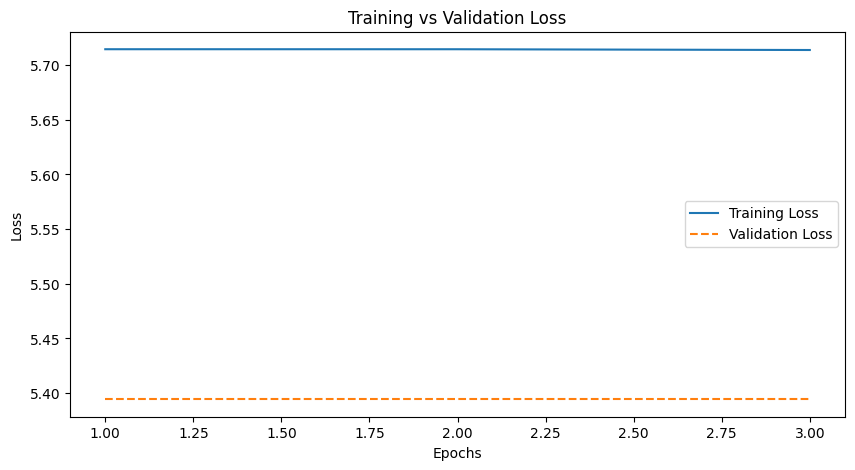

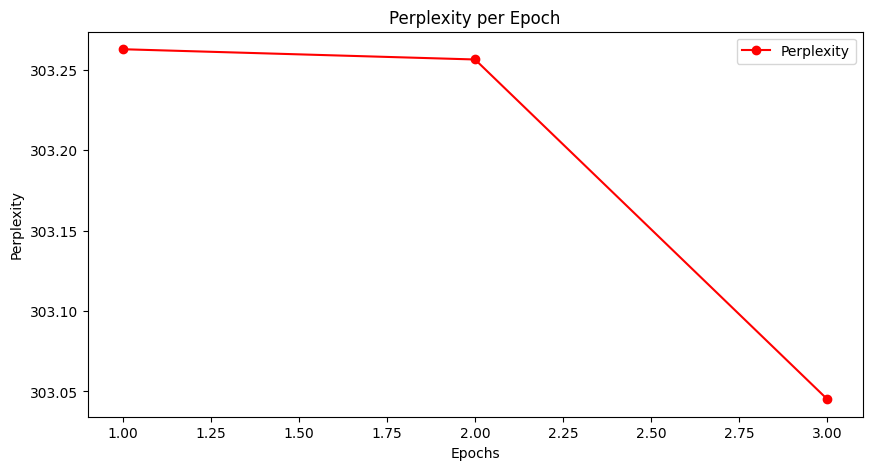

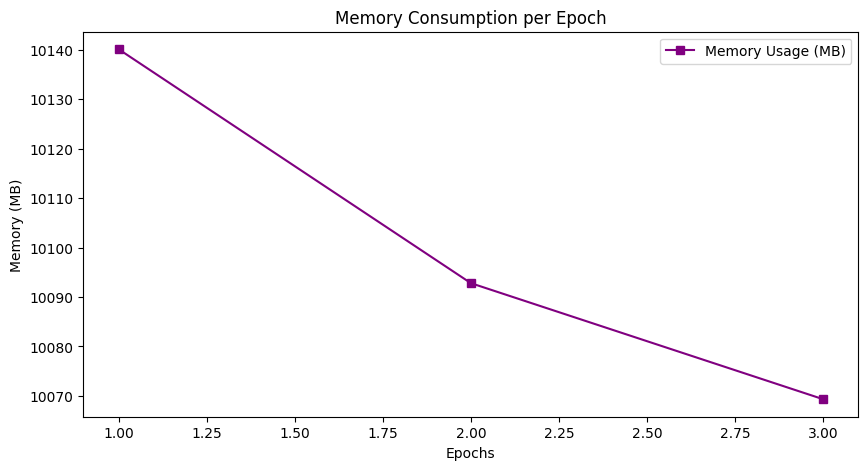

Fine-tuning complete.


In [ ]:
import psutil
import time
from fvcore.nn import FlopCountAnalysis
from codecarbon import EmissionsTracker
from sklearn.metrics import log_loss
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from transformers import get_scheduler
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import T5Tokenizer
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler, autocast

# Define training parameters
optimizer = optim.AdamW(quantized_model.parameters(), lr=2e-5, weight_decay=0.01)  # Adjust learning rate as needed
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=10000
)
loss_fn = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id, label_smoothing=0.1)

#Distributed setup
# Initialize process group for distributed training
num_gpu = torch.cuda.device_count()
print(f"Running on {num_gpu} GPUs")

epochs = 3  # Adjust number of epochs as needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantized_model.to(device)

# Mixed precision
scaler = GradScaler()

#Defining lists of metrics evaluation
train_losses = []
val_losses = []
perplexities = []
energy_consumptions = []
memory_usages = []
train_times = []

# Mixed precision
scaler = GradScaler()

# Fine-tuning loop
for epoch in range(epochs):
    quantized_model.train()
    print(f"Epoch {epoch + 1}/{epochs}")

    loss_values = []
    nb_batch = []
    tracker = EmissionsTracker()
    tracker.start()

    start_time = time.time()
    total_loss = 0
    total_samples = 0
    i = 0
    gradient_accumulation_steps = 2

    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        i+=1
        nb_batch.append(i)

        optimizer.zero_grad()

        #Forward pass
        with autocast():
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = quantized_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()

        #Gradient accumulation
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loss_values.append(loss.item())
        total_samples += len(labels)

        # Scale the loss
        print(f"Batch {i}/{len(train_dataloader)} - Loss: {loss.item()}")

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss}")

    # Perplexity Calculation
    perplexity = torch.exp(torch.tensor(avg_loss))
    perplexities.append(perplexity.item())
    print(f"Epoch {epoch+1}/{epochs}, Perplexity: {perplexity:.2f}")

    # Validation Step
    quantized_model.eval()
    val_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = quantized_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            total_val_samples += len(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}")

    #Evaluate memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    memory_usages.append(memory_usage)
    print(f"Epoch {epoch+1}/{epochs}, Memory Usage: {memory_usage} MB")

    #Evaluate training time per step
    total_time = time.time() - start_time
    train_times.append(total_time / 60)
    print(f"Epoch {epoch+1}/{epochs}, Total Training Time: {total_time / 60:.2f} minutes")

    #Track energy consumption
    tracker.stop()
    print(f"Epoch {epoch+1}/{epochs}, Energy Consumption: {tracker}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), perplexities, label="Perplexity", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity per Epoch")
plt.legend()
plt.show()

# Plot Memory Usage
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), memory_usages, label="Memory Usage (MB)", marker="s", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Memory (MB)")
plt.title("Memory Consumption per Epoch")
plt.legend()
plt.show()
'''
# Plot Energy Consumption
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), energy_consumptions, label="Energy Consumption (kg CO2)", marker="d", color="green")
plt.xlabel("Epochs")
plt.ylabel("Energy (kg CO2)")
plt.title("Energy Consumption per Epoch")
plt.legend()
plt.show()
'''
# Save the trained model (optional)
torch.save(model.state_dict(), "trained_model.pth")

print("Fine-tuning complete.")


In [ ]:
#Test and evaluate
!pip install sentence-transformers
!pip install nltk

from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from rouge import Rouge
from sentence_transformers import SentenceTransformer, util
import psutil
import time
from fvcore.nn import FlopCountAnalysis
from codecarbon import EmissionsTracker
from nltk.translate.bleu_score import corpus_bleu

def generate_conversation(persona1, persona2):
    input_text = persona1 + persona2
    input_ids = TOKENIZER(input_text, return_tensors="pt").input_ids

    # Generate response
    output_ids = model.generate(input_ids, max_length=150, num_beams=5, temperature=0.7)
    output_text = TOKENIZER.decode(output_ids[0], skip_special_tokens=True)

    return output_text

persona1 = "I love hiking and nature walks. I also enjoy photography."
persona2 = "I prefer staying indoors and reading books. I love mystery novels."
generated_conversation = generate_conversation(persona1, persona2)

print("Generated Chatbot Conversation:\n", generated_conversation)

def calculate_bleu_score(predictions, references):
    # Tokenize predictions and references
    tokenized_references = [[ref.split()] for ref in references]
    tokenized_predictions = [pred.split() for pred in predictions]

    # Compute BLEU score
    return corpus_bleu(tokenized_references, tokenized_predictions)

def calculate_rouge_score(predictions, true_labels):
    rouge = Rouge()
    # Decode predictions and true_labels to strings before passing to Rouge
    predictions_decoded = [TOKENIZER.decode(p, skip_special_tokens=True) for p in predictions]
    true_labels_decoded = [TOKENIZER.decode(l, skip_special_tokens=True) for l in true_labels]

    # Filter out empty hypotheses and corresponding references
    filtered_predictions_decoded = []
    filtered_true_labels_decoded = []
    for pred, label in zip(predictions_decoded, true_labels_decoded):
        if pred.strip(): # Check if the prediction is not empty after stripping whitespace
            filtered_predictions_decoded.append(pred)
            filtered_true_labels_decoded.append(label)

    # Calculate average scores only if there are valid predictions
    if filtered_predictions_decoded:
        scores = rouge.get_scores(filtered_predictions_decoded, filtered_true_labels_decoded, avg=True)
    else:
        scores = {'rouge-1': {'f': 0, 'p': 0, 'r': 0}, 'rouge-2': {'f': 0, 'p': 0, 'r': 0}, 'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
    return scores

def calculate_persona_consistency_score(persona_1_statements, persona_2_statements, predicted_response):
    # Initialize a SentenceTransformer model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')  # You can choose a different pre-trained model if needed

    # Encode persona statements
    persona_1_embedding = sentence_model.encode(persona_1_statements, convert_to_tensor=True)
    persona_2_embedding = sentence_model.encode(persona_2_statements, convert_to_tensor=True)

    # Decode predicted_response to string before encoding
    predicted_response_decoded = TOKENIZER.decode(predicted_response[0], skip_special_tokens=True)  # Assuming predicted_response is a tensor
    response_embedding = sentence_model.encode(predicted_response_decoded, convert_to_tensor=True)

    # Compute cosine similarity
    user_1_score = util.pytorch_cos_sim(response_embedding, persona_1_embedding).mean().item()
    user_2_score = util.pytorch_cos_sim(response_embedding, persona_2_embedding).mean().item()

    # Compute average consistency score
    avg_consistency_score = (user_1_score + user_2_score) / 2

    return avg_consistency_score, user_1_score, user_2_score

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []  # Store all predictions
    all_labels = []  # Store all labels

    with torch.no_grad():
      for batch in test_dataloader:
            input_ids =  batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Generate model responses
            outputs = model.generate(input_ids, max_length=50)
            predictions = [TOKENIZER.decode(output, skip_special_tokens=True) for output in outputs]
            references = [TOKENIZER.decode(label, skip_special_tokens=True) for label in labels]

             # Pass labels as decoder_input_ids during evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # Get predictions from the logits
            predictions = torch.argmax(outputs.logits, dim=2)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Compare predictions with shifted labels for accuracy calculation
            shifted_labels = labels[..., 1:]  # Shift labels to the right by one position
            predictions = predictions[..., :-1]  # Remove the last prediction
            # Calculate accuracy for valid predictions (ignoring padding)
            active_positions = shifted_labels != -100  # Ignore padding positions (-100)
            correct_predictions = (predictions == shifted_labels) * active_positions
            correct += correct_predictions.sum().item()
            total += active_positions.sum().item()

            # Perplexity Calculation
            avg_loss = total_loss / len(test_dataloader)
            perplexity = torch.exp(torch.tensor(avg_loss))
            perplexities.append(perplexity.item())
            print(f"Epoch {epoch+1}/{epochs}, Perplexity: {perplexity:.2f}")

            # Rouge score is a recall-based evaluation
            rouge_score= calculate_rouge_score(shifted_labels, predictions)

            # Compute BLEU score
            bleu_score = calculate_bleu_score(all_predictions, all_labels)

            # Persona Consistency Score
            average_consistency_score, user_1_score, user_2_score = calculate_persona_consistency_score(persona1, persona2, predictions)
            inference_time=total_time / len(test_dataloader)

            # Create a DataFrame for logging
            evaluation_data = {
              "Metric": ["Perplexity", "Bleu Score","Rouge Score","Average Consistency Score",
                          "Persona 1 Score", "Persona 2 Score", "Inference Time"
                          ],
              "Value": [torch.mean(perplexities), bleu_score, rouge_score,
                        average_consistency_score, user_1_score,
                        user_2_score, inference_time]
              }
            df = pd.DataFrame(evaluation_data)
    return df
    # Display in a tab (Colab only)
    from google.colab import data_table
    data_table.DataTable(df)

    # Plot Perplexity
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), perplexities, label="Perplexity", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Perplexity")
    plt.title("Perplexity per Epoch - Test")
    plt.legend()
    plt.show()


evaluate(quantized_model, test_dataloader)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

ModuleNotFoundError: No module named 'rouge'

In [ ]:
#if loss is still high : try with this model
#model = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-small")